# **Convolutional Neural Network Filter Bank for Musical Instruments Classification**

# Professor Supervisor: Prof. Gerald Schuller
# Research Assistant Supervisor: Renato de C. R. Profeta
# Author: Param Tushar Gadam
# Date: 1st June, 2020
# Master of Science in Communications and Signal Processing, Ilmenau University of Technology, Germany

# **Colab Runtime Configurations**

In [1]:
# Install torchaudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.9MB 7.5MB/s 


# **Imports and Configuration**

In [2]:
# Imports

## Numerical Computing
import numpy as np
import itertools

## File System and Files Handling
import os
from zipfile import ZipFile

## Python Serialization
import pickle

## Audio Processing
import librosa.display, librosa
import torchaudio

## Plotting and Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.core.display import HTML, display, Image

## Machine Learning ´
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_squared_error

## Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import math

In [3]:
# Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [4]:
## Check CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#map_location=torch.device('cpu')
#please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
#torch.load(map_location)

cuda


In [5]:
# Configure Tensorboard
%load_ext tensorboard

In [6]:
#logs_base_dir = "runs"
#os.makedirs(logs_base_dir, exist_ok=True)

# **Download the dataset from Dropbox**

In [7]:
# Download the dataset from Dropbox
!wget -O dataset.zip https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0

--2021-06-26 13:52:43--  https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip [following]
--2021-06-26 13:52:43--  https://www.dropbox.com/s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8424b9d3479e70e17cc704d182.dl.dropboxusercontent.com/cd/0/inline/BRLGDp9WrEAlR6AVFrweb1KO3kal7TBB7TZPyZ5RkBgCV7WLcmAVveaV70ae-QLgsphkrUEatrFV9KlsIuqeU0kA9O52J1GcrHRtS3GTQFtlKqbnmZAOSJyqe8gI_oKLsZksQ-J0PaJuyQu7mIU6vXgr/file# [following]
--2021-06-26 13:52:43--  https://uc8424b9d3479e70e17cc704d182.dl.dropboxusercontent.com/cd/0/inline/BRLGDp9WrEAlR6AVFrweb1KO3kal7TBB7TZPyZ5RkBgCV7WLcmAV

# **Extract .zip**

In [8]:
with ZipFile('dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

# **Get Dataset Metadata from GitHub**

In [9]:
# Clone github in Google Colab
!git clone https://github.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-.git

Cloning into '-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-'...
remote: Enumerating objects: 2823, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 2823 (delta 55), reused 23 (delta 14), pack-reused 2738
Receiving objects: 100% (2823/2823), 2.21 GiB | 38.62 MiB/s, done.
Resolving deltas: 100% (1690/1690), done.
Checking out files: 100% (441/441), done.


In [10]:
# Load Train Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/train_set_dataframe.pkl', 'rb') as f:
  train_set = pickle.load(f)
#Load Test Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/test_set_dataframe.pkl', 'rb') as f:
  test_set = pickle.load(f)

# **Encode Labels**

In [12]:
# Encode Labels Test Set
labelencoder = LabelEncoder()
labelencoder.fit(test_set['class'].values.tolist())
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_int_test = labelencoder.transform(test_set['class'].values.tolist())

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels_test=encoder.fit_transform(classes_int_test.reshape(len(classes_int_test),1))
#print(labelencoder.fit(test_set['class'].values.tolist()))
print((labelencoder.classes_[19]))



20 classes: banjo, bass-clarinet, bassoon, cello, clarinet, contrabassoon, double-bass, english-horn, flute, french-horn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin
violin


# **Create PyTorch Datasets for Training and Testing**

In [13]:
# Dataset Class
class dataset(Dataset):
    """An abstract class representing a Dataset.

    Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau Germany
    """
    def __init__(self, files, labels):
        self.labels = labels
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
      x_numpy = np.load(self.files[index])
      X = torch.from_numpy(x_numpy)
      X /= torch.abs(X).max()  # Normalize
      X = torch.reshape(X,(1,-1)) # Reshape for Model
      y_labels = torch.tensor(self.labels[index]) #Labels Out
      return X,y_labels

In [14]:
# Create Sets
#train_set_torch = dataset(train_set['filename'].values.tolist(), onehot_labels_train)
test_set_torch = dataset(test_set['filename'].values.tolist(), onehot_labels_test)

In [15]:
# Data Loader.
#training_generator = DataLoader(train_set_torch, batch_size=1, shuffle=False, num_workers=0)
validation_generator = DataLoader(test_set_torch, batch_size=1, shuffle=False, num_workers=0)

# **Testing Dataset and Dataloader**

In [16]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [17]:
# Calculate Spectrogram of the audio file to test
specgram = torchaudio.transforms.Spectrogram(n_fft=2048)(audio_to_test[0,0,:])

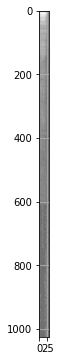

In [18]:
# Plot Spectrogram of audio to test
plt.figure(figsize=(10,6))
plt.imshow(20*specgram.log10().numpy(), cmap='gray')
plt.grid()

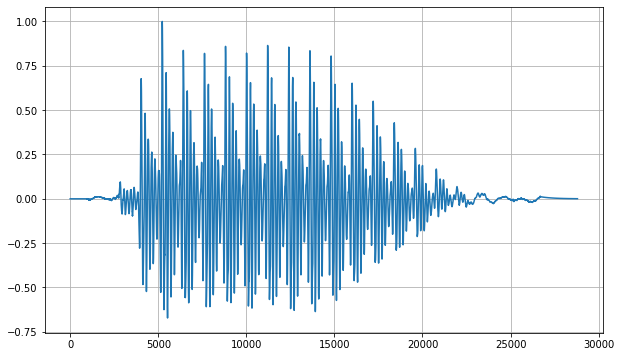

In [19]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.grid()

In [20]:
# Listen to audio
ipd.Audio(audio_to_test[0,0,:], rate=44100) # load a local WAV file

In [21]:
test_set_torch = dataset(test_set['filename'].values.tolist(), onehot_labels_test)

In [22]:
validation_generator = DataLoader(test_set_torch, batch_size=1, shuffle=False, num_workers=0)

In [24]:
test_list = test_set['duration'].values.tolist()
test_class = test_set['class'].values.tolist()

In [25]:
print(test_list)
print(test_list[3420])
print(len(test_list))

[1.123265306122449, 0.6008163265306122, 2.1681632653061222, 1.123265306122449, 1.0971428571428572, 1.2277551020408164, 0.5485714285714286, 0.9926530612244898, 0.39183673469387753, 1.0710204081632653, 0.5224489795918368, 0.3395918367346939, 0.9404081632653061, 0.6791836734693878, 1.9591836734693877, 1.0971428571428572, 1.3061224489795917, 1.2016326530612245, 3.5787755102040815, 1.8808163265306121, 0.6008163265306122, 0.5485714285714286, 3.082448979591837, 0.4179591836734694, 0.47020408163265304, 1.8808163265306121, 1.0710204081632653, 1.8808163265306121, 1.8024489795918368, 1.28, 1.8808163265306121, 1.3322448979591837, 1.28, 0.4440816326530612, 0.5224489795918368, 0.809795918367347, 0.2873469387755102, 0.6008163265306122, 1.3061224489795917, 1.3061224489795917, 1.123265306122449, 1.5151020408163265, 1.8285714285714285, 1.5412244897959184, 0.7053061224489796, 5.877551020408164, 0.9926530612244898, 0.9404081632653061, 0.9926530612244898, 0.6530612244897959, 0.7575510204081632, 1.149387755

# **Experiment Results for experiment 2**

#  load pickle file needed for plotting results for experiment 2

In [26]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/histexp2.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [30]:
hist = hist1['hist']
total = 3421
value = 0.0004



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) < value :
     print(hist["valid_rmse"][0][i][0] ,test_class[i])

0.0003728509 percussion


In [32]:
hist = hist1['hist']
total = 3421
value = 0.07



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) > value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.08648942, dtype=float32)] percussion
[array(0.11283766, dtype=float32)] percussion
[array(0.07965899, dtype=float32)] violin
[array(0.089656, dtype=float32)] percussion
[array(0.10125464, dtype=float32)] percussion


In [33]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))
#print(torch.tensor(hist["valid_predictions"]))
#print(torch.tensor(np.argmax(onehot_labels_test,axis=1)))

Validation errors 755 (out of 3421)
Validation correct 2666 (out of 3421)


In [34]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)


In [35]:
test_list = test_set['duration'].values.tolist()
test_class = test_set['class'].values.tolist()
print(len(test_class))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

3421


In [36]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [37]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Bar Chart for Correct Predictions for experiment2

In [38]:
banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[15, 215, 141, 130, 167, 156, 170, 160, 158, 117, 19, 13, 110, 19, 140, 182, 79, 208, 188, 279]


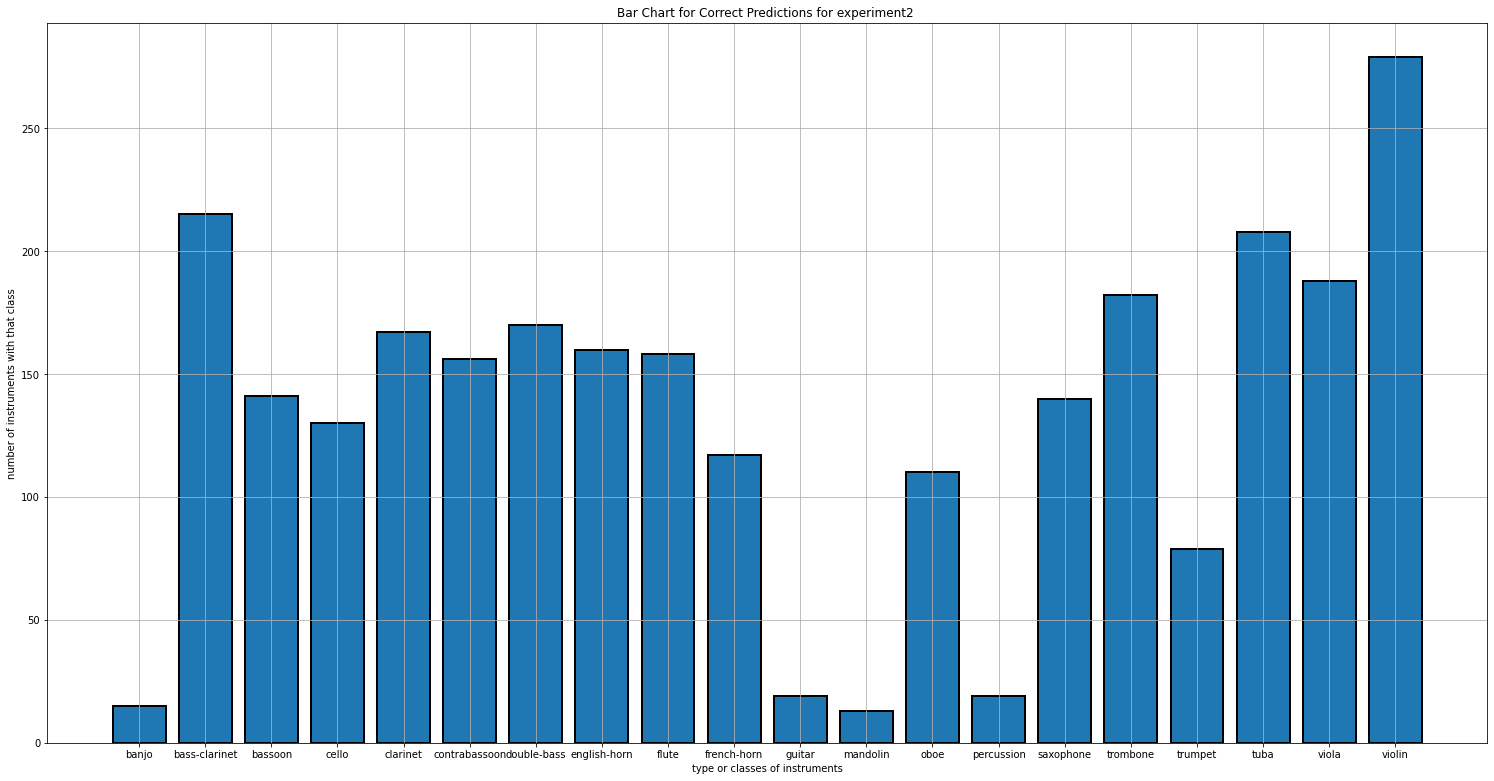

In [39]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for experiment2 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()

Bar Chart for Wrong Predictions for experiment2

In [40]:
banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[2, 40, 54, 54, 47, 23, 30, 30, 105, 28, 4, 5, 32, 15, 16, 33, 55, 45, 59, 78]


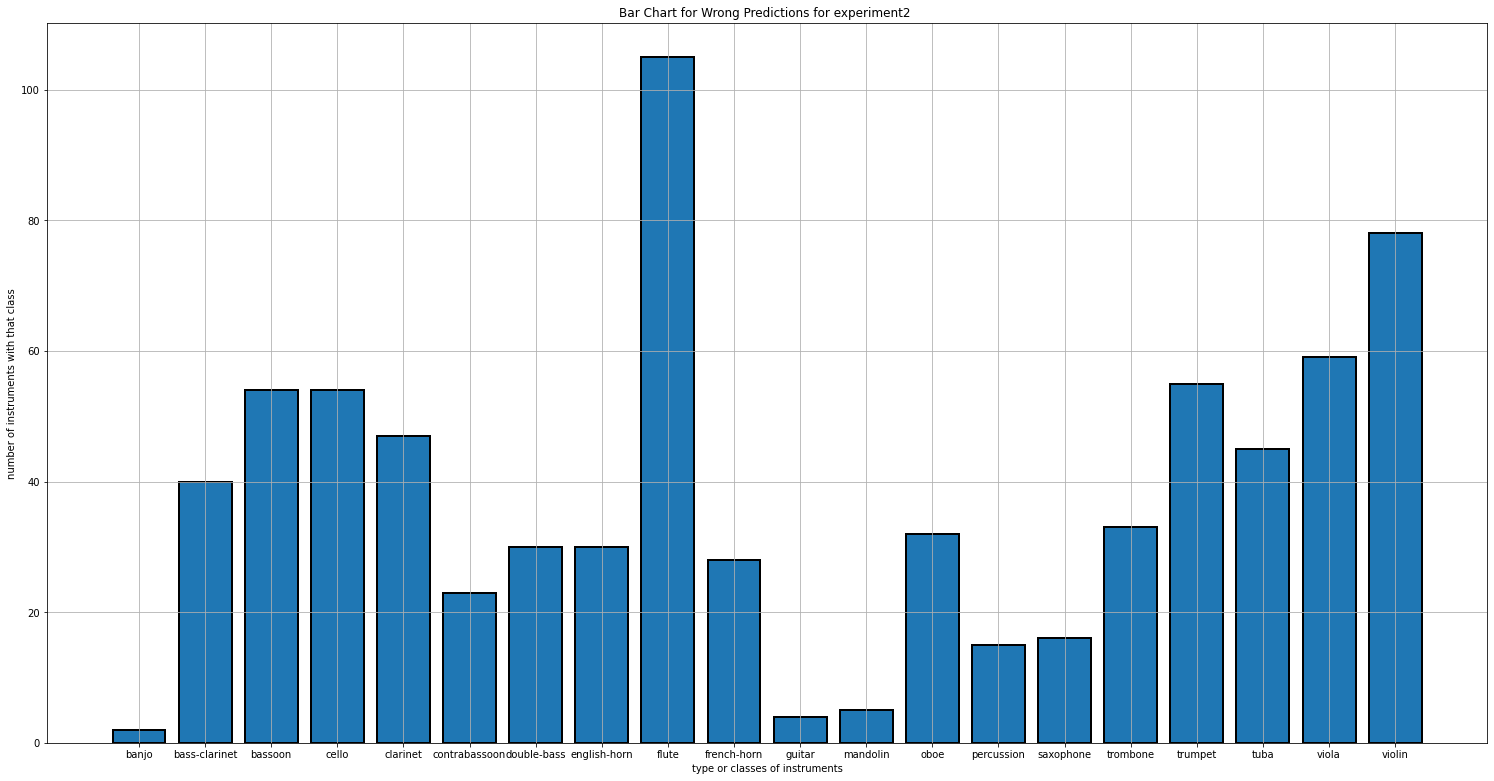

In [41]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for experiment2 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()

Grouped Bar Chart for Correct and Wrong Predictions for experiment2

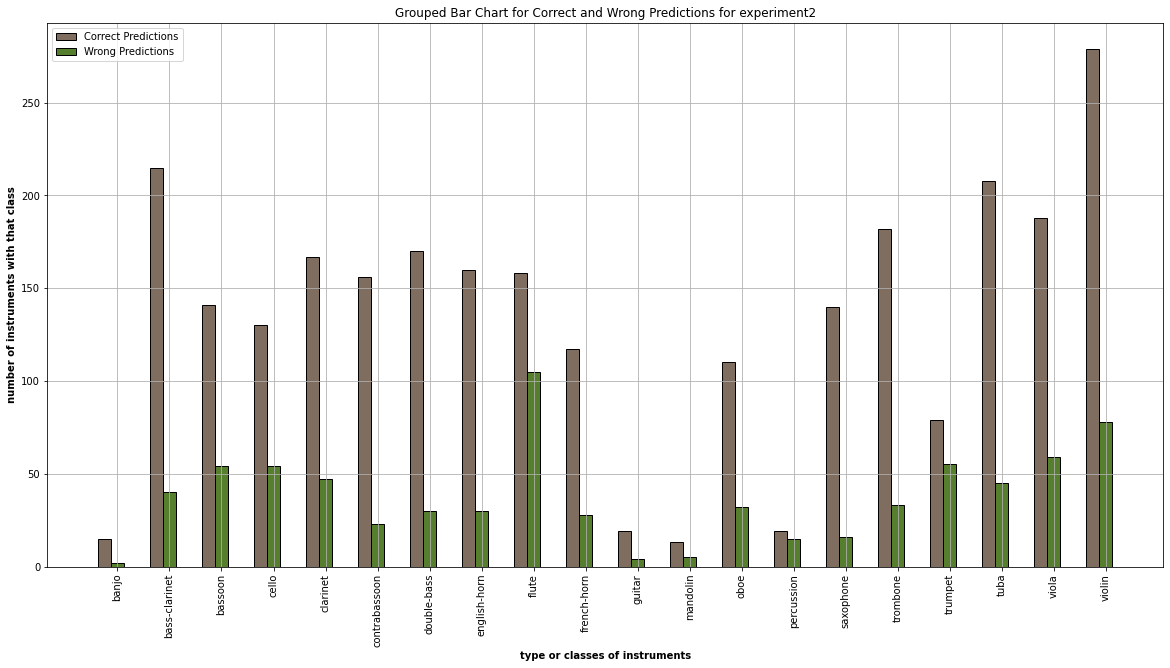

In [42]:
# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.title('Grouped Bar Chart for Correct and Wrong Predictions for experiment2')
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
plt.grid()
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for experiment2

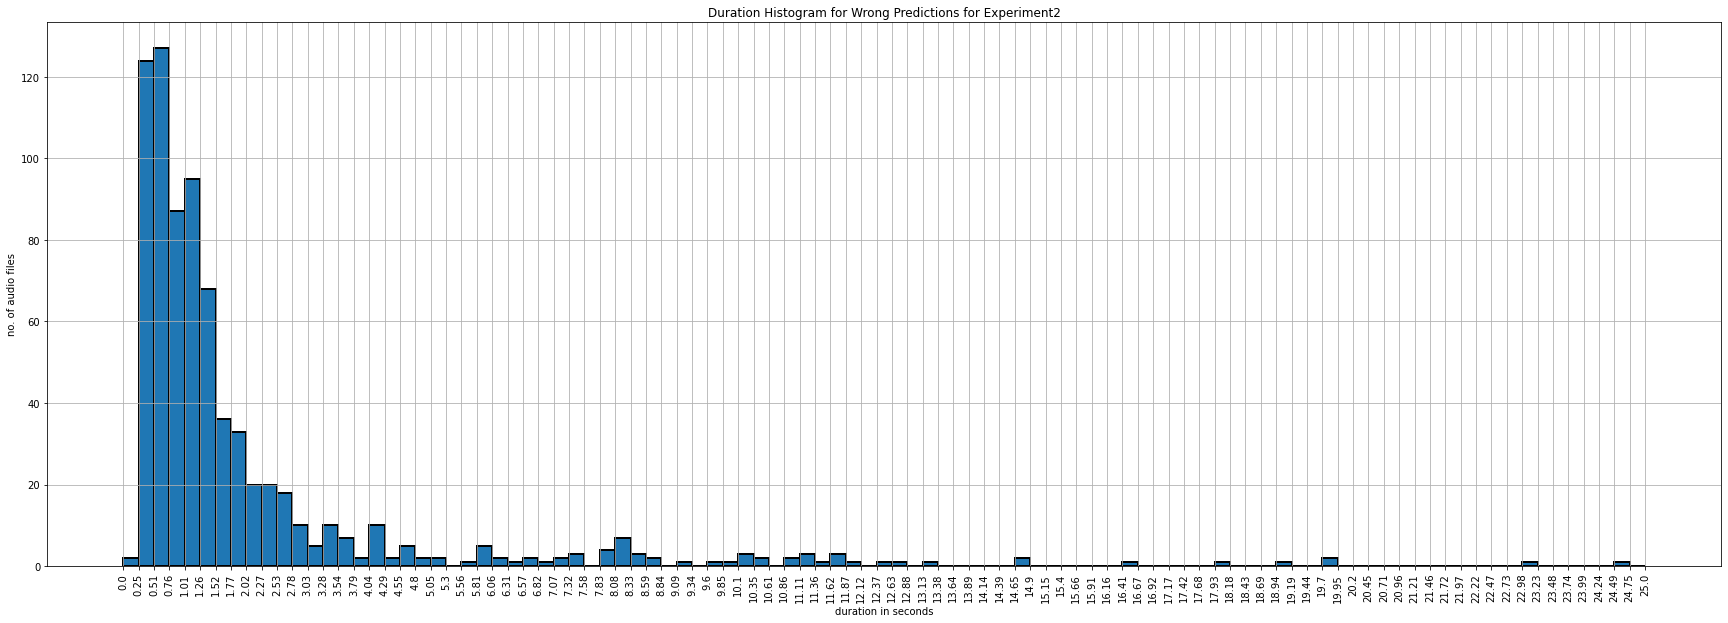

In [43]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

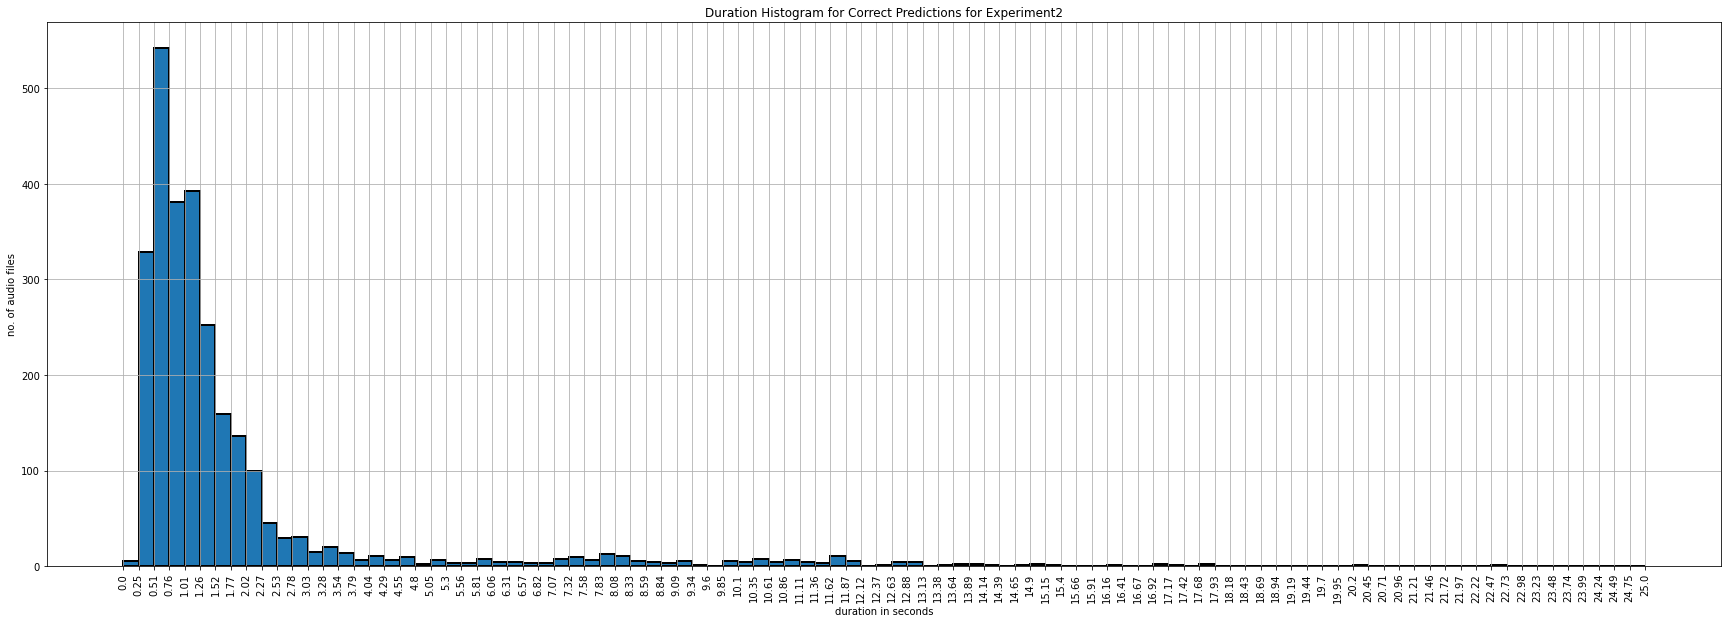

In [44]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [117]:
#print((wrong_pred [0]))
#print((wrong_pred [0][754]))
print((correct_pred[0][2665]))

3420


In [118]:
print((test_list))
print(test_list[wrong_pred [0][754]])
print(test_list[3418])

[1.123265306122449, 0.6008163265306122, 2.1681632653061222, 1.123265306122449, 1.0971428571428572, 1.2277551020408164, 0.5485714285714286, 0.9926530612244898, 0.39183673469387753, 1.0710204081632653, 0.5224489795918368, 0.3395918367346939, 0.9404081632653061, 0.6791836734693878, 1.9591836734693877, 1.0971428571428572, 1.3061224489795917, 1.2016326530612245, 3.5787755102040815, 1.8808163265306121, 0.6008163265306122, 0.5485714285714286, 3.082448979591837, 0.4179591836734694, 0.47020408163265304, 1.8808163265306121, 1.0710204081632653, 1.8808163265306121, 1.8024489795918368, 1.28, 1.8808163265306121, 1.3322448979591837, 1.28, 0.4440816326530612, 0.5224489795918368, 0.809795918367347, 0.2873469387755102, 0.6008163265306122, 1.3061224489795917, 1.3061224489795917, 1.123265306122449, 1.5151020408163265, 1.8285714285714285, 1.5412244897959184, 0.7053061224489796, 5.877551020408164, 0.9926530612244898, 0.9404081632653061, 0.9926530612244898, 0.6530612244897959, 0.7575510204081632, 1.149387755

In [119]:
print(nos_err)
print(nos_corr)
print(total)

755
2666
3421


In [505]:
bc_wrong = []
bc_correct = []
bc_all = []
initial = 0.0
final = 0.25

In [506]:
for z in range(nos_err):
  #print(hist["valid_rmse"][0][wrong_pred [0][z]][0] ,test_class[wrong_pred [0][z]],test_list[wrong_pred [0][z]])
  if (test_list[wrong_pred [0][z]] >= initial) and (test_list[wrong_pred [0][z]] < final):
    bc_wrong.append(hist['valid_predictions'][0][wrong_pred [0][z]])

for z1 in range(nos_corr):
  #print(hist["valid_rmse"][0][wrong_pred [0][z]][0] ,test_class[wrong_pred [0][z]],test_list[wrong_pred [0][z]])
  if (test_list[correct_pred [0][z1]] >= initial) and (test_list[correct_pred [0][z1]] < final):
    bc_correct.append(hist['valid_predictions'][0][correct_pred [0][z1]])

for z2 in range(total):
  #print(hist["valid_rmse"][0][wrong_pred [0][z]][0] ,test_class[wrong_pred [0][z]],test_list[wrong_pred [0][z]])
  if (test_list[z2] >= initial) and (test_list[z2] < final):
    bc_all.append(test_class[z2])


In [507]:
print(len(bc_wrong))
print(len(bc_correct))
print(len(bc_all))

2
5
7


In [508]:

banjo_w = bc_wrong.count(0)
bassclarinet_w = bc_wrong.count(1)
bassoon_w = bc_wrong.count(2)
cello_w = bc_wrong.count(3)
clarinet_w = bc_wrong.count(4)
contrabassoon_w = bc_wrong.count(5)
doublebass_w = bc_wrong.count(6)
englishhorn_w = bc_wrong.count(7)
flute_w = bc_wrong.count(8)
frenchhorn_w = bc_wrong.count(9)
guitar_w = bc_wrong.count(10)
mandolin_w = bc_wrong.count(11)
oboe_w = bc_wrong.count(12)
percussion_w = bc_wrong.count(13)
saxophone_w = bc_wrong.count(14)
trombone_w = bc_wrong.count(15)
trumpet_w = bc_wrong.count(16)
tuba_w = bc_wrong.count(17)
viola_w = bc_wrong.count(18)
violin_w = bc_wrong.count(19)

arr1 = [banjo_w, bassclarinet_w, bassoon_w, cello_w, clarinet_w, contrabassoon_w, doublebass_w, englishhorn_w, flute_w, frenchhorn_w, guitar_w, mandolin_w, oboe_w, percussion_w, saxophone_w, trombone_w, trumpet_w, tuba_w, viola_w, violin_w]
print(arr1)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [509]:
banjo_c = bc_correct.count(0)
bassclarinet_c = bc_correct.count(1)
bassoon_c = bc_correct.count(2)
cello_c = bc_correct.count(3)
clarinet_c = bc_correct.count(4)
contrabassoon_c = bc_correct.count(5)
doublebass_c = bc_correct.count(6)
englishhorn_c = bc_correct.count(7)
flute_c = bc_correct.count(8)
frenchhorn_c = bc_correct.count(9)
guitar_c = bc_correct.count(10)
mandolin_c = bc_correct.count(11)
oboe_c = bc_correct.count(12)
percussion_c = bc_correct.count(13)
saxophone_c = bc_correct.count(14)
trombone_c = bc_correct.count(15)
trumpet_c = bc_correct.count(16)
tuba_c = bc_correct.count(17)
viola_c = bc_correct.count(18)
violin_c = bc_correct.count(19)

arr2 = [banjo_c, bassclarinet_c, bassoon_c, cello_c, clarinet_c, contrabassoon_c, doublebass_c, englishhorn_c, flute_c, frenchhorn_c, guitar_c, mandolin_c, oboe_c, percussion_c, saxophone_c, trombone_c, trumpet_c, tuba_c, viola_c, violin_c]
print(arr2)

[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0]


In [510]:
banjo_a = bc_all.count('banjo')
bassclarinet_a = bc_all.count('bass-clarinet')
bassoon_a = bc_all.count('bassoon')
cello_a = bc_all.count('cello')
clarinet_a = bc_all.count('clarinet')
contrabassoon_a = bc_all.count('contrabassoon')
doublebass_a = bc_all.count('double-bass')
englishhorn_a = bc_all.count('english-horn')
flute_a = bc_all.count('flute')
frenchhorn_a = bc_all.count('french-horn')
guitar_a = bc_all.count('guitar')
mandolin_a = bc_all.count('mandolin')
oboe_a = bc_all.count('oboe')
percussion_a = bc_all.count('percussion')
saxophone_a = bc_all.count('saxophone')
trombone_a = bc_all.count('trombone')
trumpet_a = bc_all.count('trumpet')
tuba_a = bc_all.count('tuba')
viola_a = bc_all.count('viola')
violin_a = bc_all.count('violin')

arr3 = [banjo_a, bassclarinet_a, bassoon_a, cello_a, clarinet_a, contrabassoon_a, doublebass_a, englishhorn_a, flute_a, frenchhorn_a, guitar_a, mandolin_a, oboe_a, percussion_a, saxophone_a, trombone_a, trumpet_a, tuba_a, viola_a, violin_a]
print(arr3)

[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0]


In [511]:
def foo(x,y):
    try:
        return x/y
    except ZeroDivisionError:
        return 0

In [512]:
print(arr1)
print(arr2)
print(arr3)

diff = []


difference = []
percent = []

arr4 = arr2
arr5 = arr3
zip_object = zip(arr5, arr4)
for arr5, arr4 in zip_object:
    difference.append(arr5-arr4)
    percent.append(foo(arr5-arr4,arr5))

print(difference)

for i in range(20):
 print(np.round(percent[i],2))








[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0]
[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
0
0
0.0
0
0
0
0
0
0
0
0
0
0
0
0.5
0
0
0.33
0
0


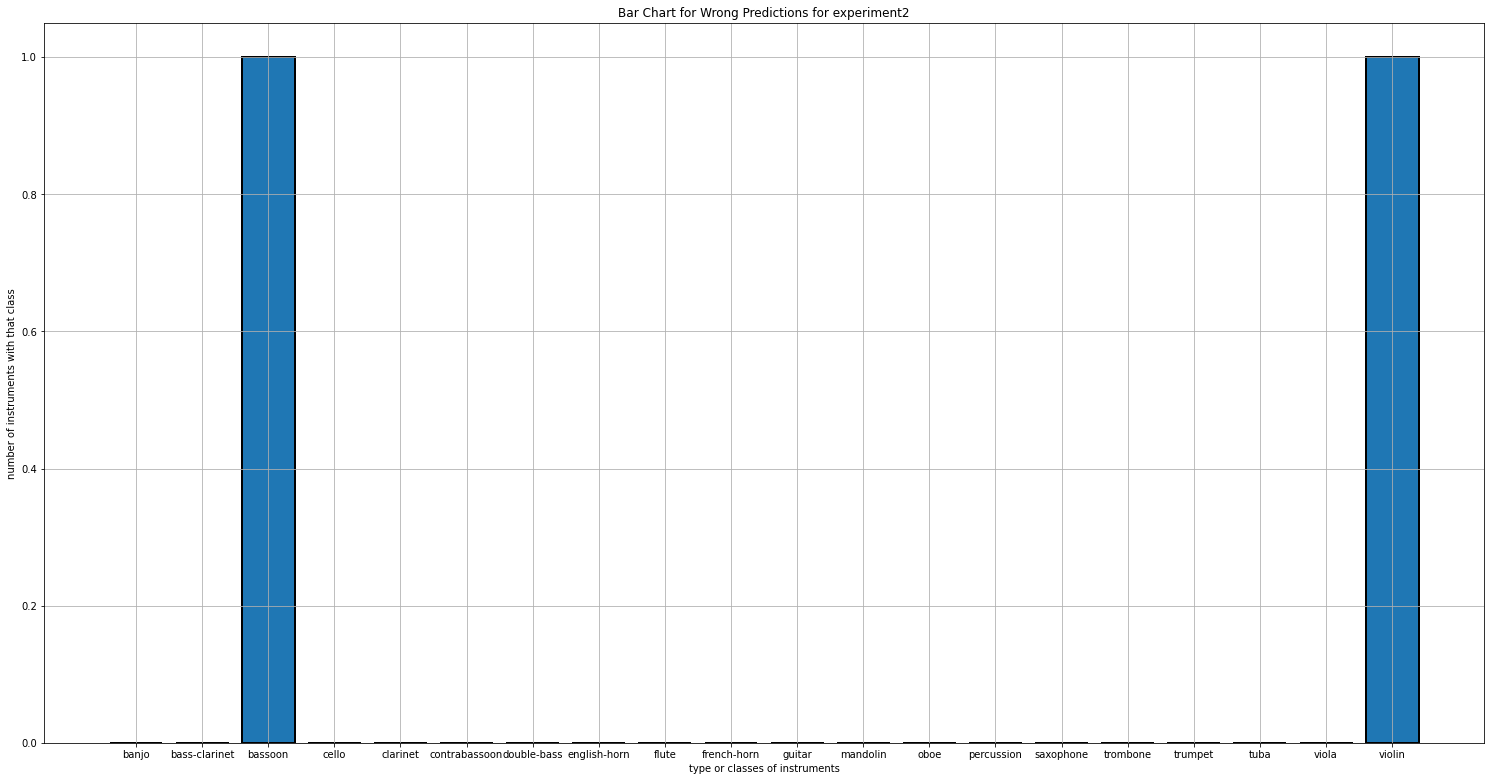

In [513]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for experiment2")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()

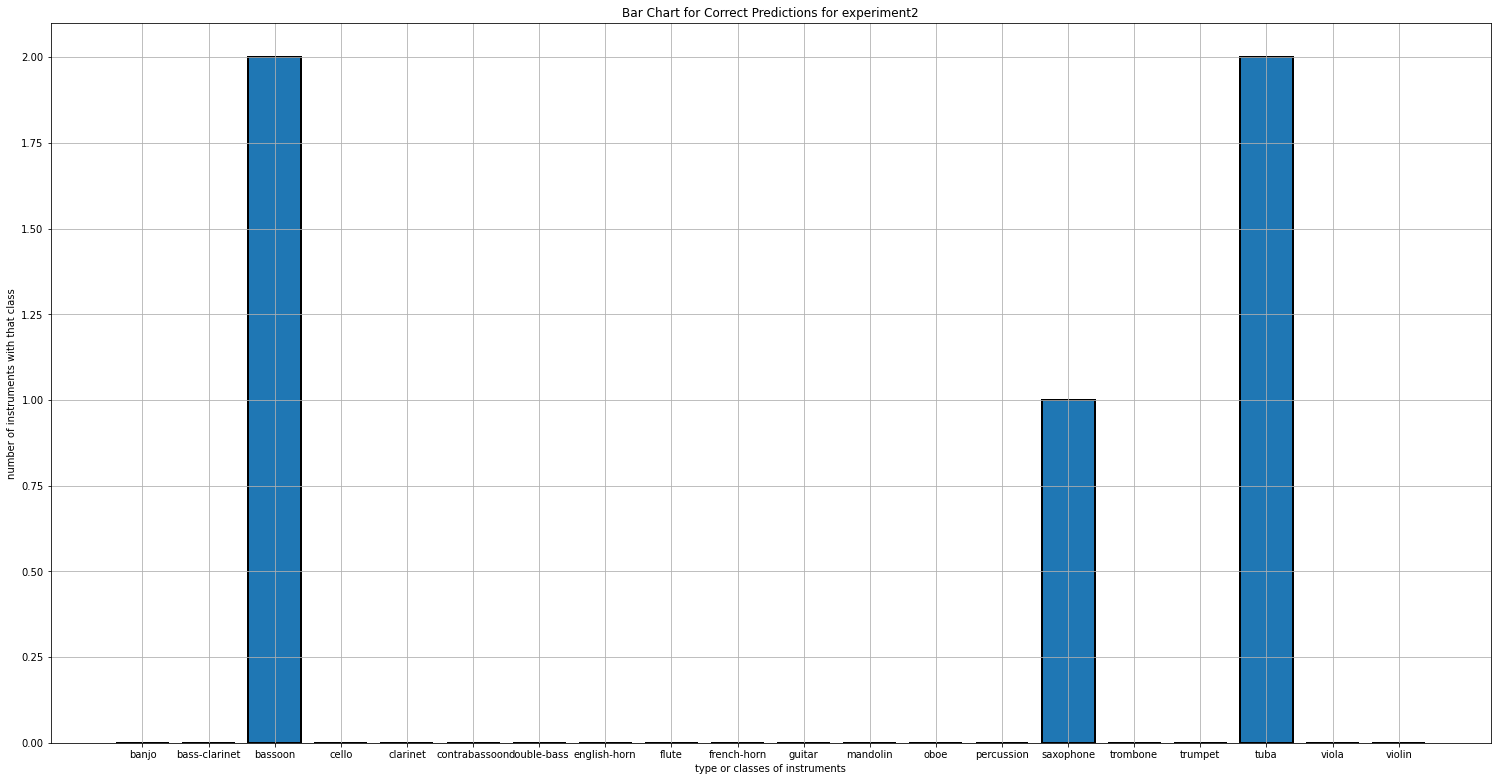

In [514]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for experiment2")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr2,edgecolor="black",linewidth=2)
plt.show()

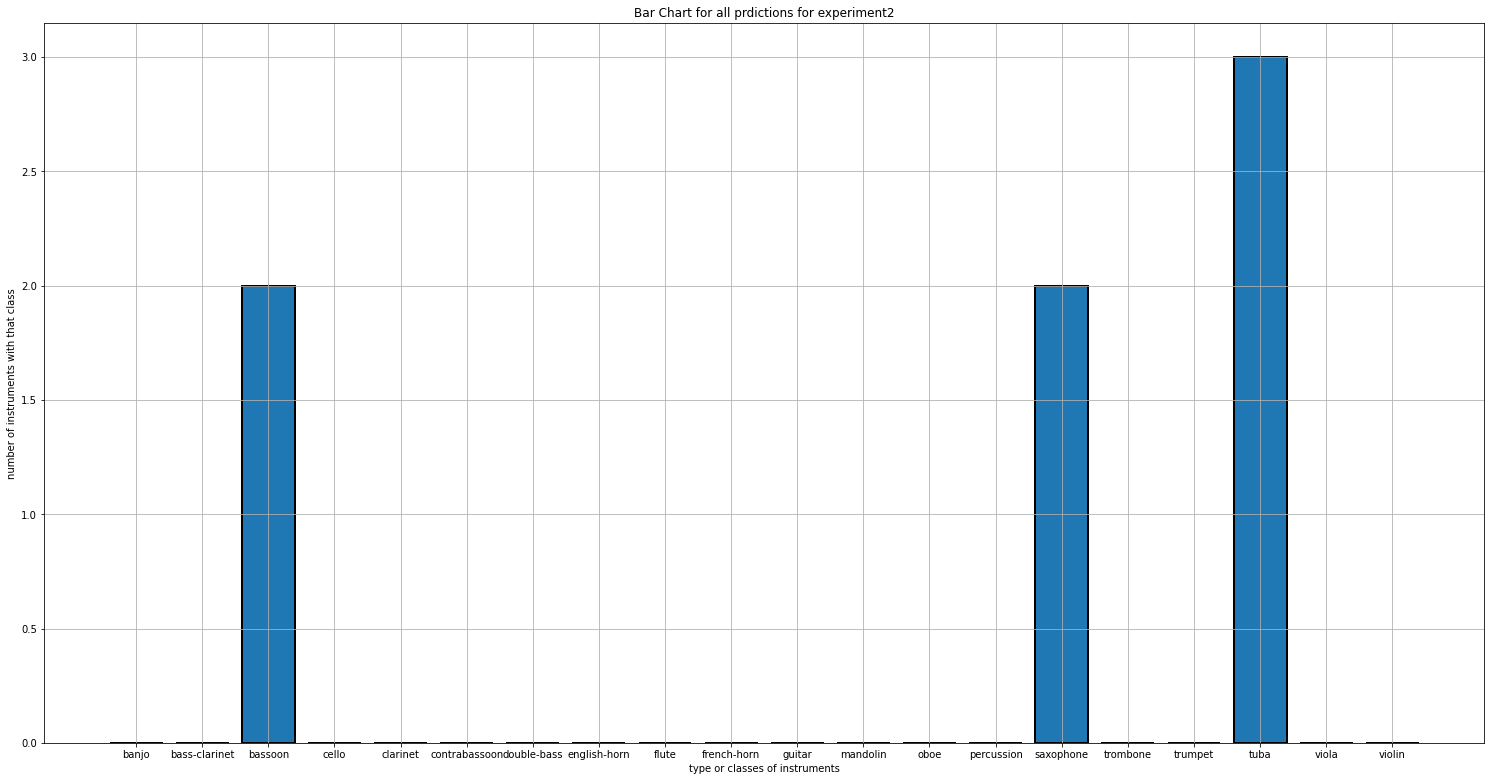

In [515]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for all prdictions for experiment2")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr3,edgecolor="black",linewidth=2)
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment2

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

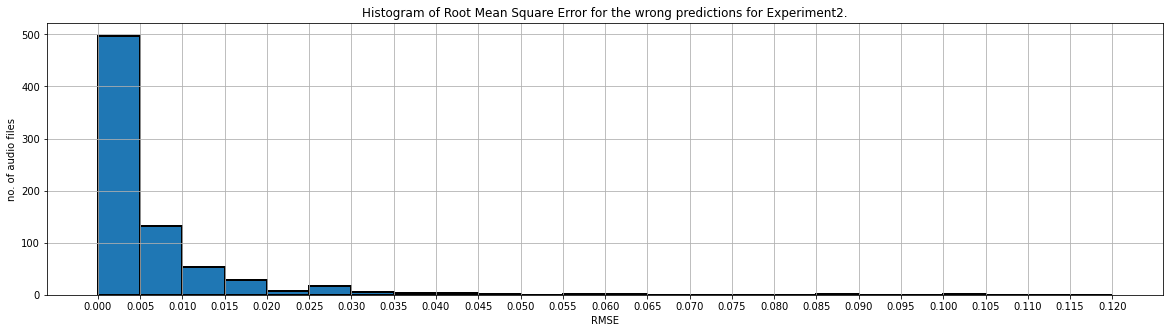

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

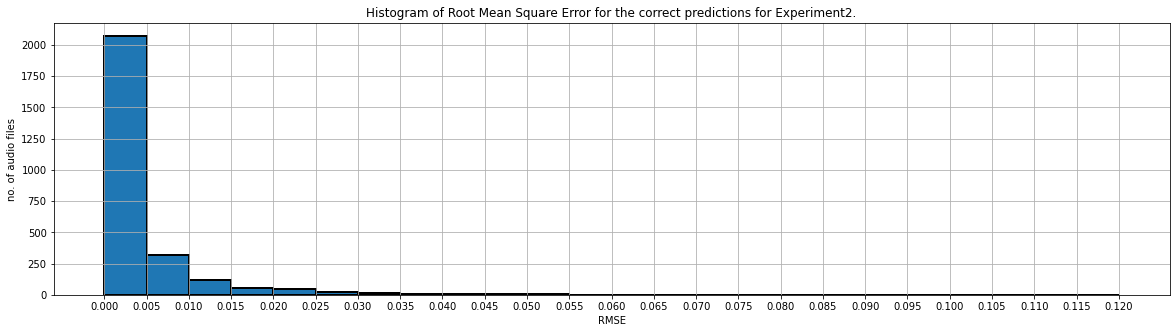

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

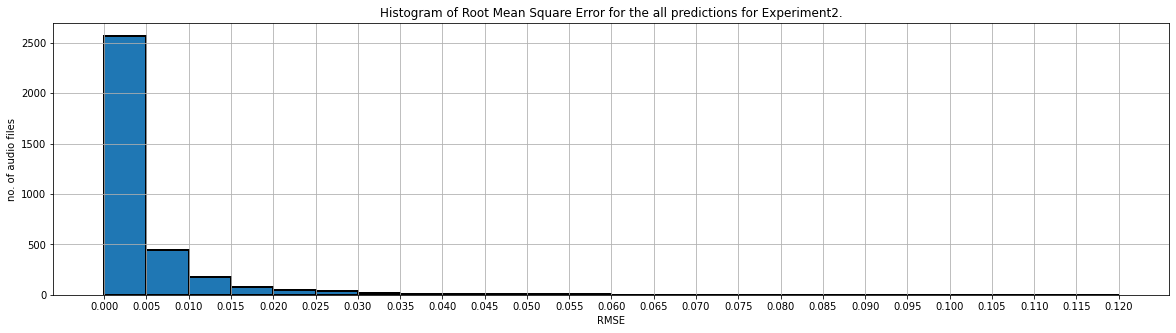

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment2

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83333333 0.91101695 0.78333333 0.58558559 0.78773585 0.87640449
 0.79812207 0.92485549 0.71818182 0.71779141 0.73076923 0.65
 0.73825503 0.51351351 0.76502732 0.875      0.65289256 0.85596708
 0.77366255 0.74202128]
Precision:  [0.88235294 0.84313725 0.72307692 0.70652174 0.78037383 0.87150838
 0.85       0.84210526 0.60076046 0.80689655 0.82608696 0.72222222
 0.77464789 0.55882353 0.8974359  0.84651163 0.58955224 0.82213439
 0.7611336  0.78151261]
F1-Score:  [0.85714286 0.87576375 0.752      0.64039409 0.78403756 0.87394958
 0.82324455 0.8815427  0.65424431 0.75974026 0.7755102  0.68421053
 0.75601375 0.53521127 0.8259587  0.86052009 0.61960784 0.83870968
 0.76734694 0.76125512]
Accuracy: 0.78  , 2666
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.84      0.91      0.88       236
           2       0.72      0.78      0.75       180
           3       0.71      0.59  

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

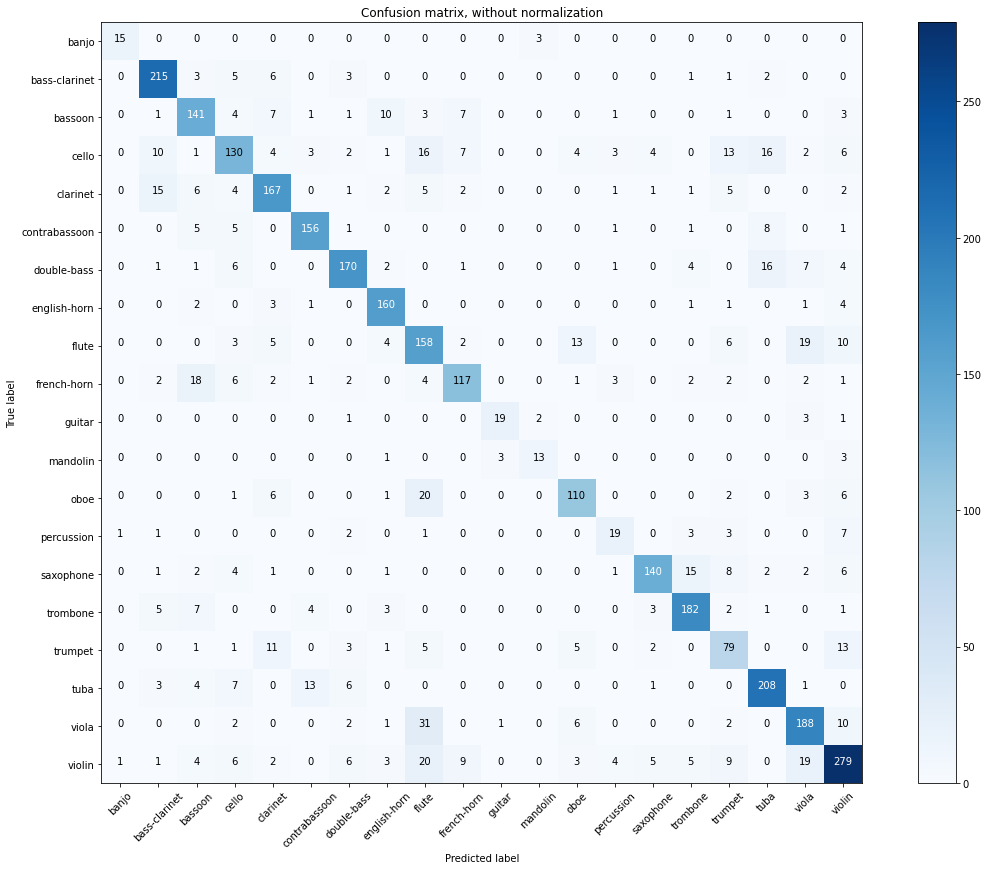

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for experiment 3**

#  load pickle file needed for plotting results for experiment 3

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment3/histexp3.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.0425



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) < value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0., dtype=float32)] viola
[array(0., dtype=float32)] cello
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] violin
[array(0., dtype=float32)] bassoon
[array(0., dtype=float32)] bassoon
[array(0.01, dtype=float32)] cello
[array(0.01, dtype=float32)] violin
[array(0., dtype=float32)] clarinet
[array(0.01, dtype=float32)] cello
[array(0., dtype=float32)] tuba
[array(0., dtype=float32)] bassoon
[array(0., dtype=float32)] french-horn
[array(0., dtype=float32)] contrabassoon
[array(0., dtype=float32)] double-bass
[array(0.01, dtype=float32)] double-bass
[array(0.01, dtype=float32)] flute
[array(0., dtype=float32)] viola
[array(0., dtype=float32)] contrabassoon
[array(0.01, dtype=float32)] double-bass
[array(0., dtype=float32)] saxophone
[array(0., dtype=float32)] bass-clarinet
[array(0.02, dtype=float32)] violin
[array(0., dtype=float32)] trombone
[array(0., dtype=float32)] oboe
[array(0.02, dtype=float32)] violin
[array(0., dtype=float32)] tuba
[array(0., dtype=float

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.25



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) > value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

In [ ]:
hist = hist1['hist']
#print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 609 (out of 3421)
Validation correct 2812 (out of 3421)


In [ ]:

# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3418, 3419, 3420]),)


In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))



Bar Chart for Correct Predictions for experiment3

In [ ]:
banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[16, 215, 153, 158, 173, 160, 175, 166, 160, 135, 21, 11, 121, 19, 149, 189, 78, 215, 199, 299]


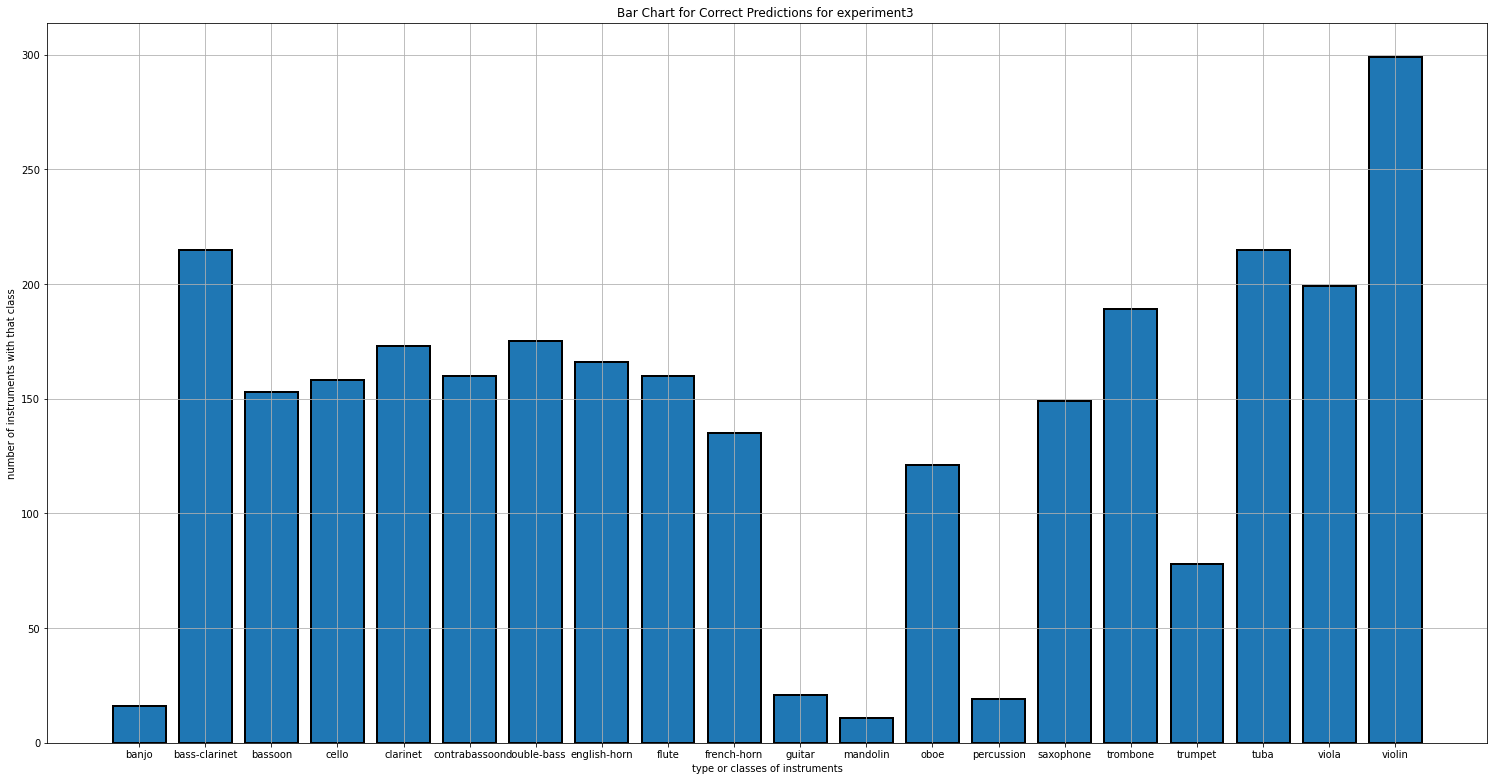

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for experiment3 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()

Bar Chart for Wrong Predictions for experiment3

In [ ]:
banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[3, 17, 26, 52, 39, 24, 31, 24, 89, 23, 7, 3, 31, 9, 9, 22, 37, 30, 61, 72]


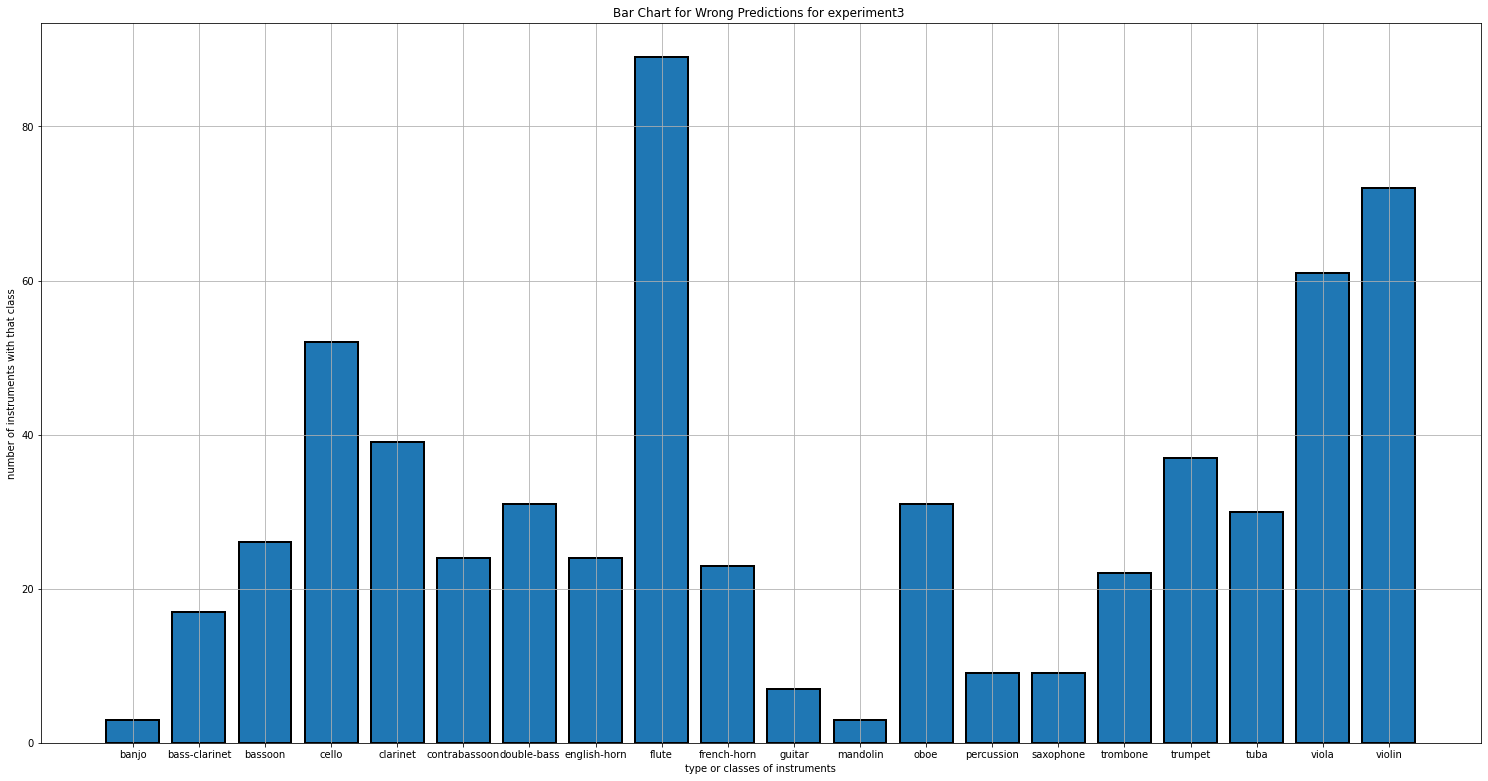

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for experiment3 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()


Grouped Bar Chart for Correct and Wrong Predictions for experiment3

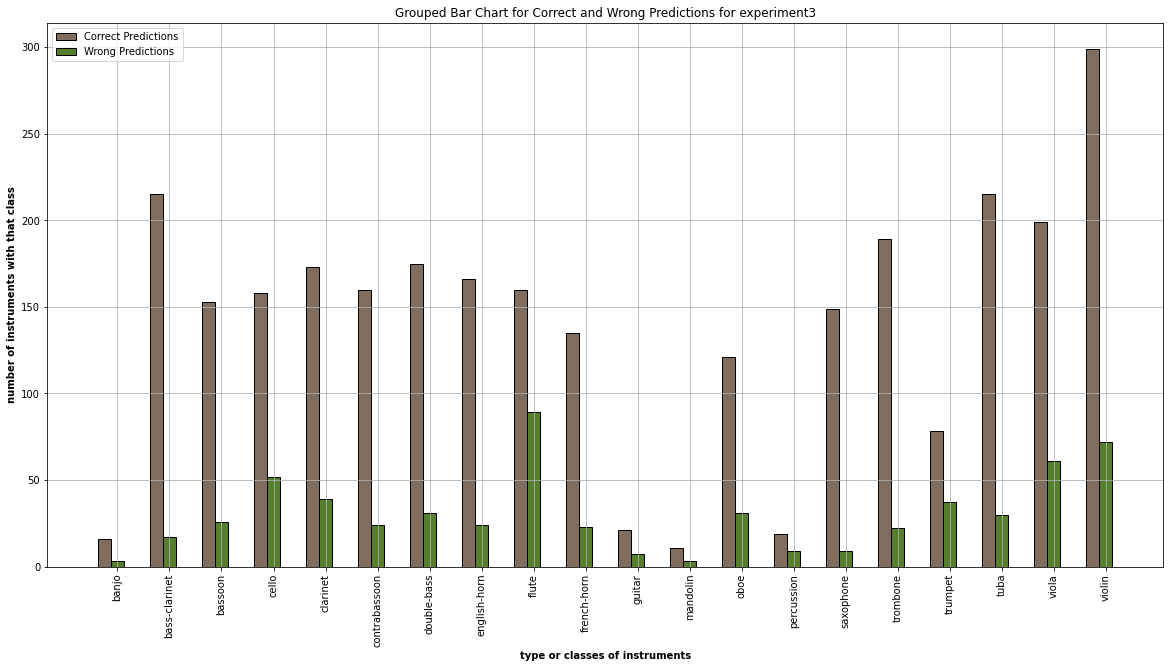

In [ ]:
# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.title('Grouped Bar Chart for Correct and Wrong Predictions for experiment3')
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
plt.grid()
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for experiment3

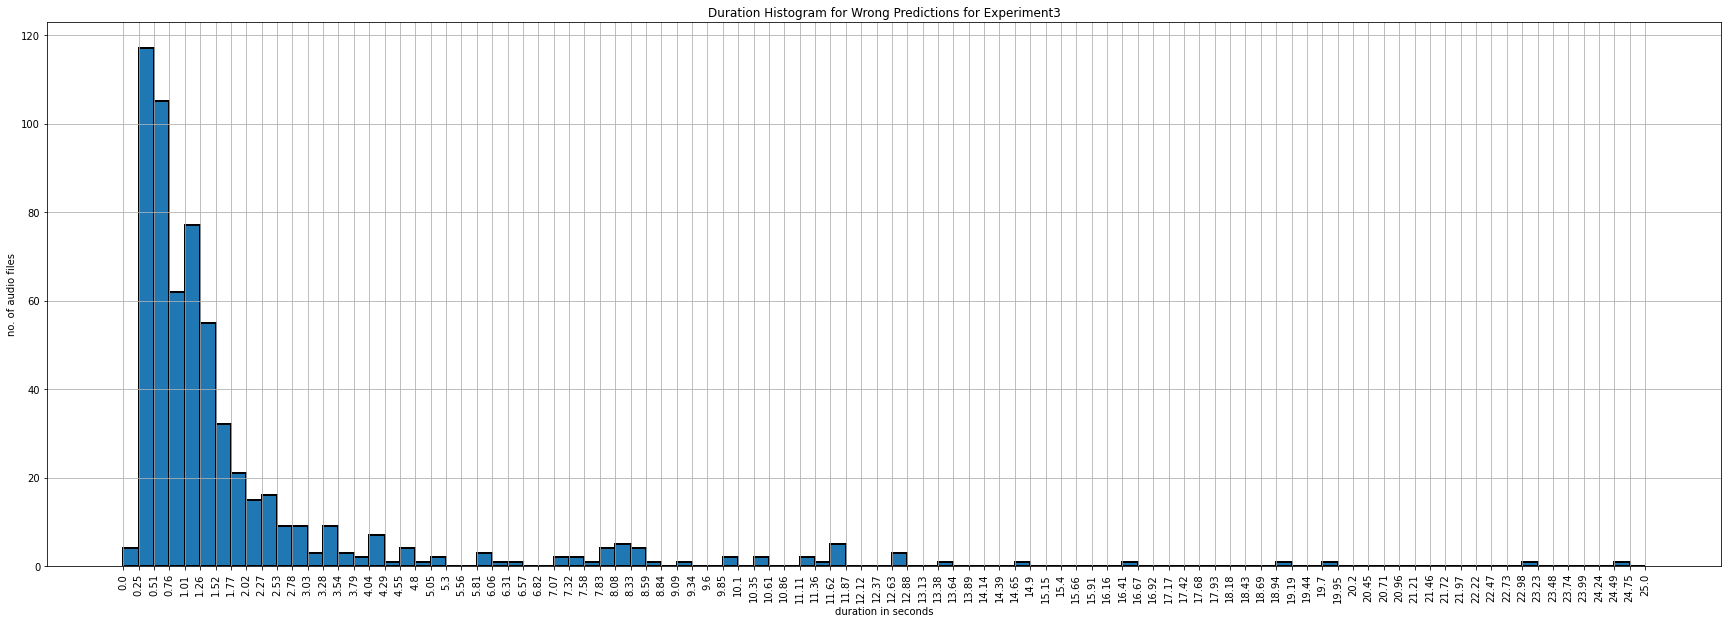

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

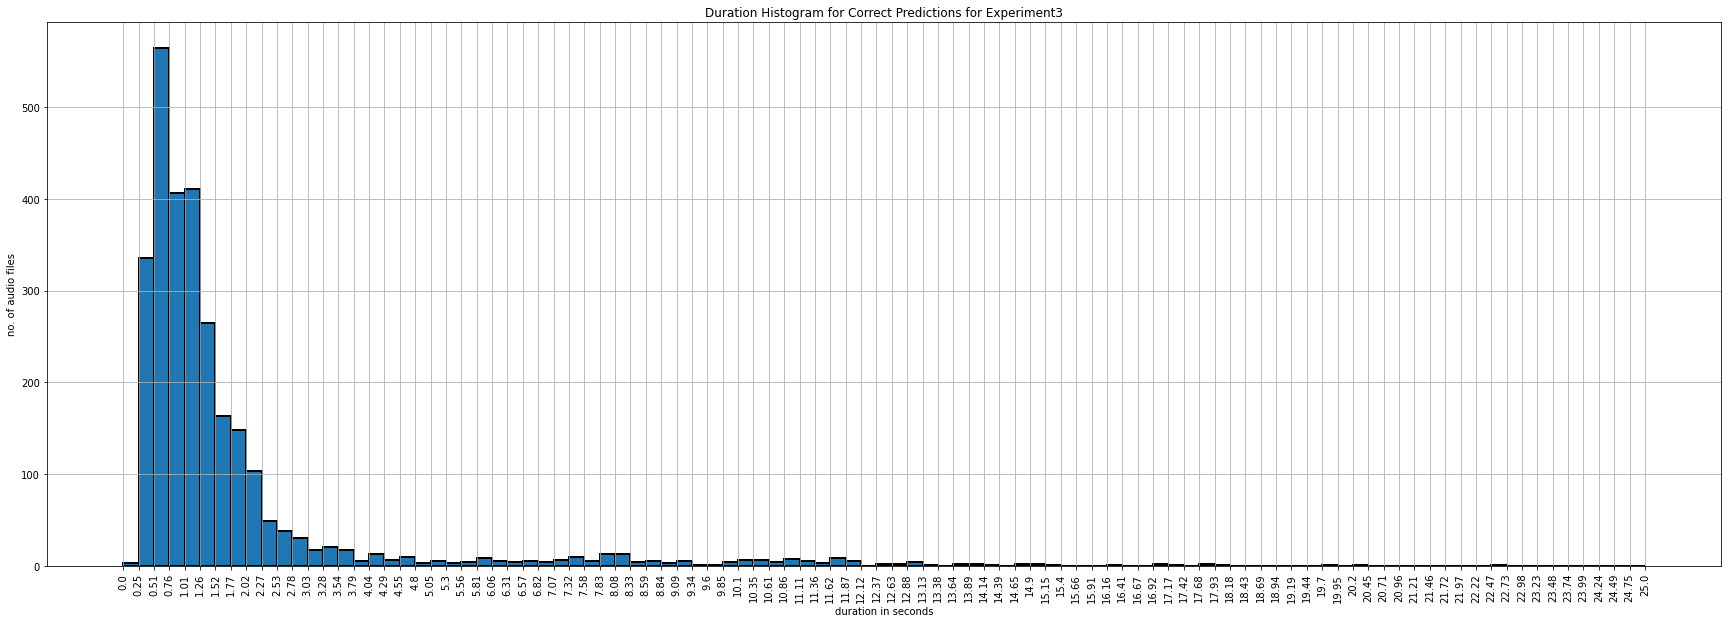

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment3

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

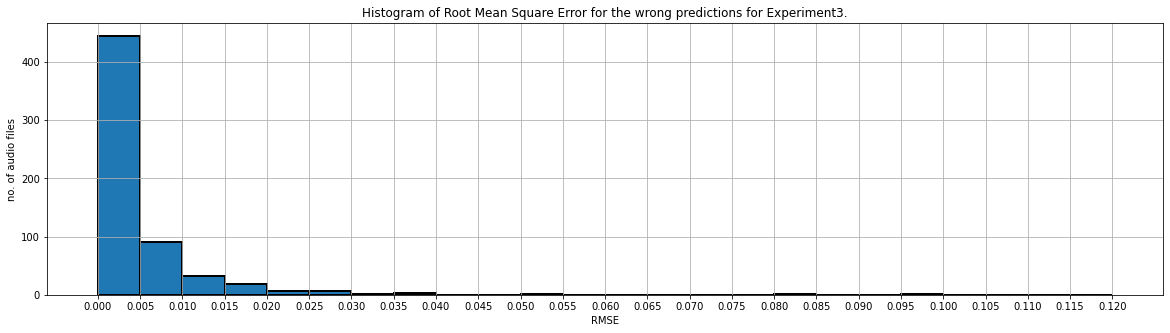

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

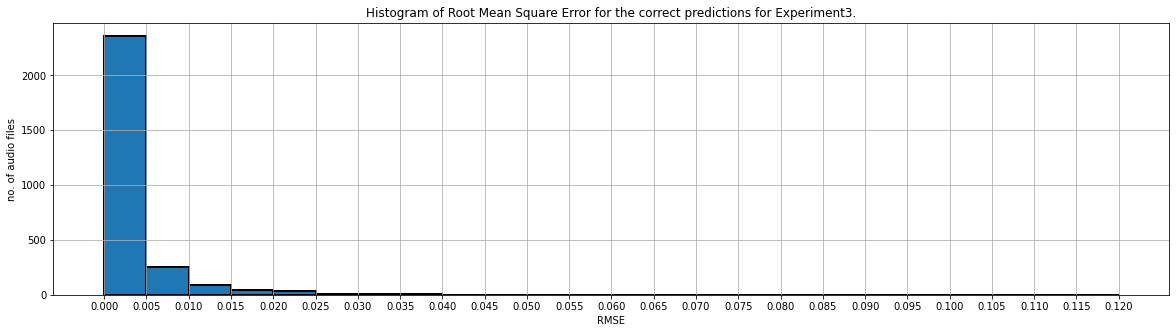

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

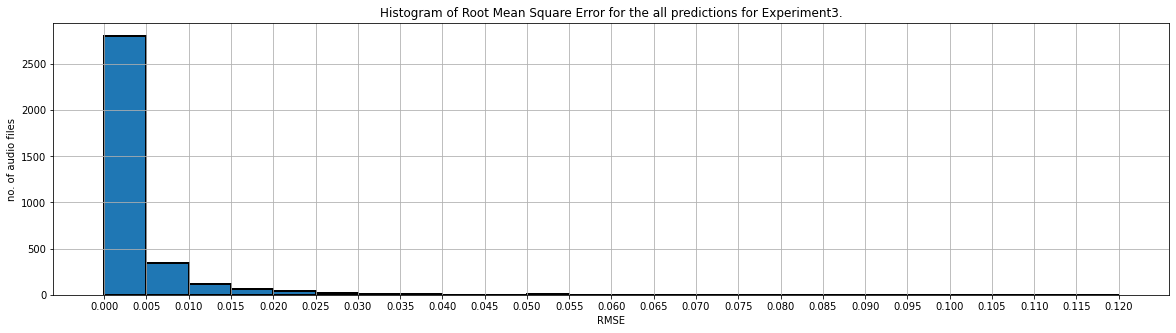

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment3

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.89 0.91 0.85 0.71 0.82 0.9  0.82 0.96 0.73 0.83 0.81 0.55 0.81 0.51
 0.81 0.91 0.64 0.88 0.82 0.8 ]
Precision:  [0.84 0.93 0.85 0.75 0.82 0.87 0.85 0.87 0.64 0.85 0.75 0.79 0.8  0.68
 0.94 0.9  0.68 0.88 0.77 0.81]
F1-Score:  [0.86 0.92 0.85 0.73 0.82 0.88 0.84 0.91 0.68 0.84 0.78 0.65 0.8  0.58
 0.87 0.9  0.66 0.88 0.79 0.8 ]
Accuracy: 0.82  , 2812
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.93      0.91      0.92       236
           2       0.85      0.85      0.85       180
           3       0.75      0.71      0.73       222
           4       0.82      0.82      0.82       212
           5       0.87      0.90      0.88       178
           6       0.85      0.82      0.84       213
           7       0.87      0.96      0.91       173
           8       0.64      0.73      0.68       220
           9       0.85      0.83      0.84       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

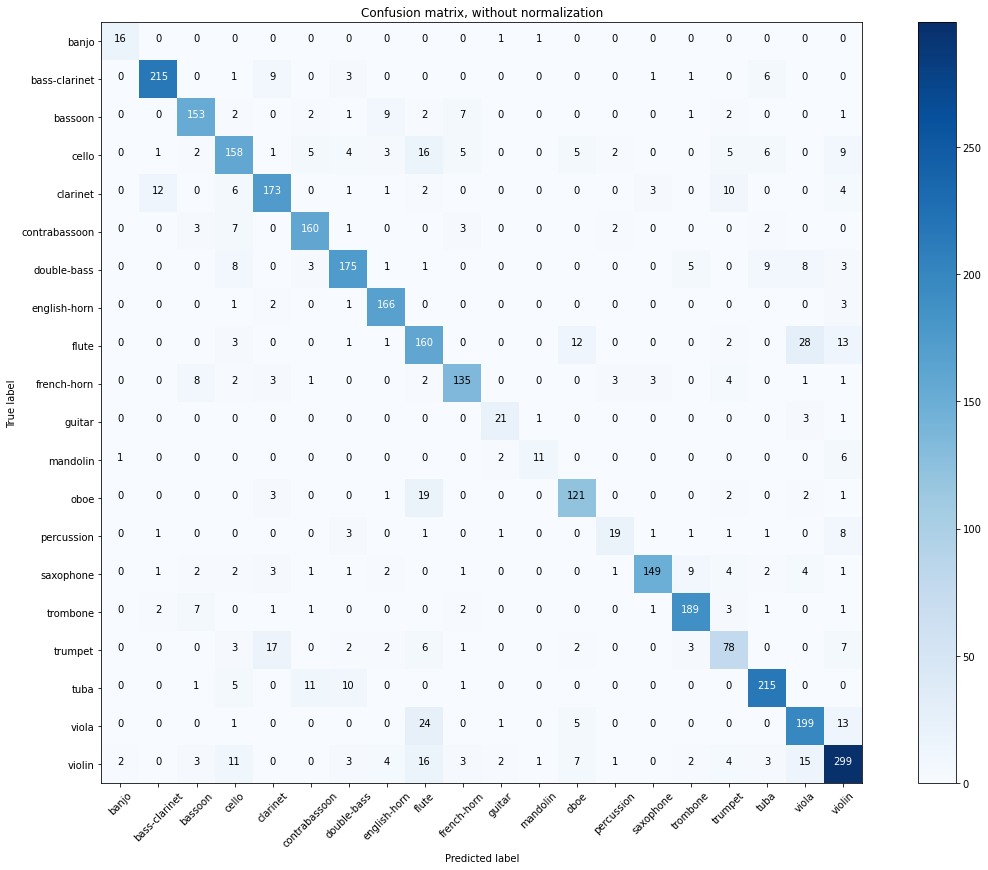

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for experiment 4**

#  load pickle file needed for plotting results for experiment 4

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment4/histexp4.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.0425



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) < value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0., dtype=float32)] viola
[array(0., dtype=float32)] cello
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] violin
[array(0., dtype=float32)] bassoon
[array(0., dtype=float32)] bassoon
[array(0., dtype=float32)] cello
[array(0., dtype=float32)] violin
[array(0., dtype=float32)] clarinet
[array(0.01, dtype=float32)] cello
[array(0., dtype=float32)] tuba
[array(0., dtype=float32)] bassoon
[array(0., dtype=float32)] french-horn
[array(0., dtype=float32)] contrabassoon
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] flute
[array(0., dtype=float32)] viola
[array(0., dtype=float32)] contrabassoon
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] saxophone
[array(0., dtype=float32)] bass-clarinet
[array(0.01, dtype=float32)] violin
[array(0., dtype=float32)] trombone
[array(0., dtype=float32)] oboe
[array(0.01, dtype=float32)] violin
[array(0., dtype=float32)] tuba
[array(0., dtype=float32)] oboe


In [ ]:
hist = hist1['hist']
total = 3421
value = 0.25



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) > value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 697 (out of 3421)
Validation correct 2724 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)


In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Bar Chart for Correct Predictions for experiment4

In [ ]:
banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[16, 218, 132, 136, 179, 152, 185, 157, 156, 132, 22, 15, 114, 16, 140, 171, 77, 223, 192, 291]


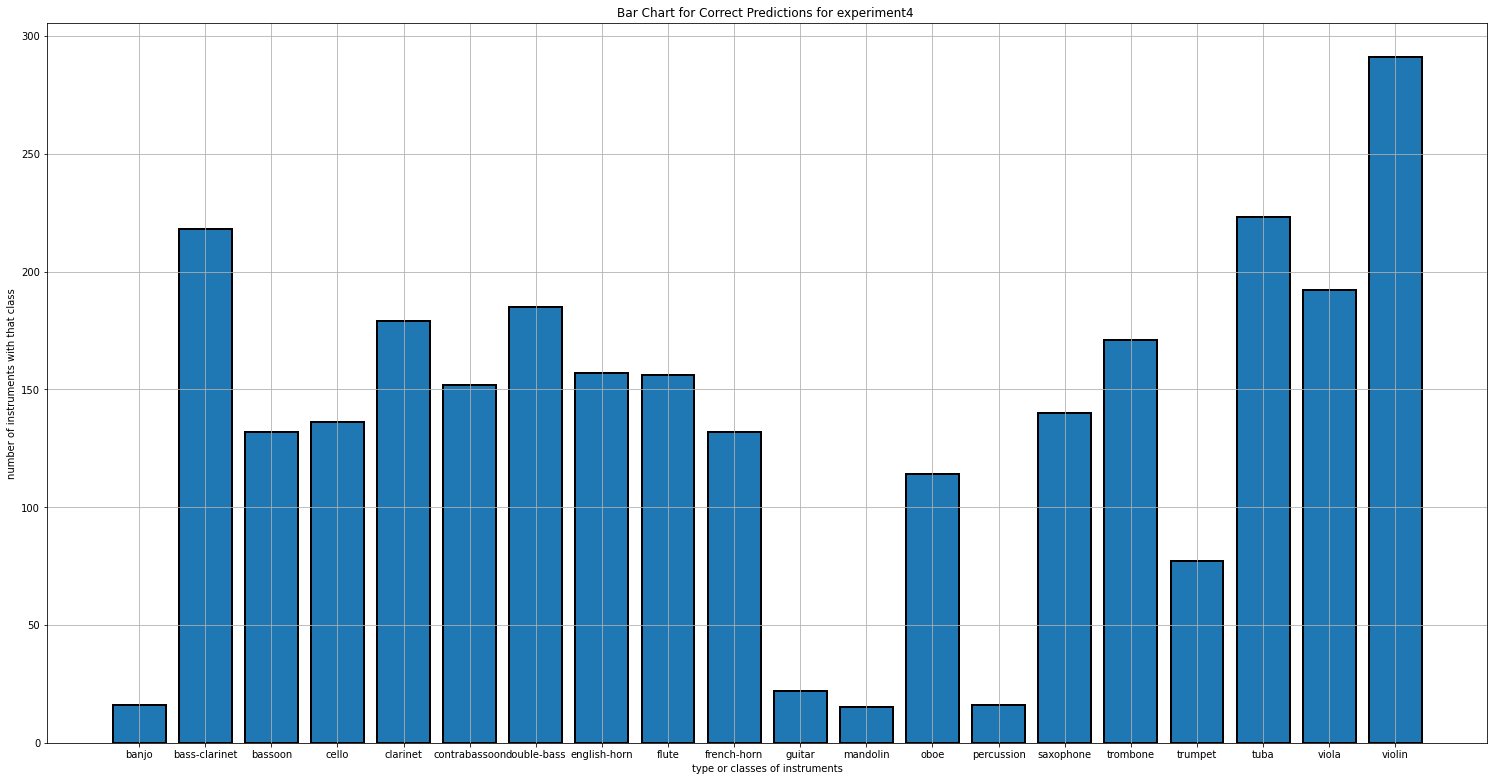

In [ ]:

fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for experiment4 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()


Bar Chart for Wrong Predictions for experiment4

In [ ]:
banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[3, 22, 50, 64, 31, 34, 33, 32, 89, 25, 2, 6, 40, 11, 28, 23, 22, 24, 73, 85]


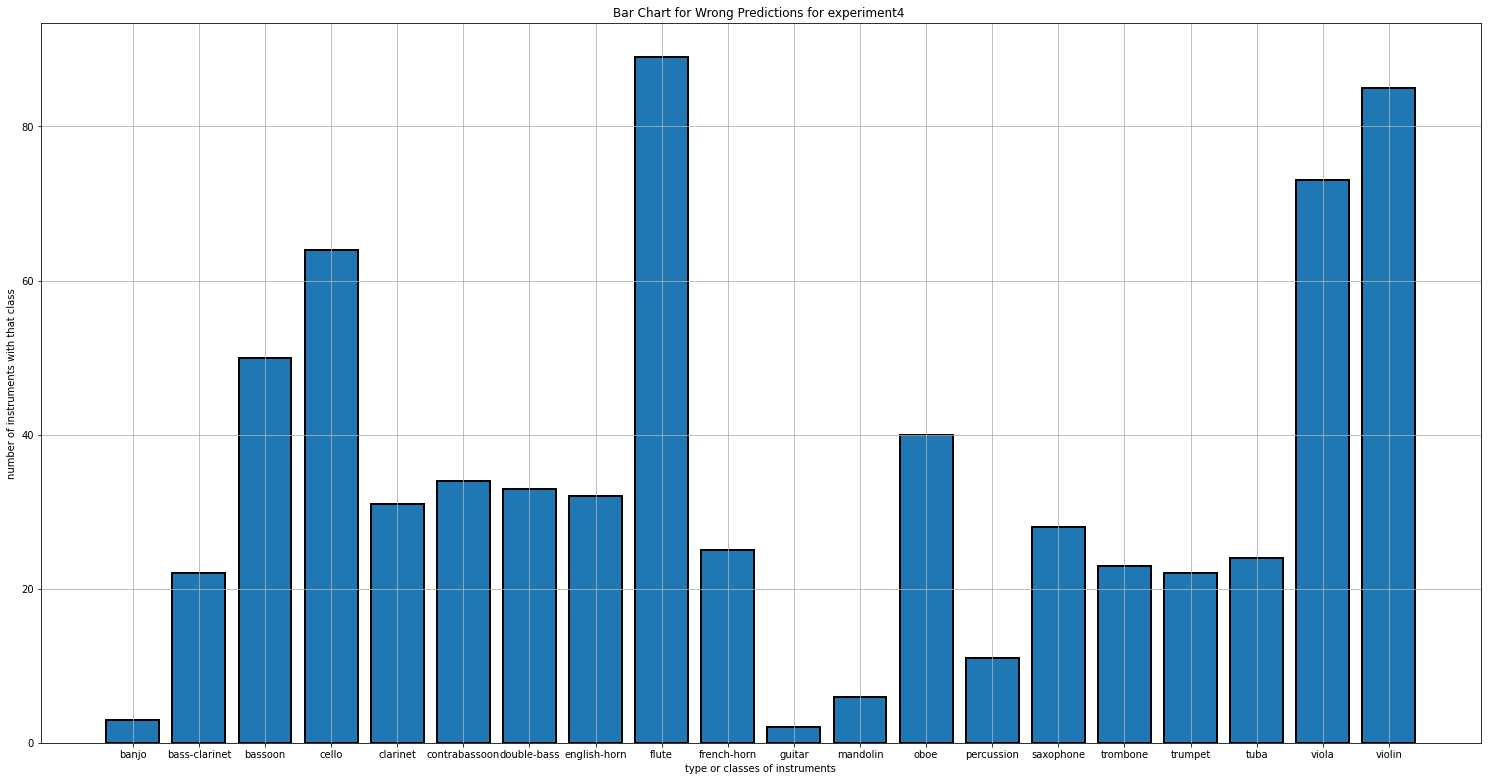

In [ ]:

fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for experiment4 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()

Grouped Bar Chart for Correct and Wrong Predictions for experiment4

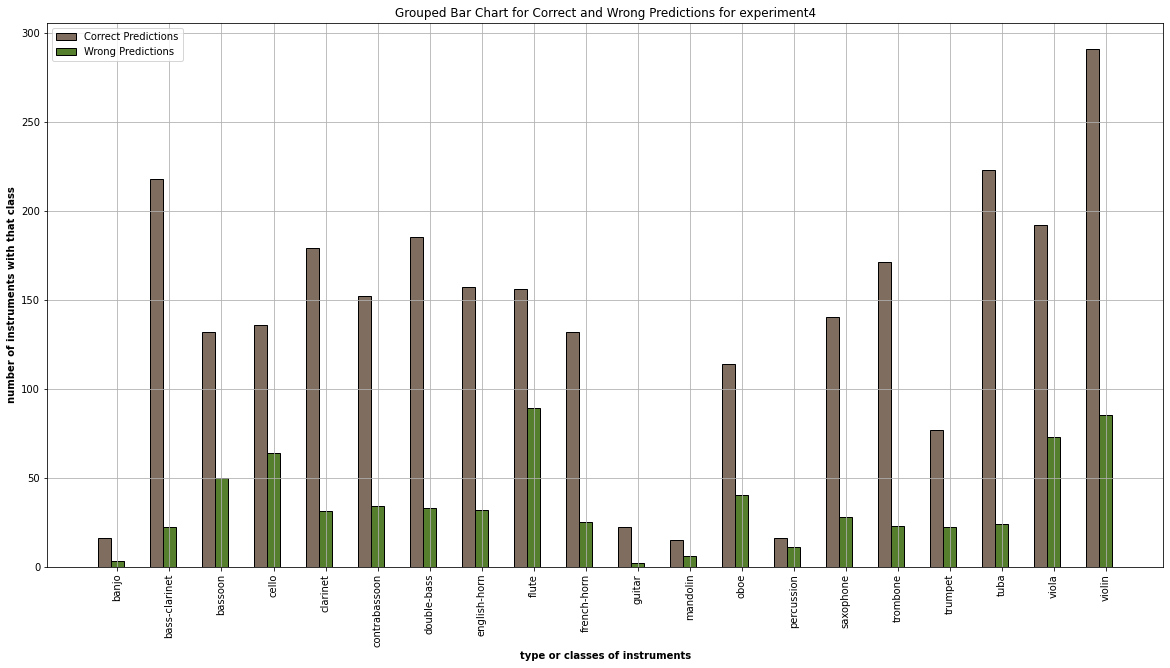

In [ ]:
# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.title('Grouped Bar Chart for Correct and Wrong Predictions for experiment4')
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
plt.grid()
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for experiment4

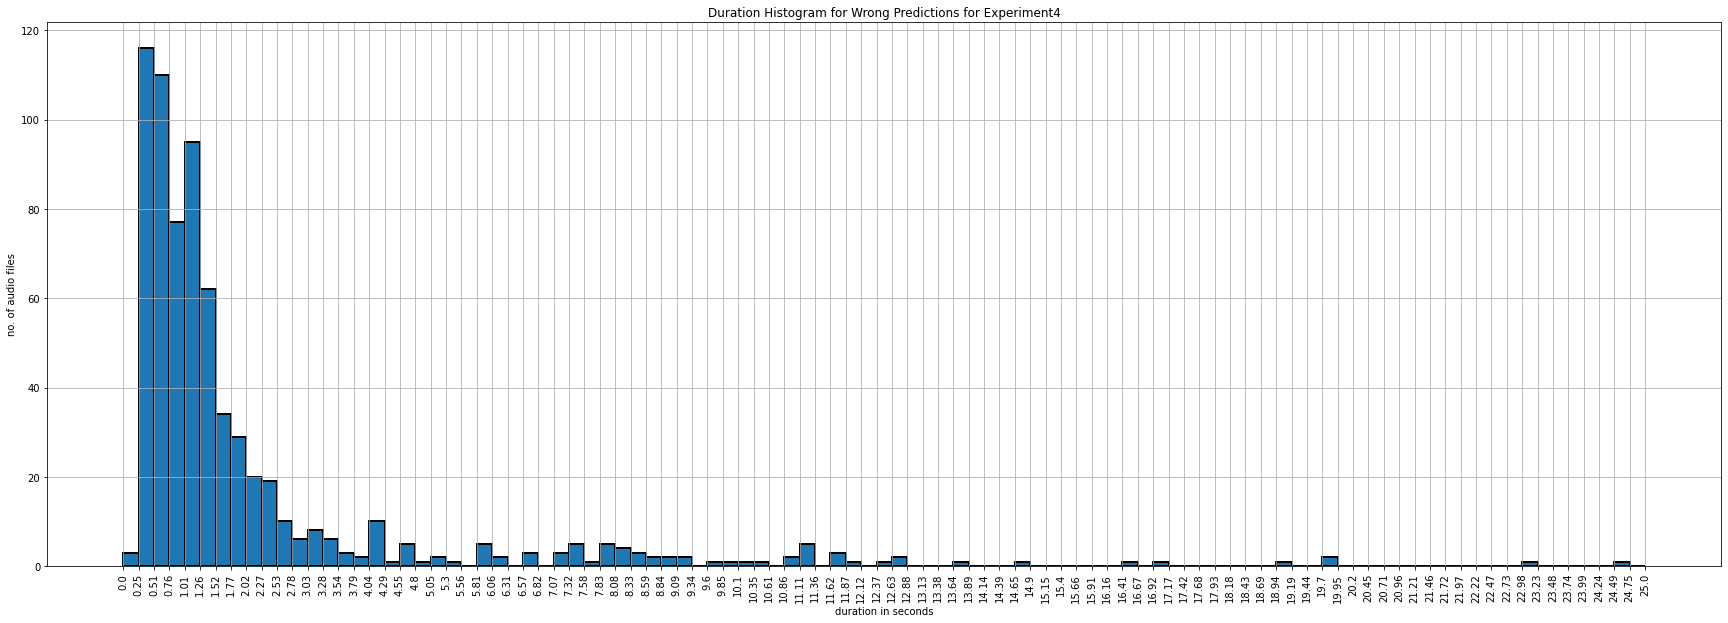

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment4")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

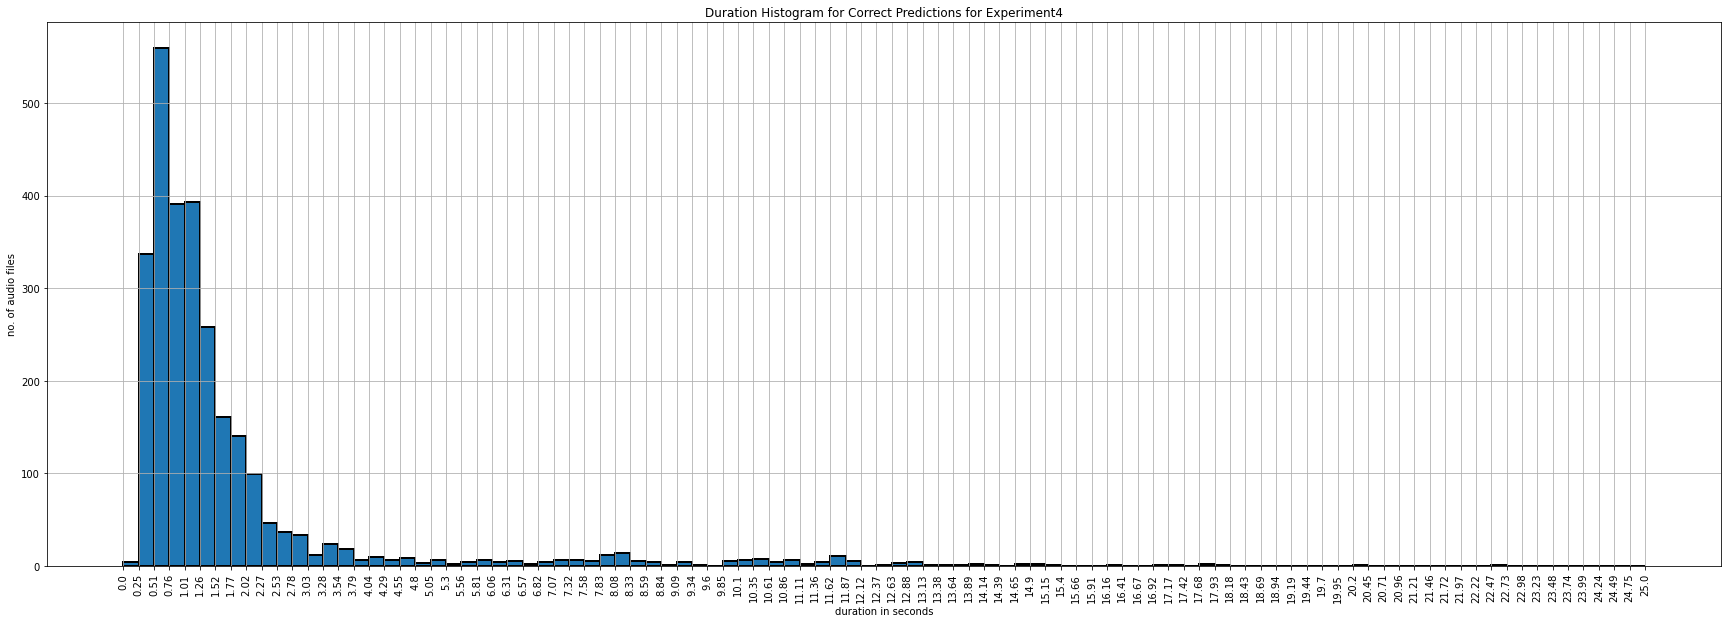

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment4")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment4

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

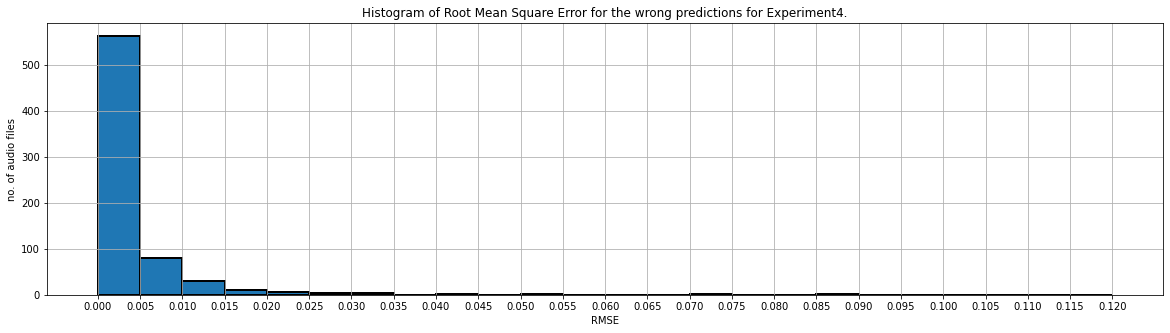

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

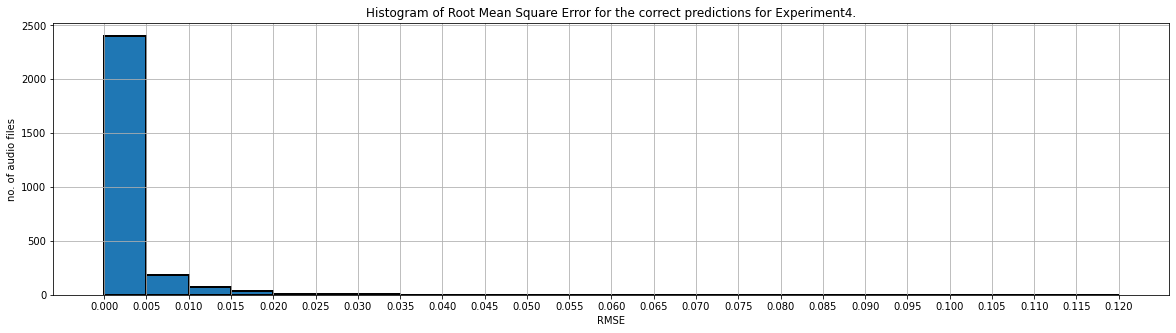

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

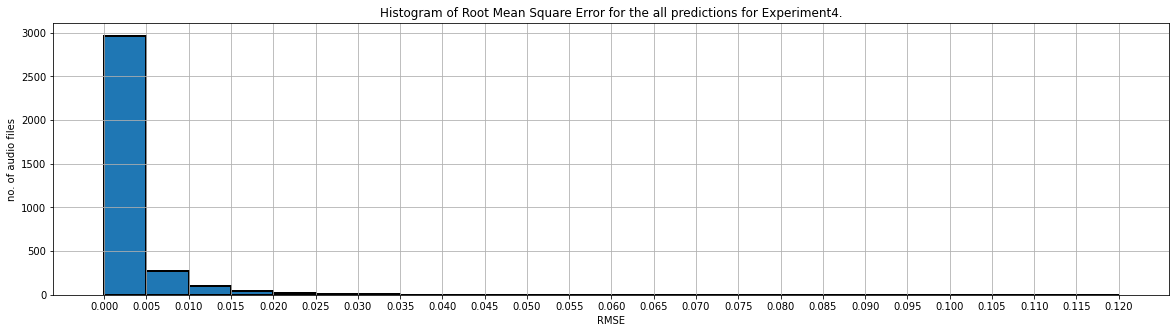

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment4

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.89 0.92 0.73 0.61 0.84 0.85 0.87 0.91 0.71 0.81 0.85 0.75 0.77 0.43
 0.77 0.82 0.64 0.92 0.79 0.77]
Precision:  [0.84 0.91 0.73 0.68 0.85 0.82 0.85 0.83 0.64 0.84 0.92 0.71 0.74 0.59
 0.83 0.88 0.78 0.9  0.72 0.77]
F1-Score:  [0.86 0.92 0.73 0.64 0.85 0.84 0.86 0.87 0.67 0.83 0.88 0.73 0.75 0.5
 0.8  0.85 0.7  0.91 0.76 0.77]
Accuracy: 0.80  , 2724
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.91      0.92      0.92       236
           2       0.73      0.73      0.73       180
           3       0.68      0.61      0.64       222
           4       0.85      0.84      0.85       212
           5       0.82      0.85      0.84       178
           6       0.85      0.87      0.86       213
           7       0.83      0.91      0.87       173
           8       0.64      0.71      0.67       220
           9       0.84      0.81      0.83       163
          10      

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

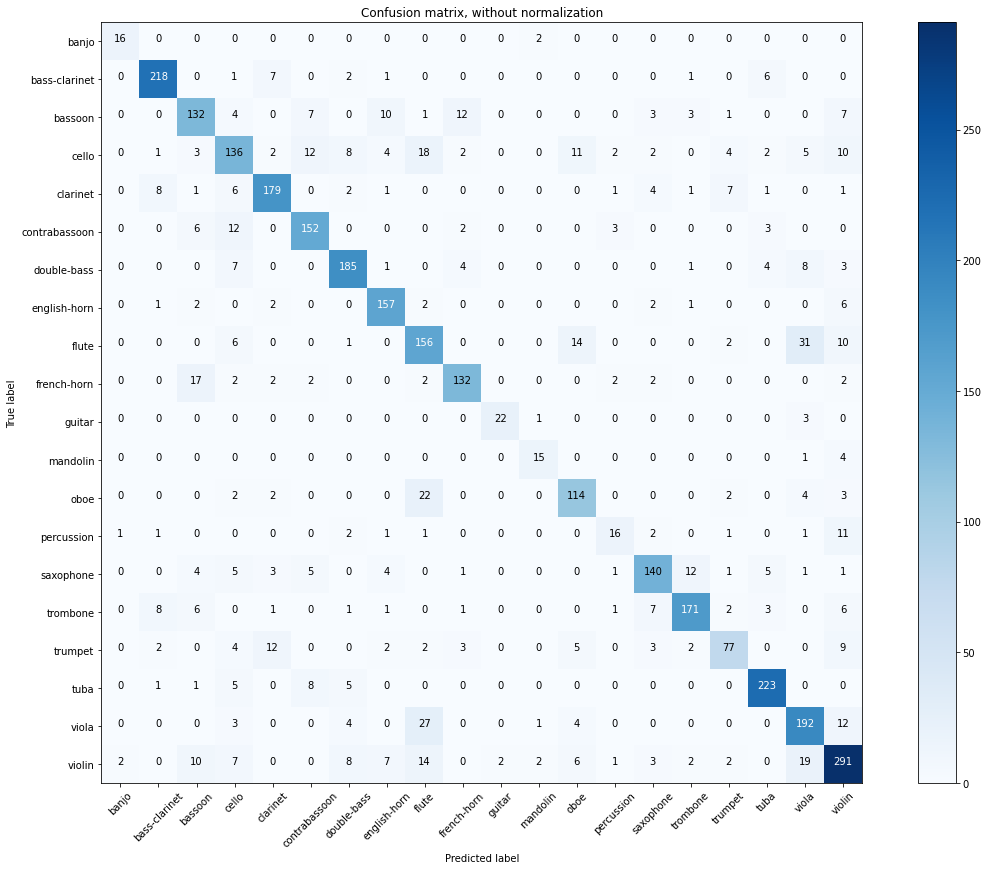

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for experiment 5**

#  load pickle file needed for plotting results for experiment 5

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment5/histexp5.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.0425



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) < value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0., dtype=float32)] viola
[array(0., dtype=float32)] cello
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] violin
[array(0., dtype=float32)] bassoon
[array(0., dtype=float32)] bassoon
[array(0., dtype=float32)] cello
[array(0., dtype=float32)] violin
[array(0., dtype=float32)] clarinet
[array(0., dtype=float32)] cello
[array(0., dtype=float32)] tuba
[array(0., dtype=float32)] bassoon
[array(0., dtype=float32)] french-horn
[array(0., dtype=float32)] contrabassoon
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] flute
[array(0., dtype=float32)] viola
[array(0., dtype=float32)] contrabassoon
[array(0., dtype=float32)] double-bass
[array(0., dtype=float32)] saxophone
[array(0., dtype=float32)] bass-clarinet
[array(0.01, dtype=float32)] violin
[array(0., dtype=float32)] trombone
[array(0., dtype=float32)] oboe
[array(0.01, dtype=float32)] violin
[array(0., dtype=float32)] tuba
[array(0., dtype=float32)] oboe
[a

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.25



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) > value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 807 (out of 3421)
Validation correct 2614 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3418, 3419, 3420]),)


In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))



Bar Chart for Correct Predictions for experiment5

In [ ]:

banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[15, 211, 149, 124, 178, 136, 169, 157, 139, 125, 22, 14, 125, 20, 114, 178, 64, 212, 173, 289]


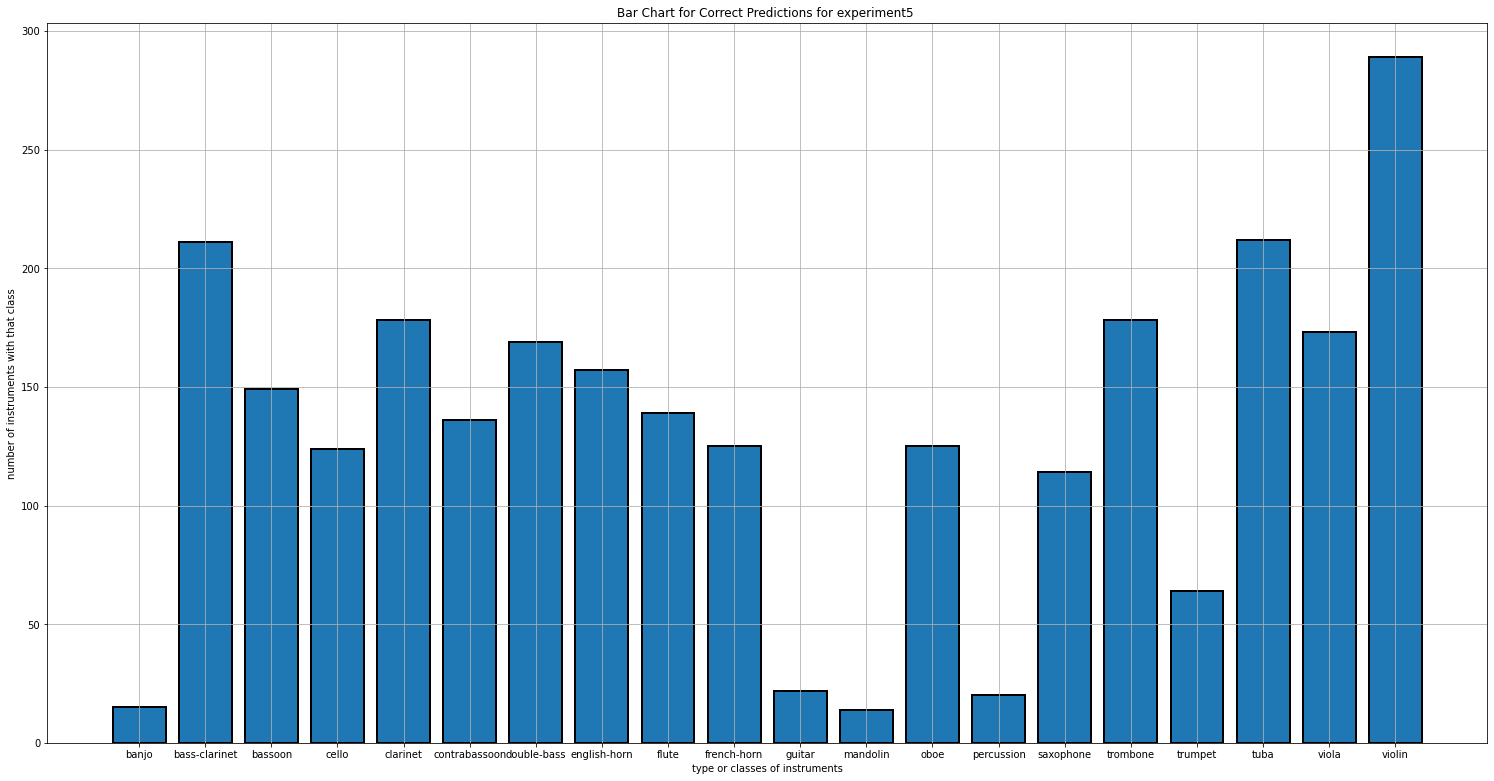

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for experiment5 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()

Bar Chart for Wrong Predictions for experiment5

In [ ]:
banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[1, 17, 74, 79, 47, 44, 42, 20, 80, 35, 2, 6, 41, 7, 35, 37, 21, 34, 77, 108]


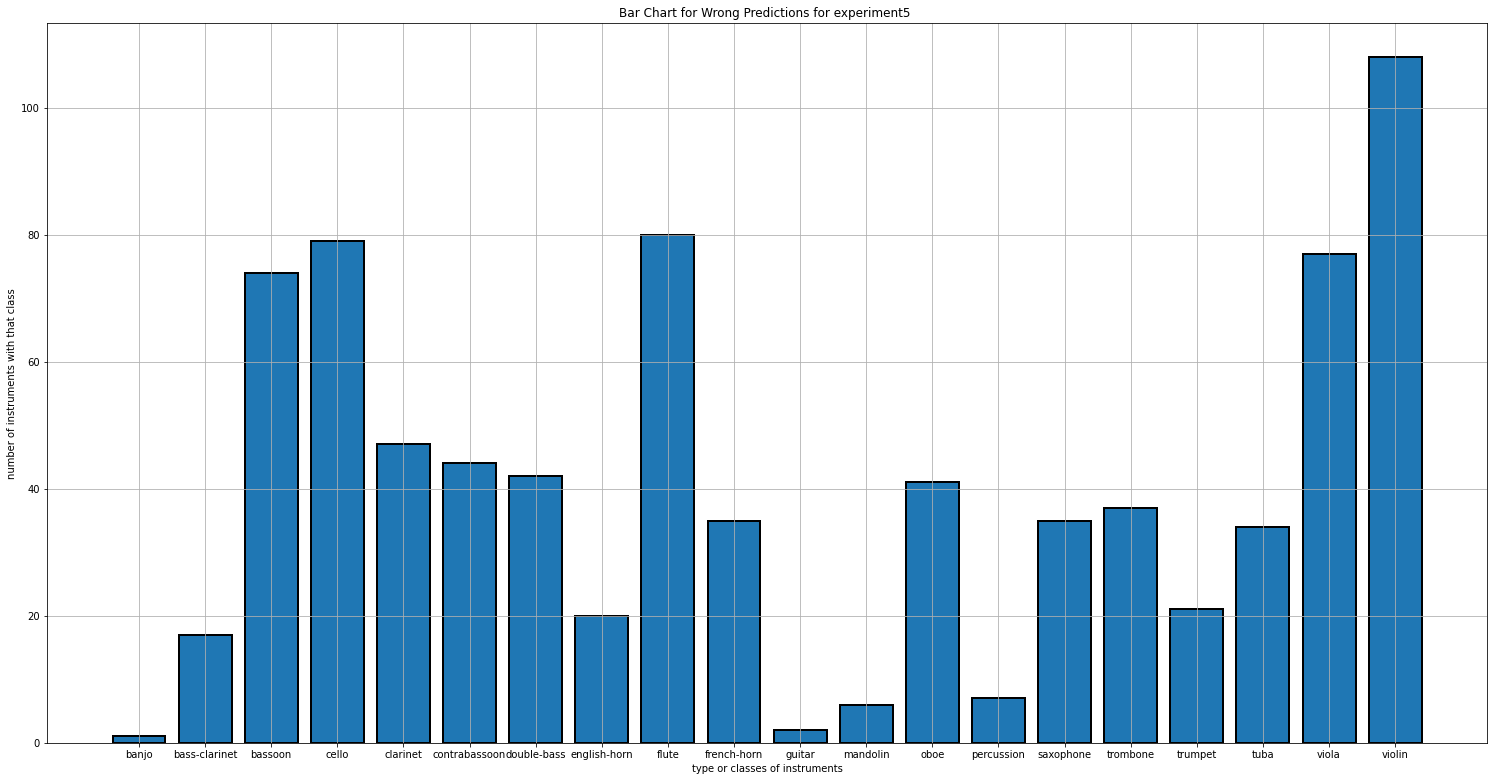

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for experiment5 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()


Grouped Bar Chart for Correct and Wrong Predictions for experiment5

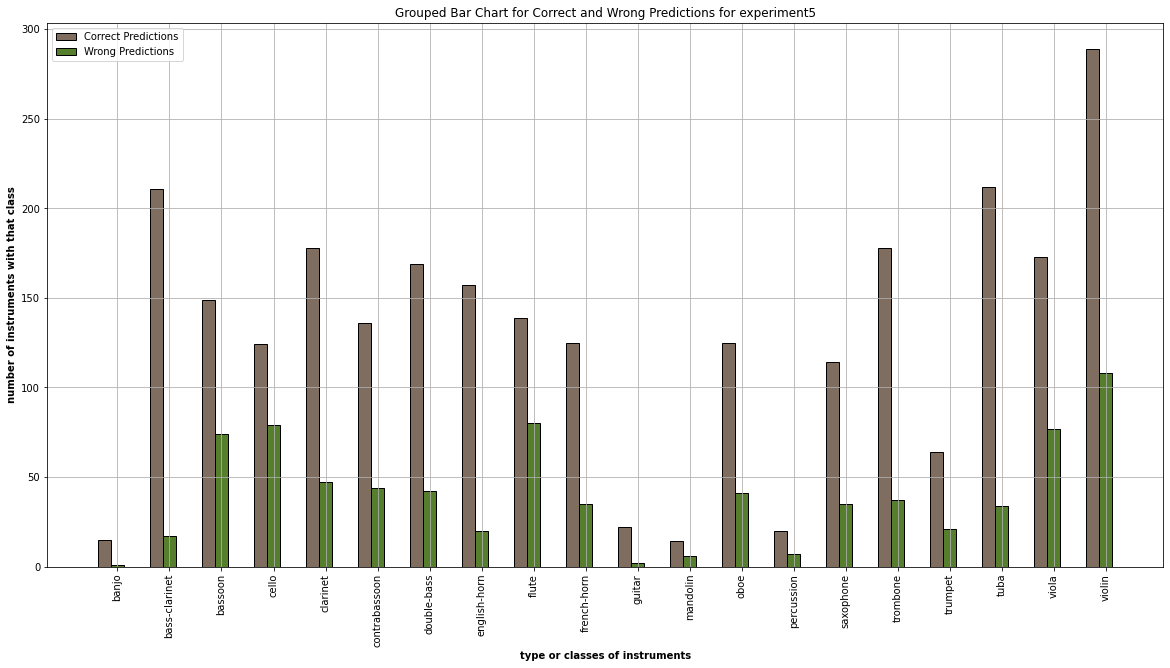

In [ ]:

# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.title('Grouped Bar Chart for Correct and Wrong Predictions for experiment5')
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
plt.grid()
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for experiment5

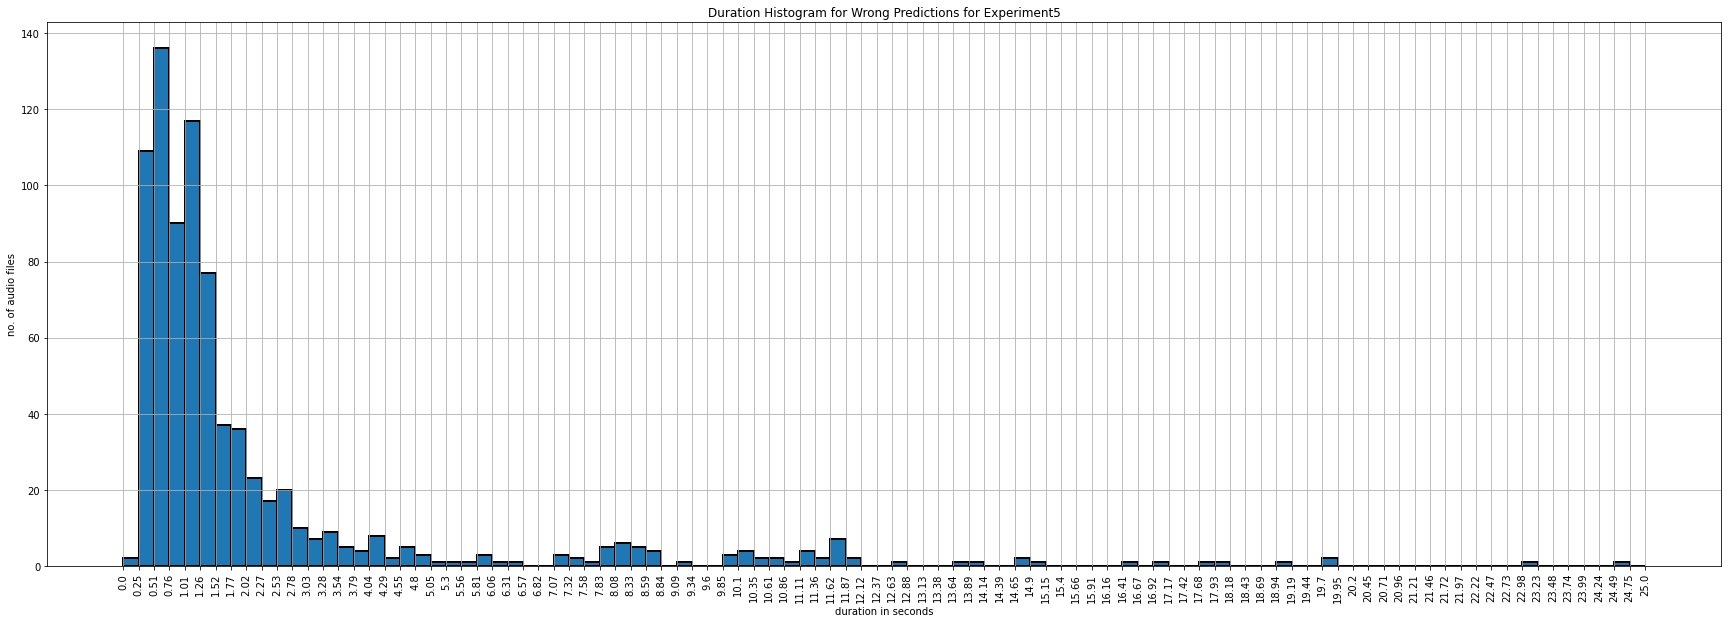

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experiment5")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

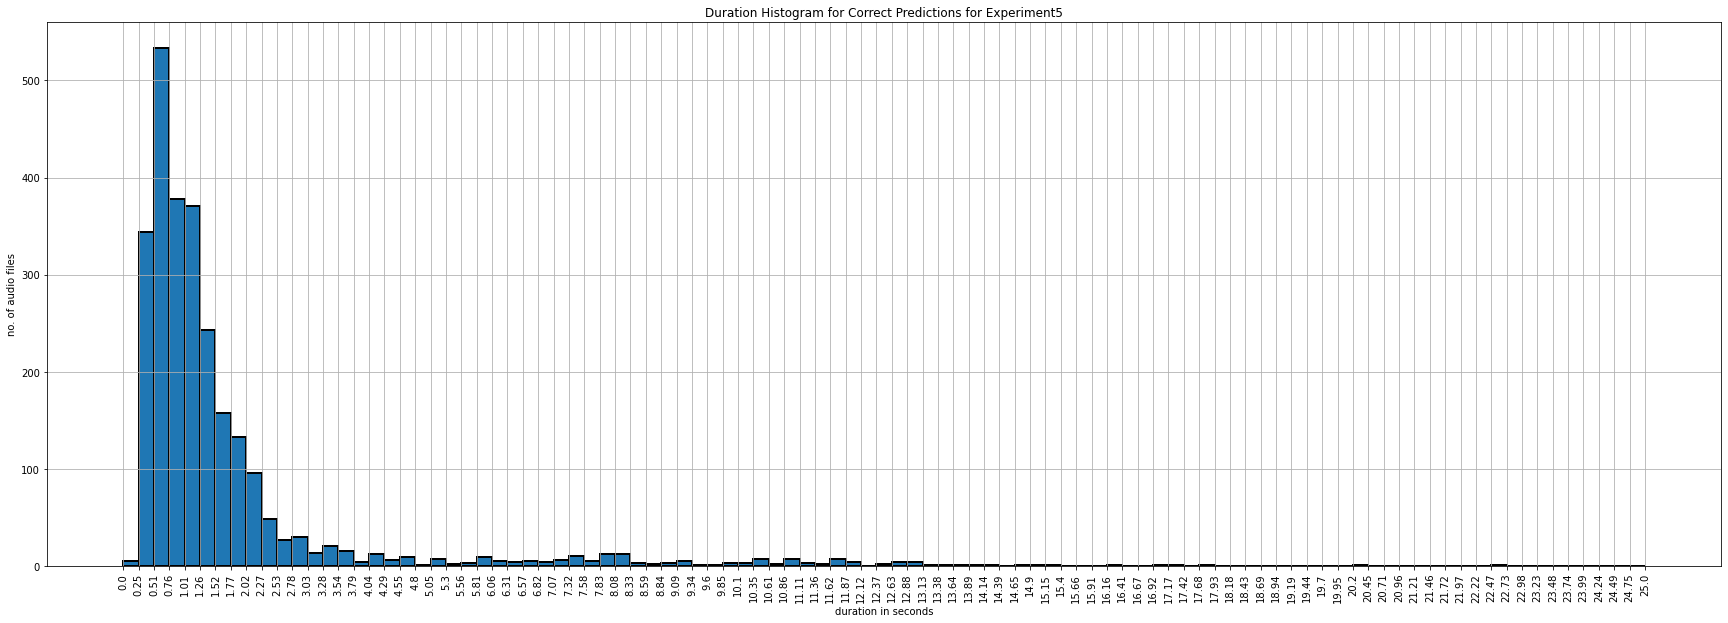

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experiment5")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment5

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

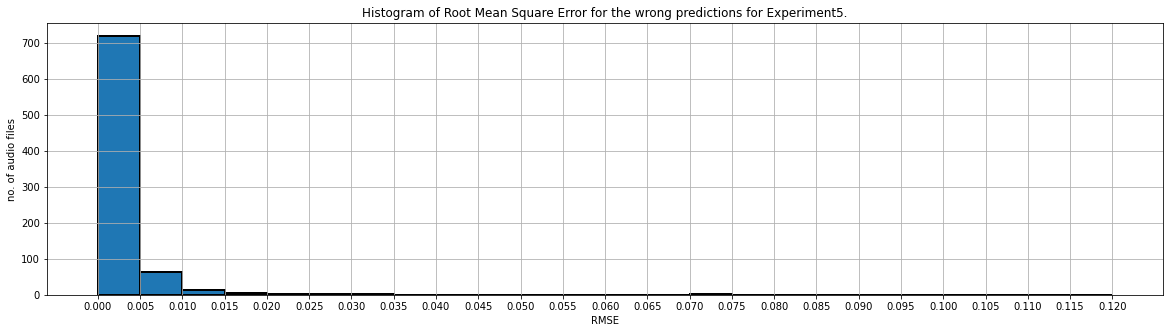

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

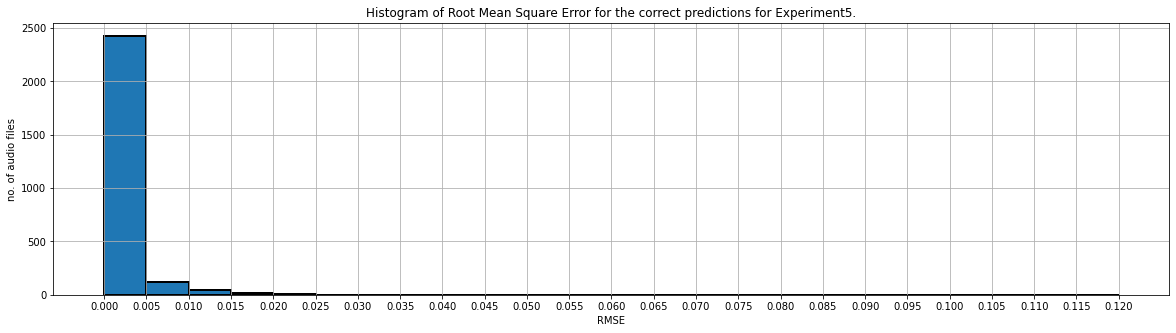

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

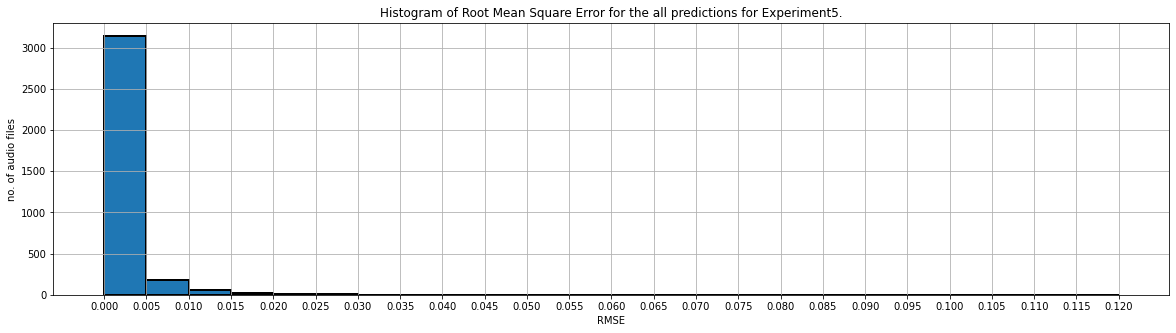

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment5

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83 0.89 0.83 0.56 0.84 0.76 0.79 0.91 0.63 0.77 0.85 0.7  0.84 0.54
 0.62 0.86 0.53 0.87 0.71 0.77]
Precision:  [0.94 0.93 0.67 0.61 0.79 0.76 0.8  0.89 0.63 0.78 0.92 0.7  0.75 0.74
 0.77 0.83 0.75 0.86 0.69 0.73]
F1-Score:  [0.88 0.91 0.74 0.58 0.81 0.76 0.8  0.9  0.63 0.77 0.88 0.7  0.79 0.62
 0.69 0.84 0.62 0.87 0.7  0.75]
Accuracy: 0.76  , 2614
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.93      0.89      0.91       236
           2       0.67      0.83      0.74       180
           3       0.61      0.56      0.58       222
           4       0.79      0.84      0.81       212
           5       0.76      0.76      0.76       178
           6       0.80      0.79      0.80       213
           7       0.89      0.91      0.90       173
           8       0.63      0.63      0.63       220
           9       0.78      0.77      0.77       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

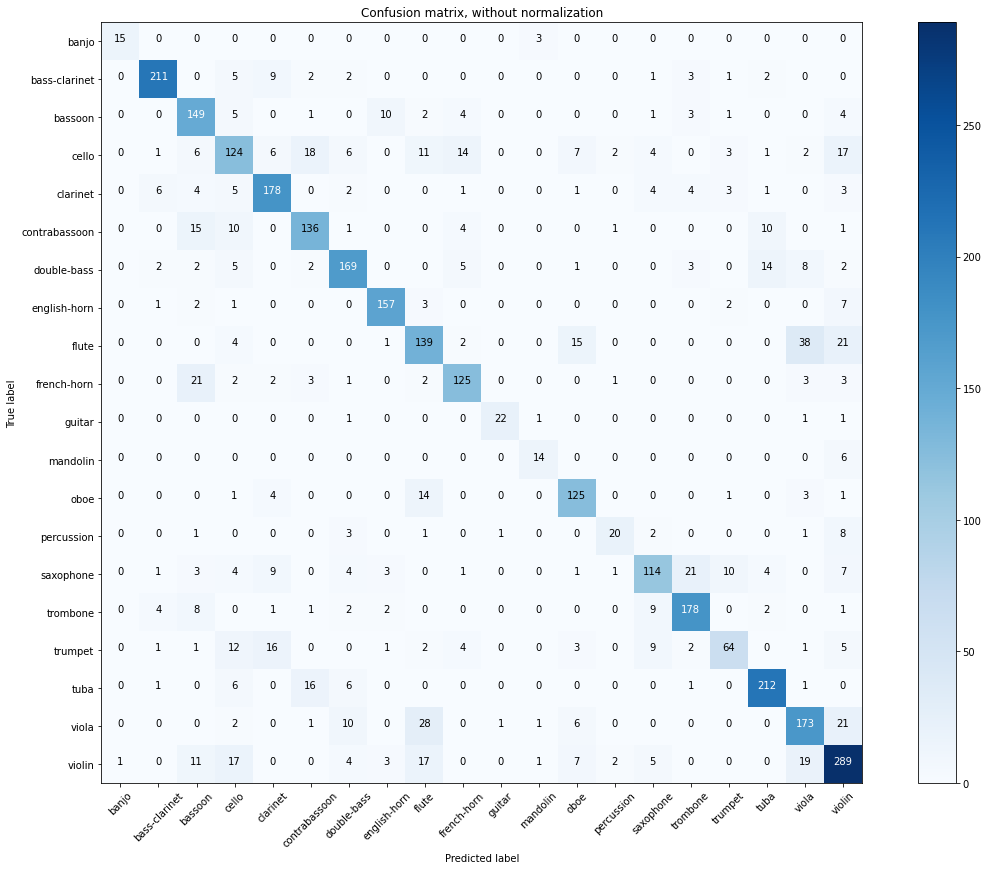

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for Variational Autoencoder experiment 2**

#  load pickle file needed for plotting results for Variational Autoencoder experiment 2

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/VarAutoEncoderExperiment2/histVarAutoEncexp2.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.0425



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) < value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.03367769, dtype=float32)] banjo
[array(0.03802676, dtype=float32)] banjo
[array(0.03666113, dtype=float32)] violin
[array(0.03072394, dtype=float32)] banjo
[array(0.04206216, dtype=float32)] percussion
[array(0.04046233, dtype=float32)] viola
[array(0.04161839, dtype=float32)] percussion
[array(0.03774839, dtype=float32)] banjo
[array(0.03526901, dtype=float32)] banjo
[array(0.03782571, dtype=float32)] saxophone
[array(0.03970239, dtype=float32)] percussion
[array(0.04004417, dtype=float32)] banjo
[array(0.02647071, dtype=float32)] banjo
[array(0.03537123, dtype=float32)] banjo
[array(0.03347755, dtype=float32)] banjo
[array(0.03912046, dtype=float32)] violin
[array(0.03152205, dtype=float32)] banjo
[array(0.03276272, dtype=float32)] percussion
[array(0.0394241, dtype=float32)] percussion
[array(0.03447795, dtype=float32)] violin
[array(0.03943324, dtype=float32)] banjo
[array(0.04211602, dtype=float32)] banjo
[array(0.03930602, dtype=float32)] banjo
[array(0.04130344, dtype=f

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.25



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) > value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.26013234, dtype=float32)] flute
[array(0.30872813, dtype=float32)] oboe
[array(0.3050858, dtype=float32)] flute
[array(0.2692744, dtype=float32)] violin
[array(0.26281536, dtype=float32)] flute
[array(0.28461754, dtype=float32)] violin
[array(0.29527655, dtype=float32)] flute
[array(0.30245477, dtype=float32)] clarinet
[array(0.2591913, dtype=float32)] flute
[array(0.3236712, dtype=float32)] flute
[array(0.26181978, dtype=float32)] clarinet
[array(0.25941816, dtype=float32)] clarinet
[array(0.26561424, dtype=float32)] flute
[array(0.30712977, dtype=float32)] flute
[array(0.2960807, dtype=float32)] trumpet
[array(0.28676376, dtype=float32)] flute
[array(0.26157036, dtype=float32)] violin
[array(0.25515595, dtype=float32)] english-horn
[array(0.30782652, dtype=float32)] clarinet
[array(0.2534661, dtype=float32)] clarinet
[array(0.2911107, dtype=float32)] clarinet
[array(0.29430705, dtype=float32)] flute
[array(0.25693235, dtype=float32)] oboe
[array(0.28412464, dtype=float32)] v

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 792 (out of 3421)
Validation correct 2629 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)
[array(0.07261877, dtype=float32)]


In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Bar Chart for Correct Predictions for Variational Autoencoder experiment 2

In [ ]:

banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[15, 203, 139, 136, 166, 150, 169, 162, 152, 114, 20, 8, 109, 22, 145, 179, 84, 214, 175, 267]


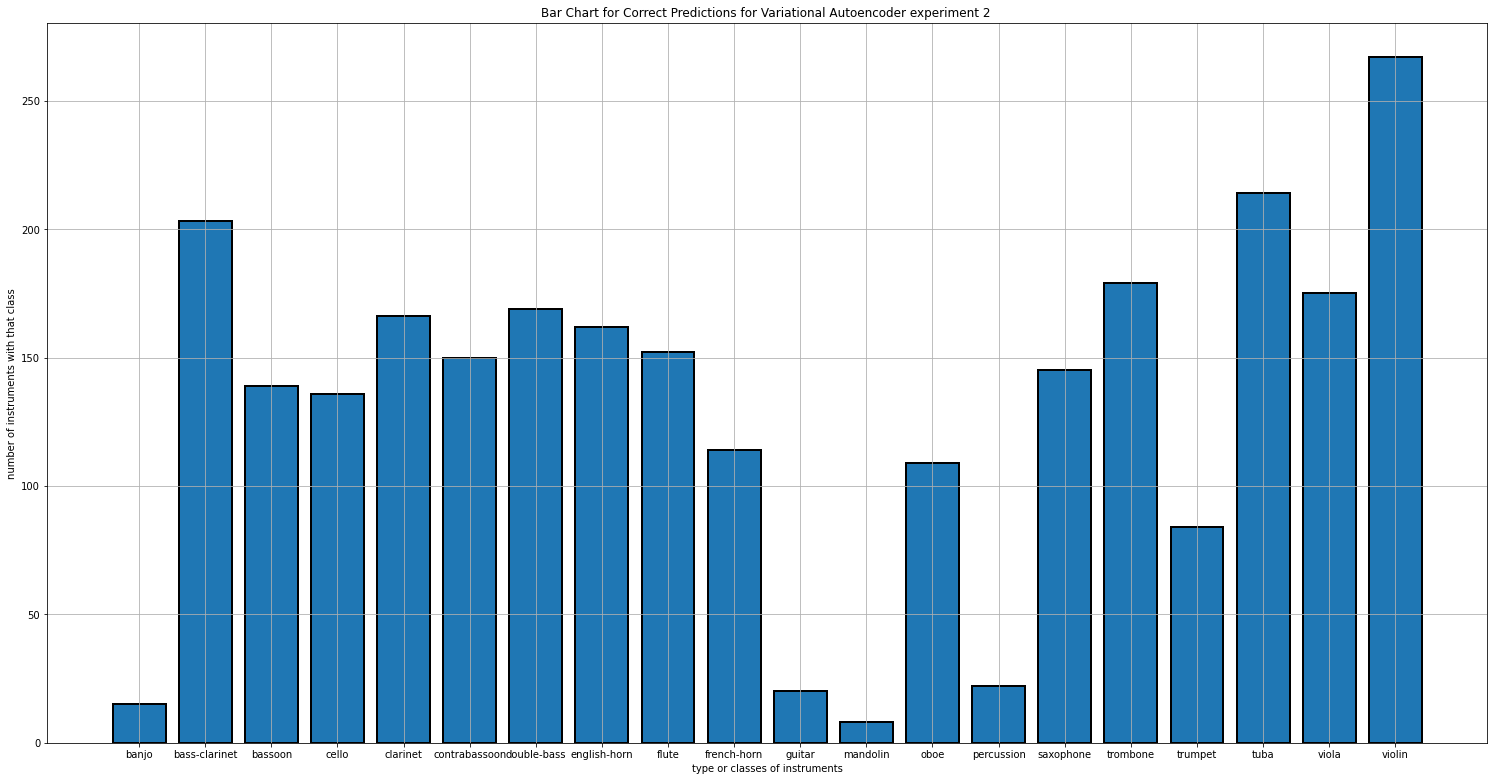

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for Variational Autoencoder experiment 2 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()


Bar Chart for Wrong Predictions for Variational Autoencoder experiment 2

In [ ]:
banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[3, 35, 47, 56, 45, 21, 34, 30, 90, 46, 10, 10, 44, 14, 18, 31, 38, 46, 89, 85]


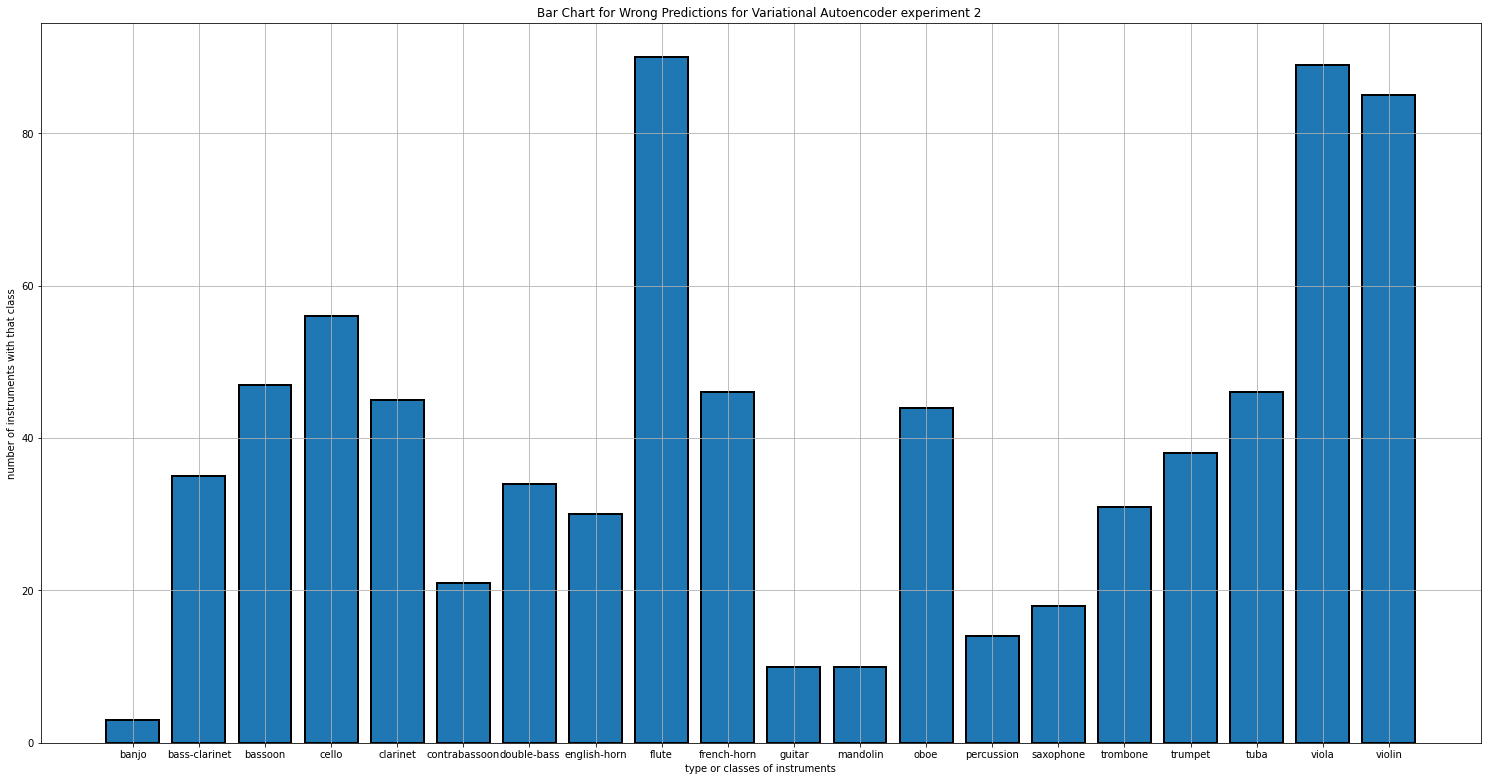

In [ ]:

fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for Variational Autoencoder experiment 2 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()


Grouped Bar Chart for Correct and Wrong Predictions for Variational Autoencoder experiment 2

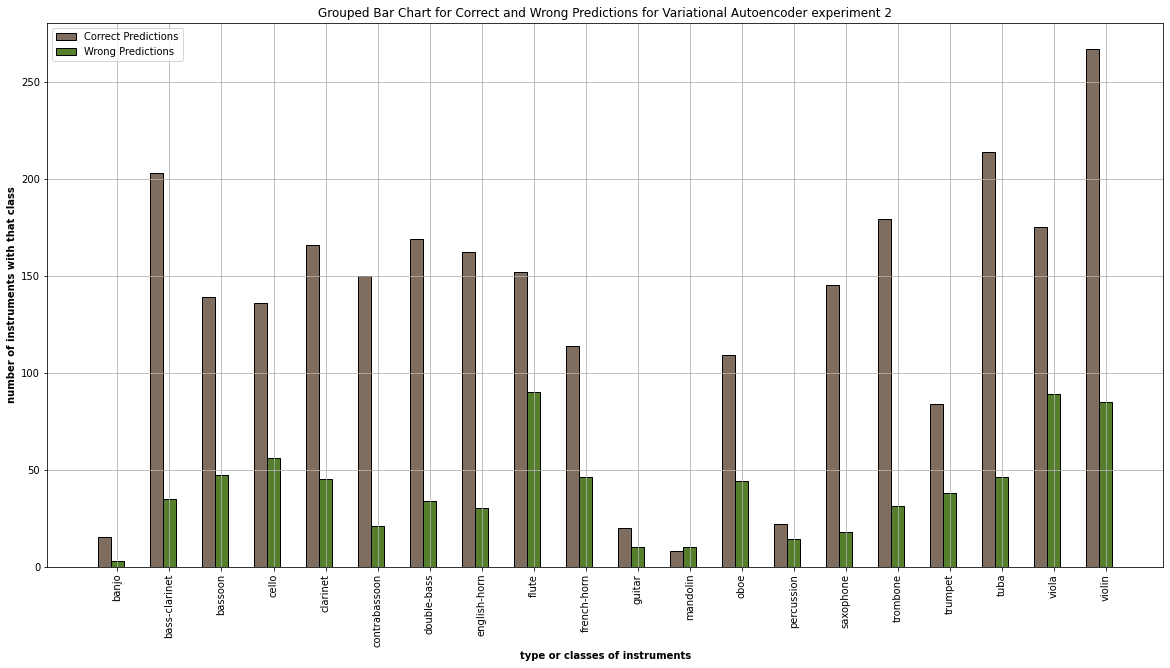

In [ ]:
# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.title('Grouped Bar Chart for Correct and Wrong Predictions for Variational Autoencoder experiment 2')
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
plt.grid()
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for Variational Autoencoder experiment 2

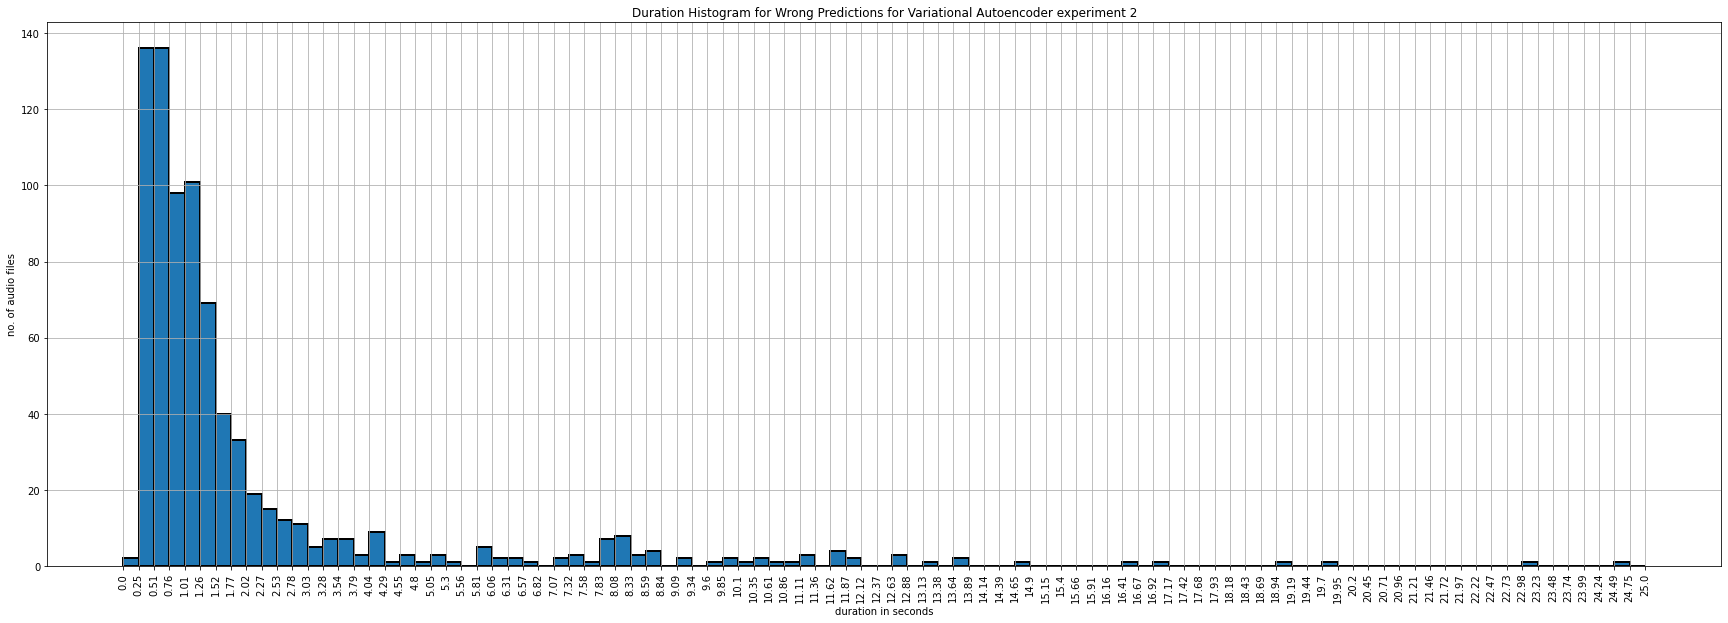

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Variational Autoencoder experiment 2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

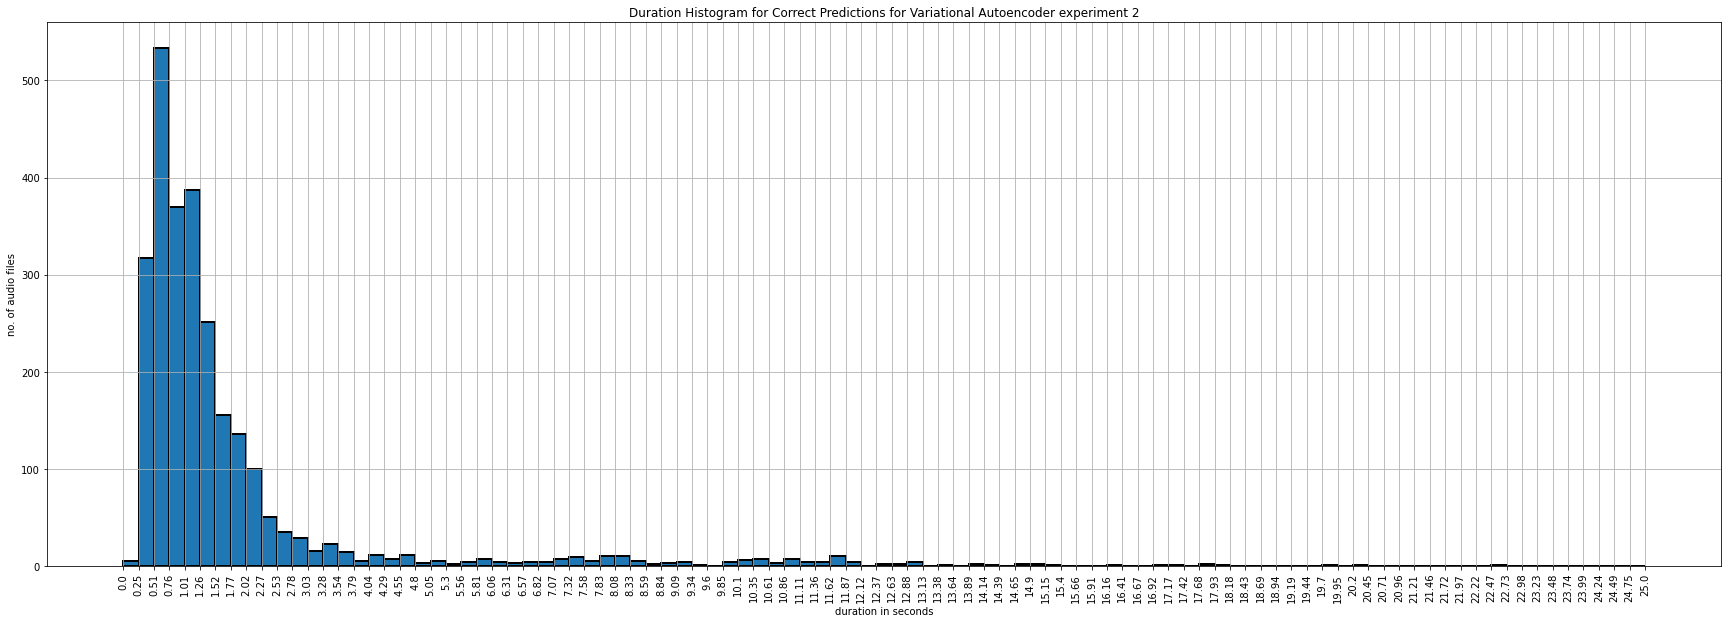

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Variational Autoencoder experiment 2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for Variational Autoencoder experiment 2

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.3400, num=25)

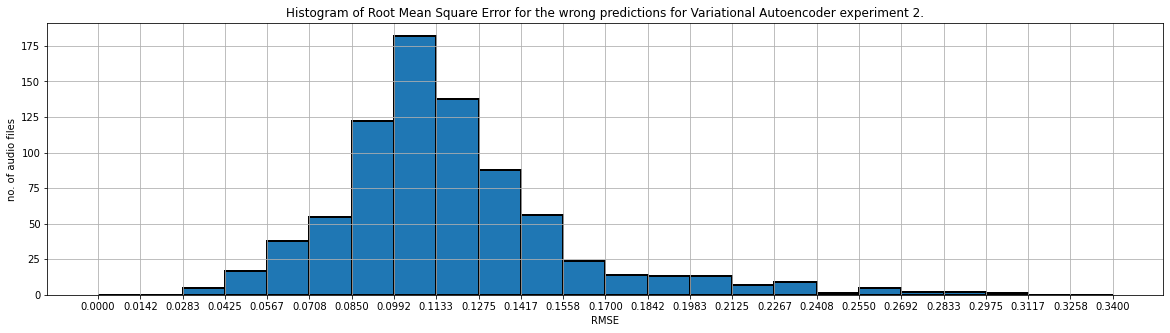

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Variational Autoencoder experiment 2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

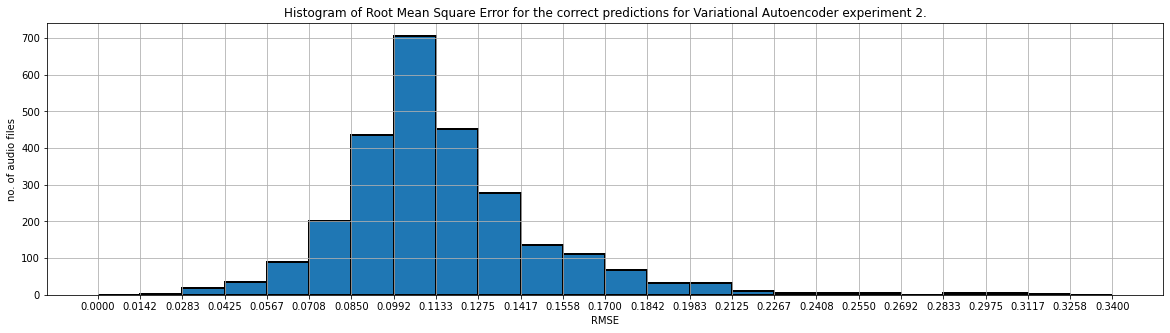

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Variational Autoencoder experiment 2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

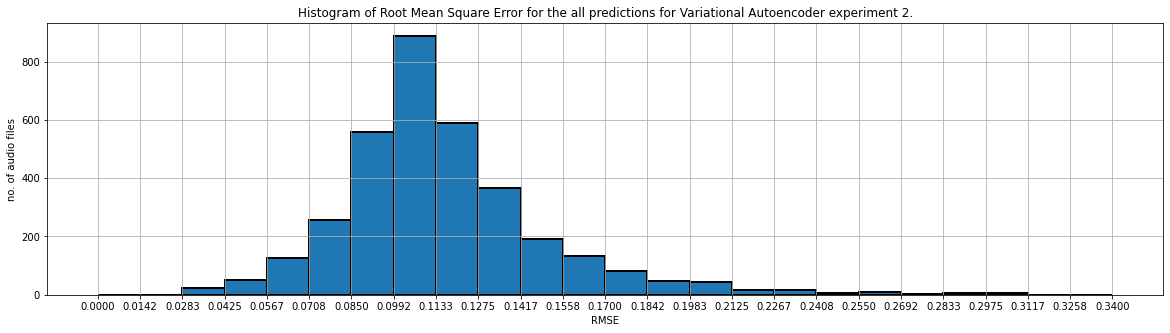

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Variational Autoencoder experiment 2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Variational Autoencoder experiment 2

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83333333 0.86016949 0.77222222 0.61261261 0.78301887 0.84269663
 0.79342723 0.93641618 0.69090909 0.6993865  0.76923077 0.4
 0.73154362 0.59459459 0.79234973 0.86057692 0.69421488 0.88065844
 0.72016461 0.71010638]
Precision:  [0.83333333 0.85294118 0.74731183 0.70833333 0.78672986 0.87719298
 0.83251232 0.84375    0.62809917 0.7125     0.66666667 0.44444444
 0.7124183  0.61111111 0.88957055 0.85238095 0.68852459 0.82307692
 0.66287879 0.75852273]
F1-Score:  [0.83333333 0.85654008 0.75956284 0.65700483 0.78486998 0.85959885
 0.8125     0.88767123 0.65800866 0.70588235 0.71428571 0.42105263
 0.7218543  0.60273973 0.83815029 0.85645933 0.69135802 0.85089463
 0.69033531 0.73351648]
Accuracy: 0.77  , 2629
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.85      0.86      0.86       236
           2       0.75      0.77      0.76       180
           3       0.71      0.61   

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

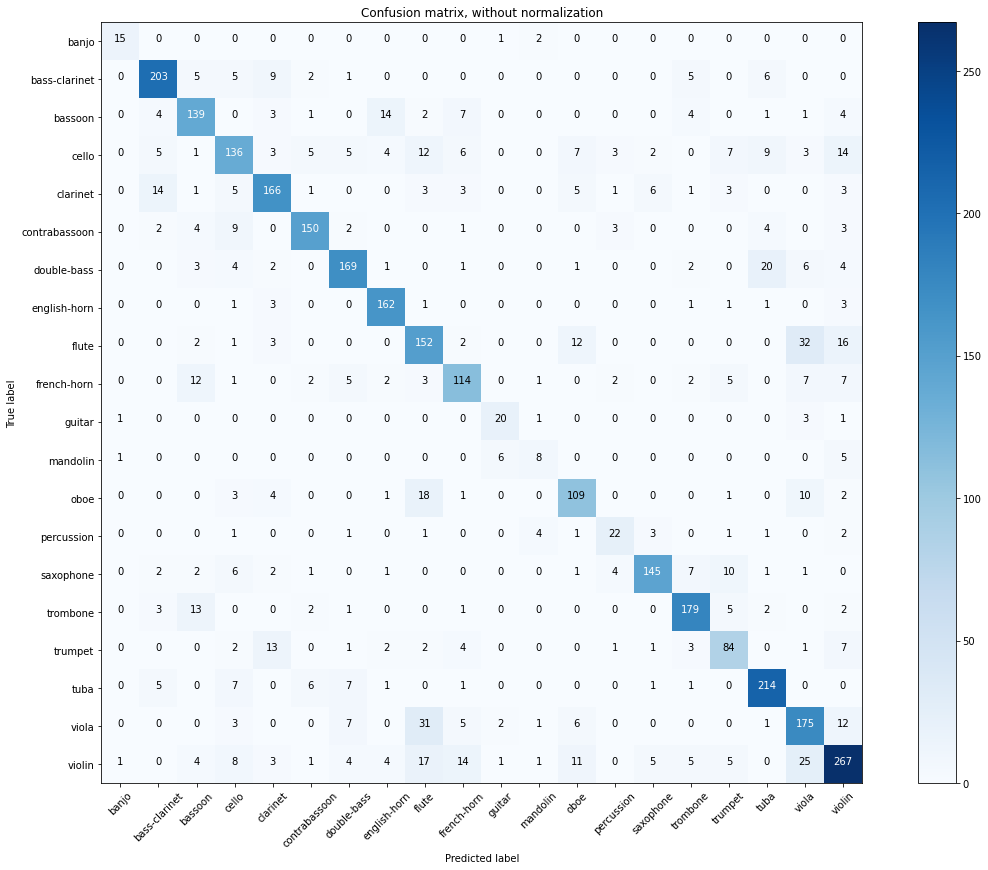

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for Variational Autoencoder experiment 3**

#  load pickle file needed for plotting results for Variational Autoencoder experiment 3

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/VarAutoEncoderExperiment3/histVarAutoEncexp3.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.04



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) < value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.03347892, dtype=float32)] banjo
[array(0.03608764, dtype=float32)] banjo
[array(0.036581, dtype=float32)] violin
[array(0.03323092, dtype=float32)] banjo
[array(0.03949425, dtype=float32)] viola
[array(0.03773673, dtype=float32)] banjo
[array(0.03475085, dtype=float32)] banjo
[array(0.03724731, dtype=float32)] saxophone
[array(0.03996696, dtype=float32)] percussion
[array(0.03911338, dtype=float32)] banjo
[array(0.02987396, dtype=float32)] banjo
[array(0.03440683, dtype=float32)] banjo
[array(0.03418718, dtype=float32)] banjo
[array(0.0382923, dtype=float32)] violin
[array(0.03256942, dtype=float32)] banjo
[array(0.0359898, dtype=float32)] percussion
[array(0.03427242, dtype=float32)] violin
[array(0.03666183, dtype=float32)] banjo
[array(0.03896655, dtype=float32)] banjo
[array(0.03874426, dtype=float32)] banjo


In [ ]:
hist = hist1['hist']
total = 3421
value = 0.25



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) > value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.2528492, dtype=float32)] flute
[array(0.28373674, dtype=float32)] oboe
[array(0.27127147, dtype=float32)] flute
[array(0.26540023, dtype=float32)] violin
[array(0.27361768, dtype=float32)] violin
[array(0.26686856, dtype=float32)] flute
[array(0.29228738, dtype=float32)] clarinet
[array(0.30546835, dtype=float32)] flute
[array(0.25346956, dtype=float32)] clarinet
[array(0.2972564, dtype=float32)] flute
[array(0.27299526, dtype=float32)] trumpet
[array(0.26231745, dtype=float32)] flute
[array(0.2584341, dtype=float32)] violin
[array(0.29947284, dtype=float32)] clarinet
[array(0.2664733, dtype=float32)] clarinet
[array(0.26065004, dtype=float32)] flute
[array(0.28174466, dtype=float32)] violin
[array(0.2709359, dtype=float32)] clarinet


In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 668 (out of 3421)
Validation correct 2753 (out of 3421)


In [ ]:

# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3418, 3419, 3420]),)


In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
print(len(correct_pred_value))

2753


In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))



Bar Chart for Correct Predictions for Variational Autoencoder experiment 3

In [ ]:
banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[16, 215, 150, 137, 180, 147, 158, 165, 156, 135, 19, 13, 122, 20, 151, 182, 85, 212, 203, 287]


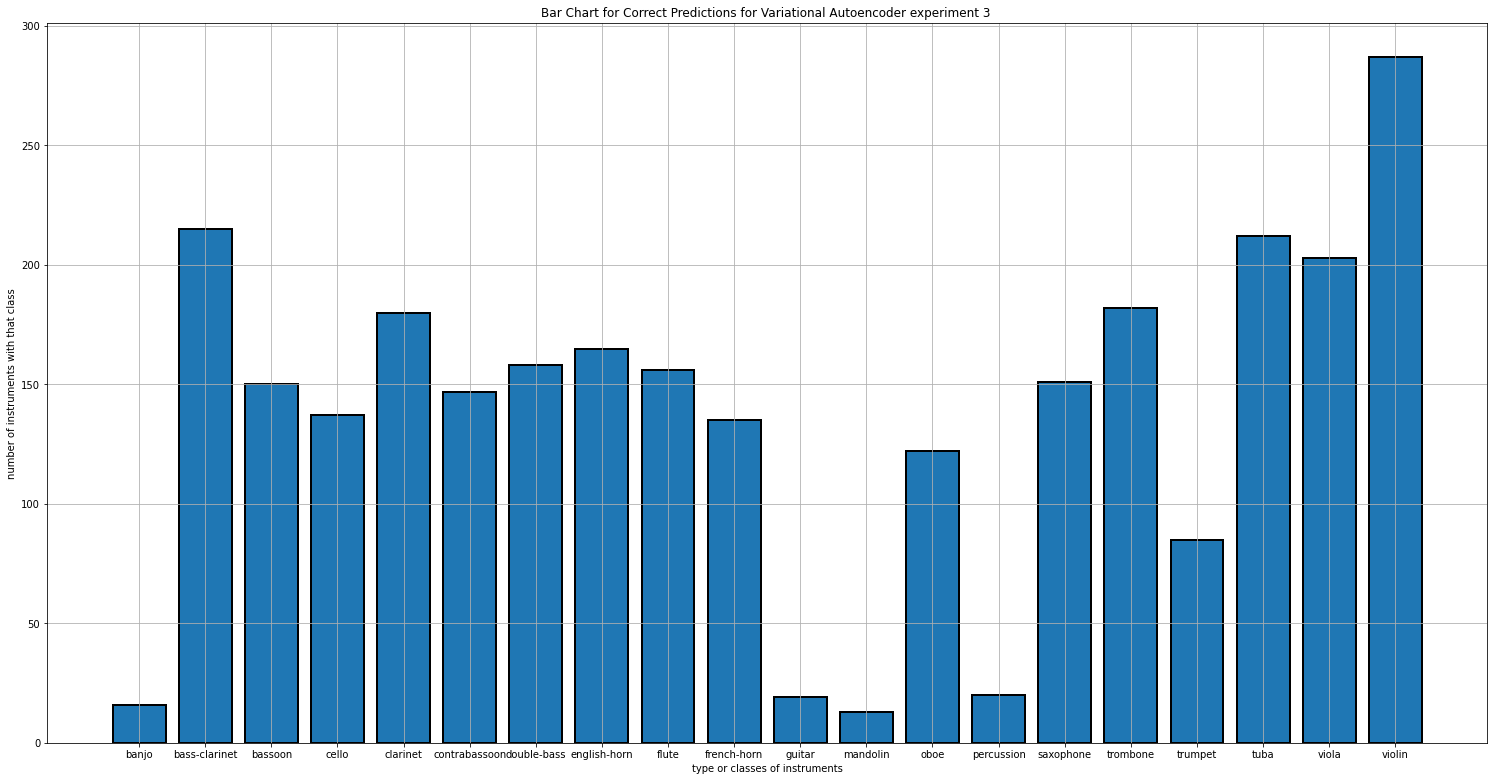

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for Variational Autoencoder experiment 3 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()


Bar Chart for Wrong Predictions for Variational Autoencoder experiment 3

In [ ]:
banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[5, 21, 33, 70, 28, 30, 33, 20, 53, 40, 3, 5, 39, 12, 13, 22, 25, 48, 93, 75]


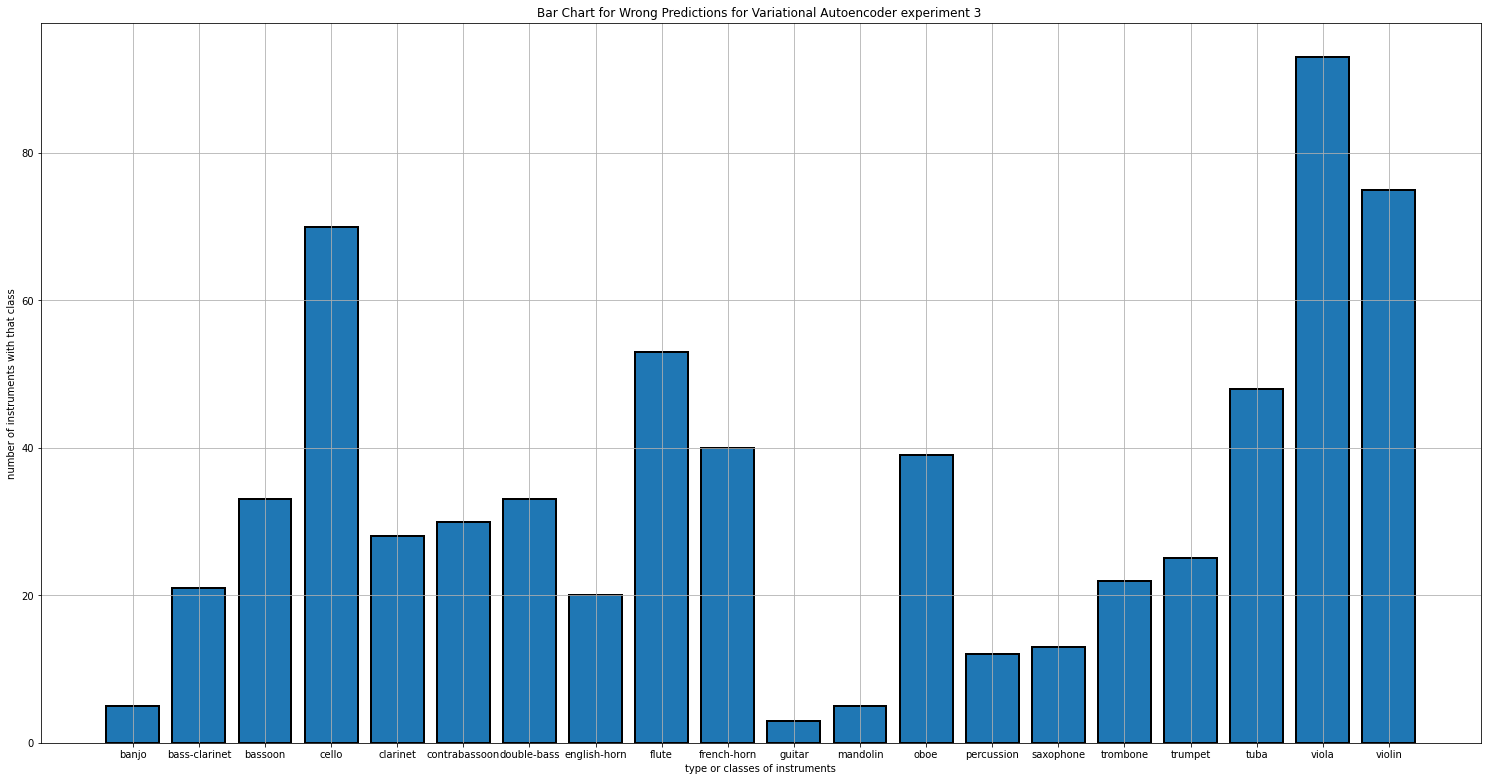

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for Variational Autoencoder experiment 3 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()

Grouped Bar Chart for Correct and Wrong Predictions for Variational Autoencoder experiment 3

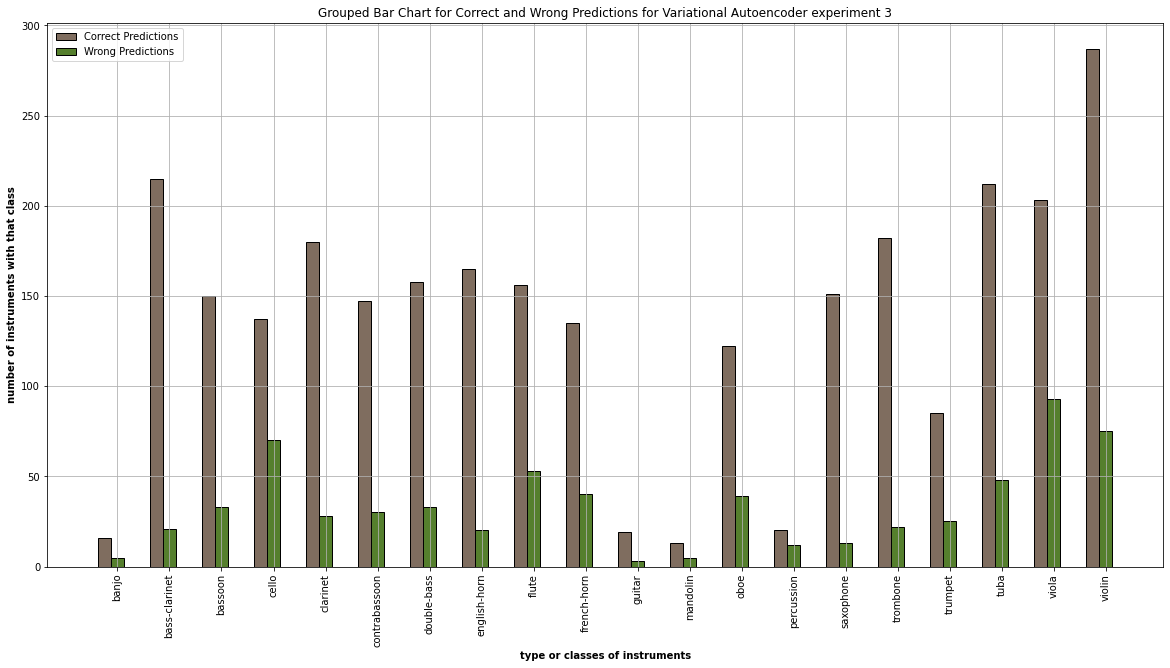

In [ ]:
# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.title('Grouped Bar Chart for Correct and Wrong Predictions for Variational Autoencoder experiment 3')
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
plt.grid()
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for Variational Autoencoder experiment 3

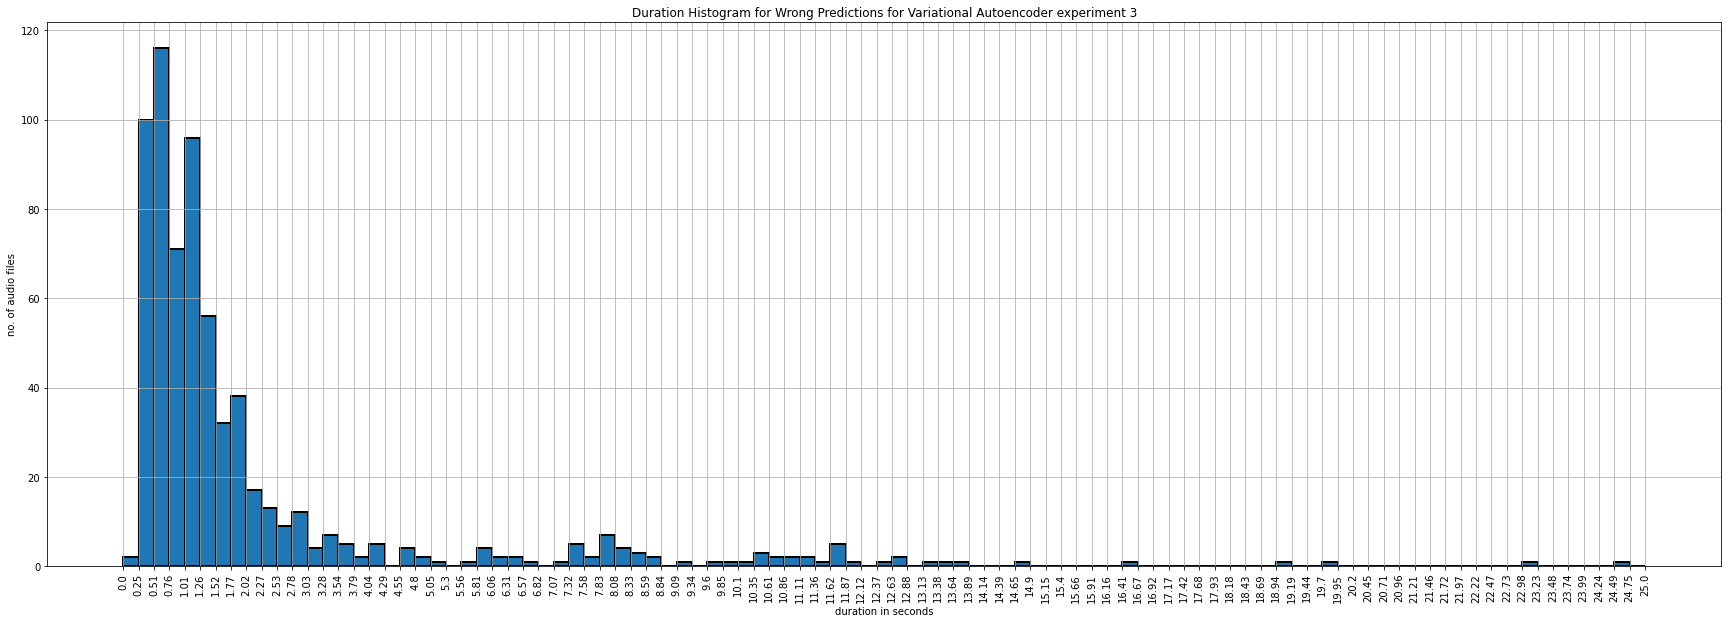

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Variational Autoencoder experiment 3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

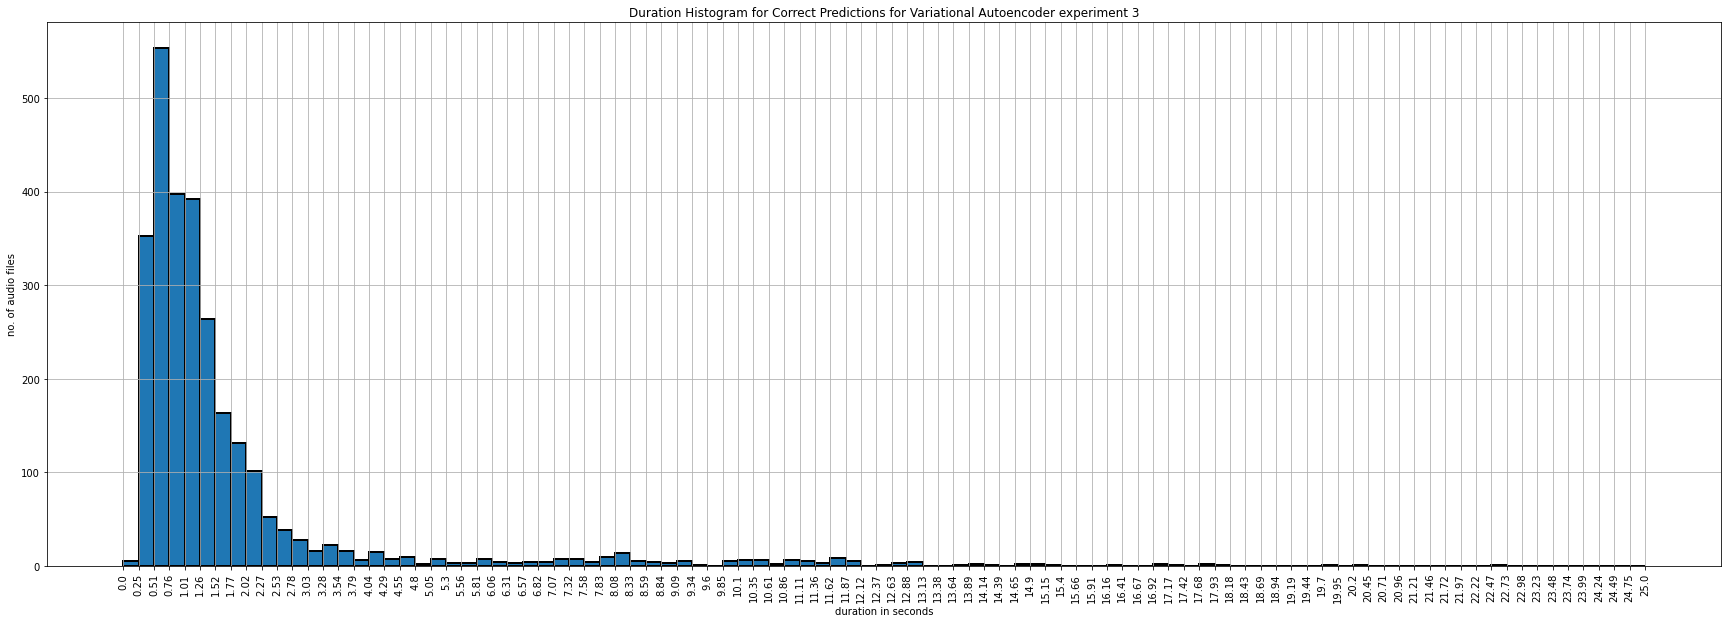

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Variational Autoencoder experiment 3")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for Variational Autoencoder experiment 3

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.3400, num=25)

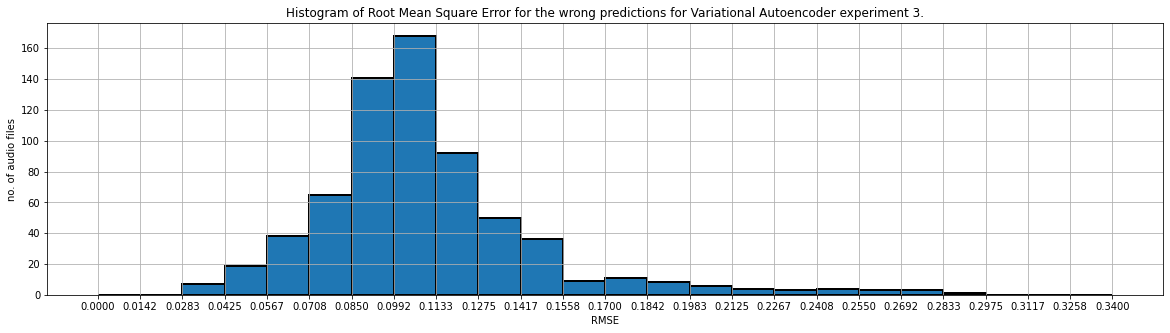

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Variational Autoencoder experiment 3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

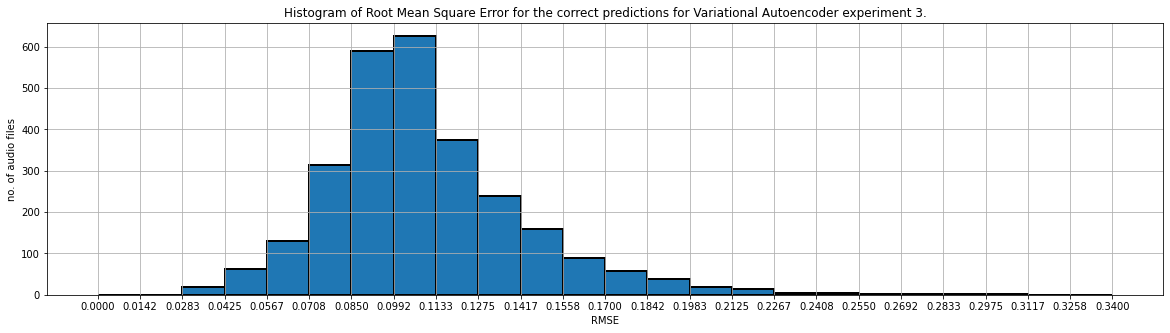

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Variational Autoencoder experiment 3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

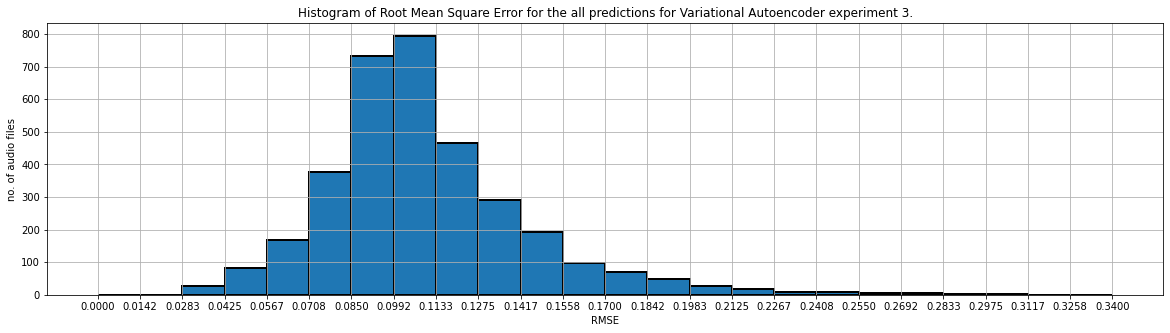

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Variational Autoencoder experiment 3.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Variational Autoencoder experiment 3

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.89 0.91 0.83 0.62 0.85 0.83 0.74 0.95 0.71 0.83 0.73 0.65 0.82 0.54
 0.83 0.88 0.7  0.87 0.84 0.76]
Precision:  [0.76 0.91 0.82 0.66 0.87 0.83 0.83 0.89 0.75 0.77 0.86 0.72 0.76 0.62
 0.92 0.89 0.77 0.82 0.69 0.79]
F1-Score:  [0.82 0.91 0.83 0.64 0.86 0.83 0.78 0.92 0.73 0.8  0.79 0.68 0.79 0.58
 0.87 0.88 0.74 0.84 0.75 0.78]
Accuracy: 0.80  , 2753
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.91      0.91      0.91       236
           2       0.82      0.83      0.83       180
           3       0.66      0.62      0.64       222
           4       0.87      0.85      0.86       212
           5       0.83      0.83      0.83       178
           6       0.83      0.74      0.78       213
           7       0.89      0.95      0.92       173
           8       0.75      0.71      0.73       220
           9       0.77      0.83      0.80       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

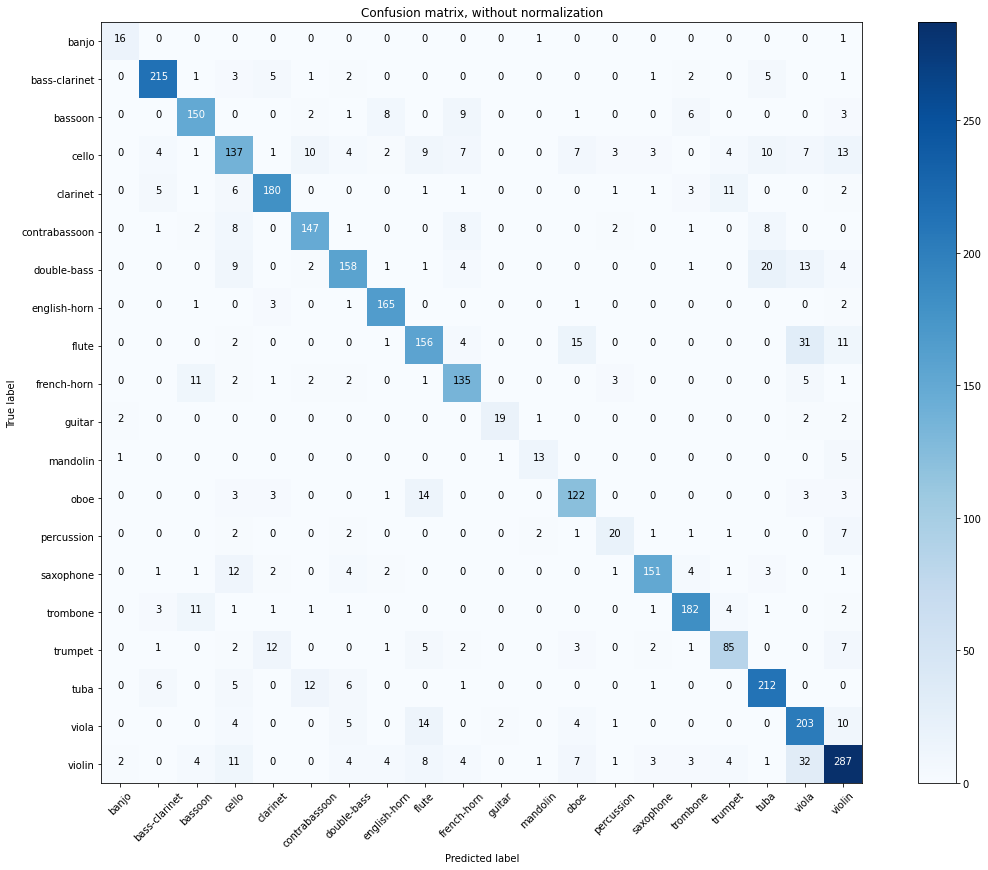

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for Variational Autoencoder experiment 4**

#  load pickle file needed for plotting results for Variational Autoencoder experiment 4

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/VarAutoEncoderExperiment4/histVarAutoEncexp4.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.04



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) < value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.03510898, dtype=float32)] banjo
[array(0.03999247, dtype=float32)] french-horn
[array(0.03963767, dtype=float32)] french-horn
[array(0.03593444, dtype=float32)] banjo
[array(0.03752042, dtype=float32)] violin
[array(0.03571694, dtype=float32)] banjo
[array(0.03814269, dtype=float32)] french-horn
[array(0.03996872, dtype=float32)] viola
[array(0.03961932, dtype=float32)] percussion
[array(0.03675495, dtype=float32)] banjo
[array(0.03555727, dtype=float32)] banjo
[array(0.03714077, dtype=float32)] saxophone
[array(0.0389251, dtype=float32)] banjo
[array(0.03855359, dtype=float32)] percussion
[array(0.03831353, dtype=float32)] guitar
[array(0.03732701, dtype=float32)] banjo
[array(0.0336378, dtype=float32)] banjo
[array(0.03496967, dtype=float32)] banjo
[array(0.03740266, dtype=float32)] guitar
[array(0.0381806, dtype=float32)] banjo
[array(0.03603651, dtype=float32)] banjo
[array(0.03919519, dtype=float32)] violin
[array(0.03982473, dtype=float32)] saxophone
[array(0.03867922, d

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.25



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) > value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.2589587, dtype=float32)] violin
[array(0.25884682, dtype=float32)] violin
[array(0.26376802, dtype=float32)] clarinet
[array(0.28299773, dtype=float32)] flute
[array(0.25502893, dtype=float32)] violin
[array(0.29009816, dtype=float32)] clarinet
[array(0.2792056, dtype=float32)] violin
[array(0.2569924, dtype=float32)] clarinet


In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 739 (out of 3421)
Validation correct 2682 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)


In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Bar Chart for Correct Predictions for Variational Autoencoder experiment 4

In [ ]:
banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[16, 213, 152, 119, 184, 141, 160, 157, 143, 136, 20, 15, 130, 22, 133, 174, 75, 202, 197, 293]


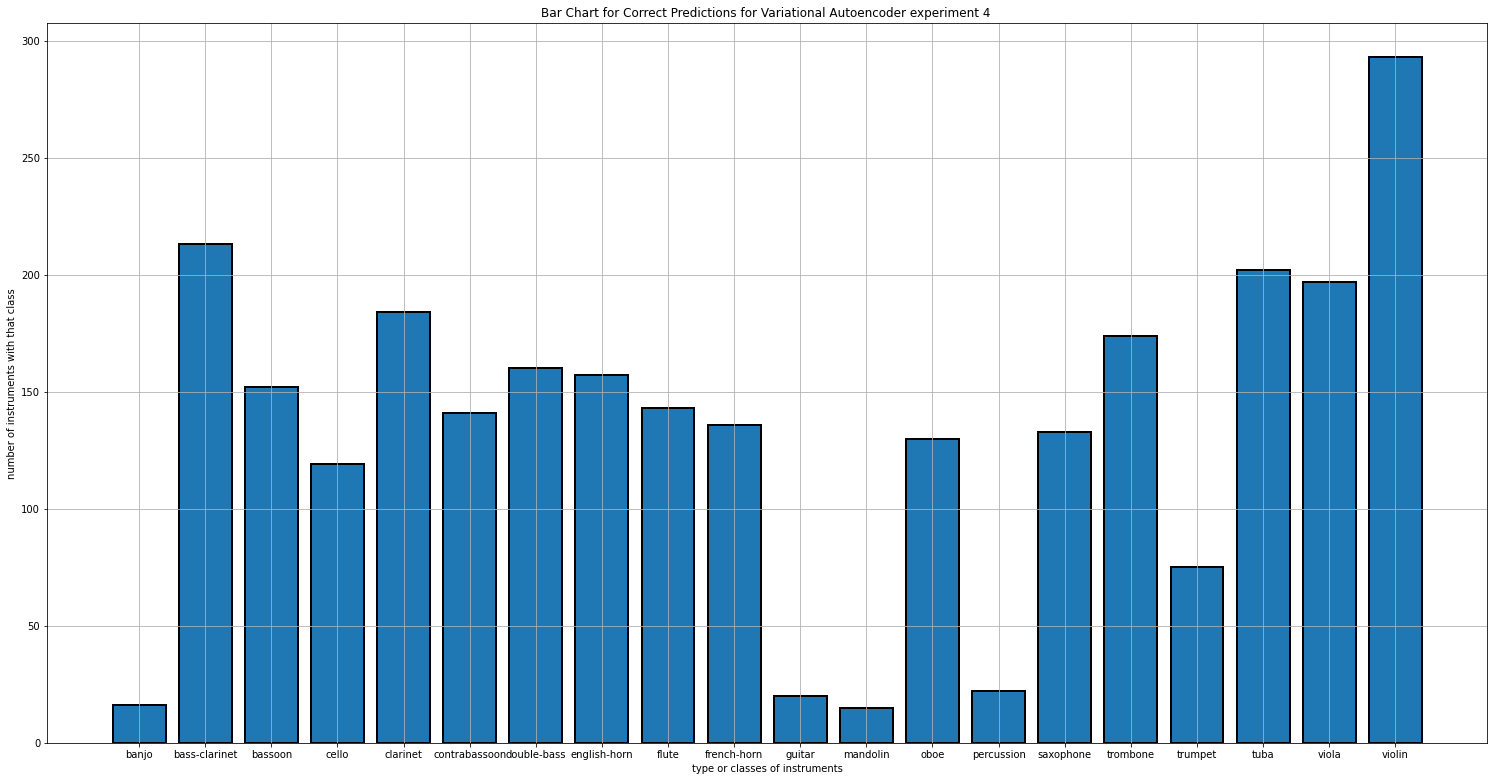

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for Variational Autoencoder experiment 4 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()


Bar Chart for Wrong Predictions for Variational Autoencoder experiment 4

In [ ]:
banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[2, 16, 45, 66, 43, 57, 34, 13, 72, 32, 2, 4, 34, 12, 25, 24, 26, 54, 97, 81]


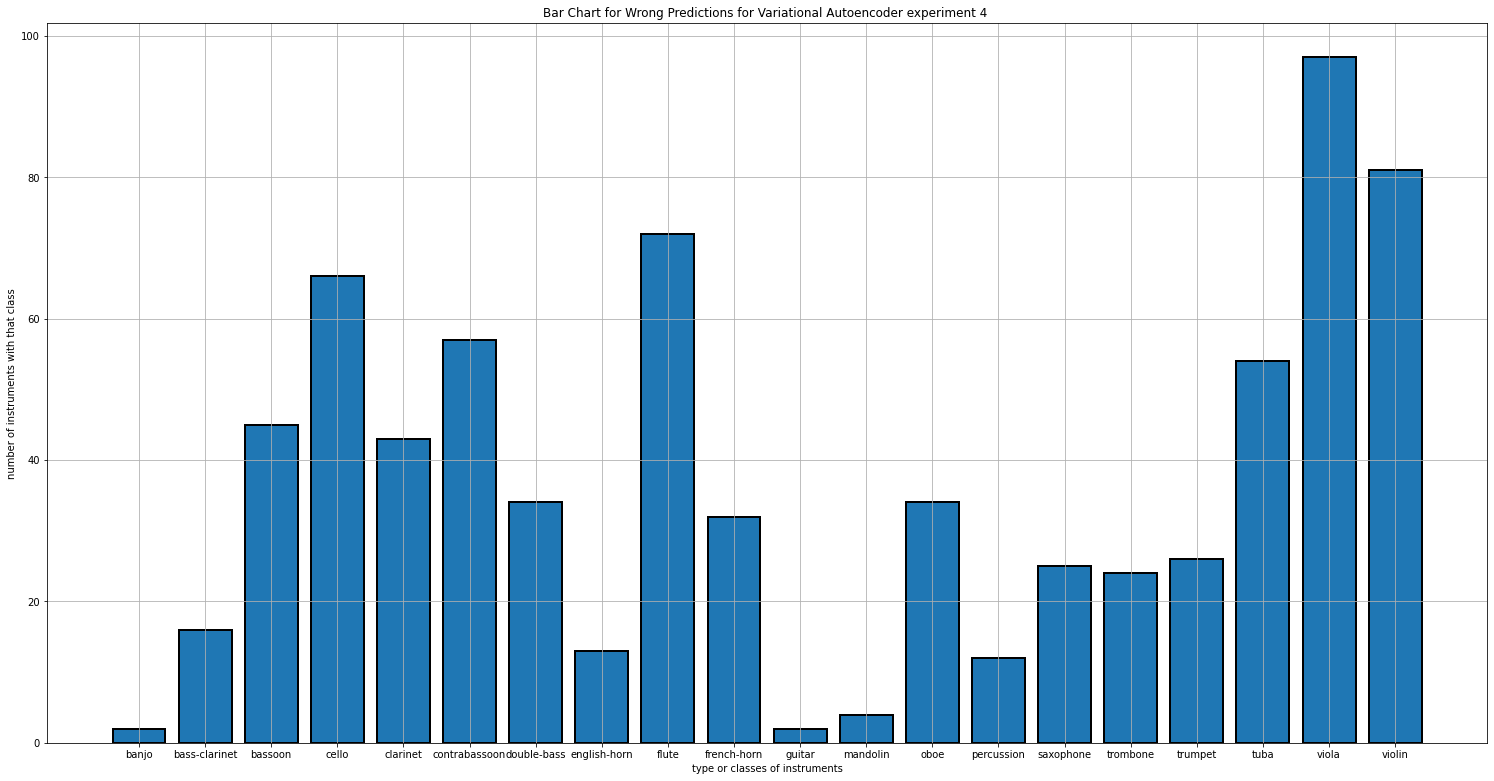

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for Variational Autoencoder experiment 4 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()

Grouped Bar Chart for Correct and Wrong Predictions for Variational Autoencoder experiment 4

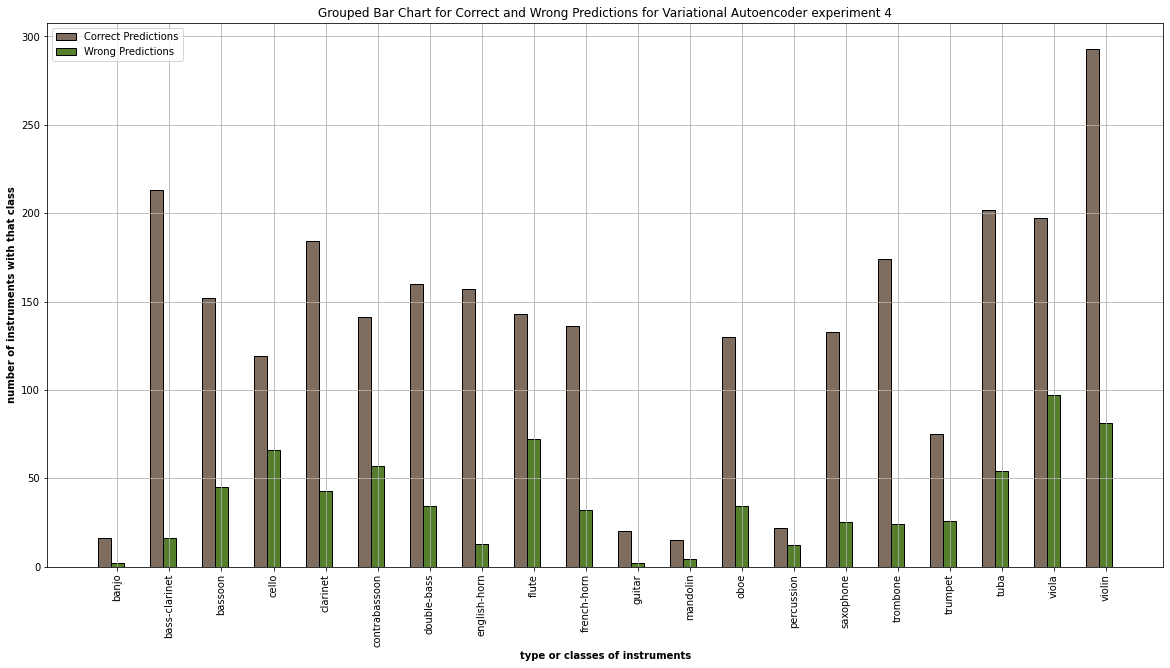

In [ ]:
# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.title('Grouped Bar Chart for Correct and Wrong Predictions for Variational Autoencoder experiment 4')
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
plt.grid()
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for Variational Autoencoder experiment 4

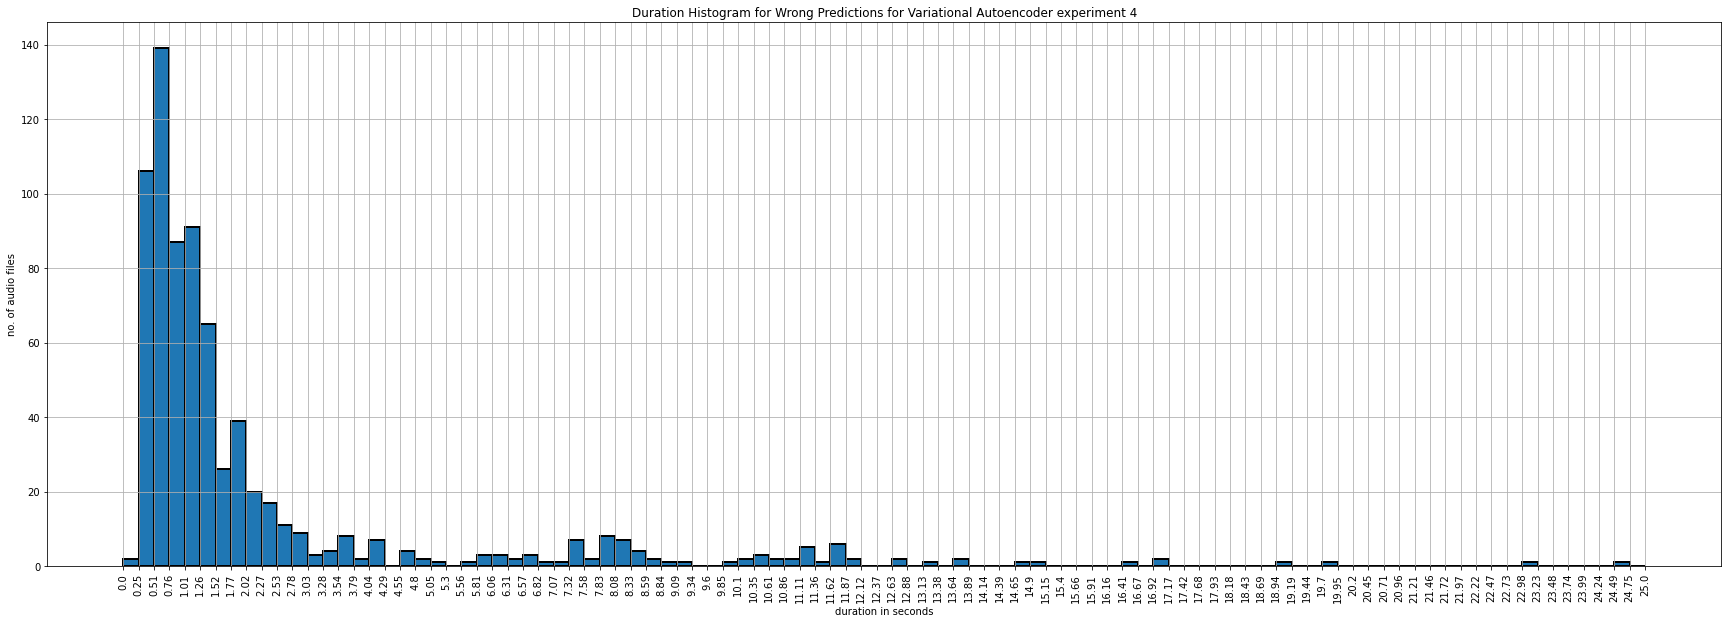

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Variational Autoencoder experiment 4")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

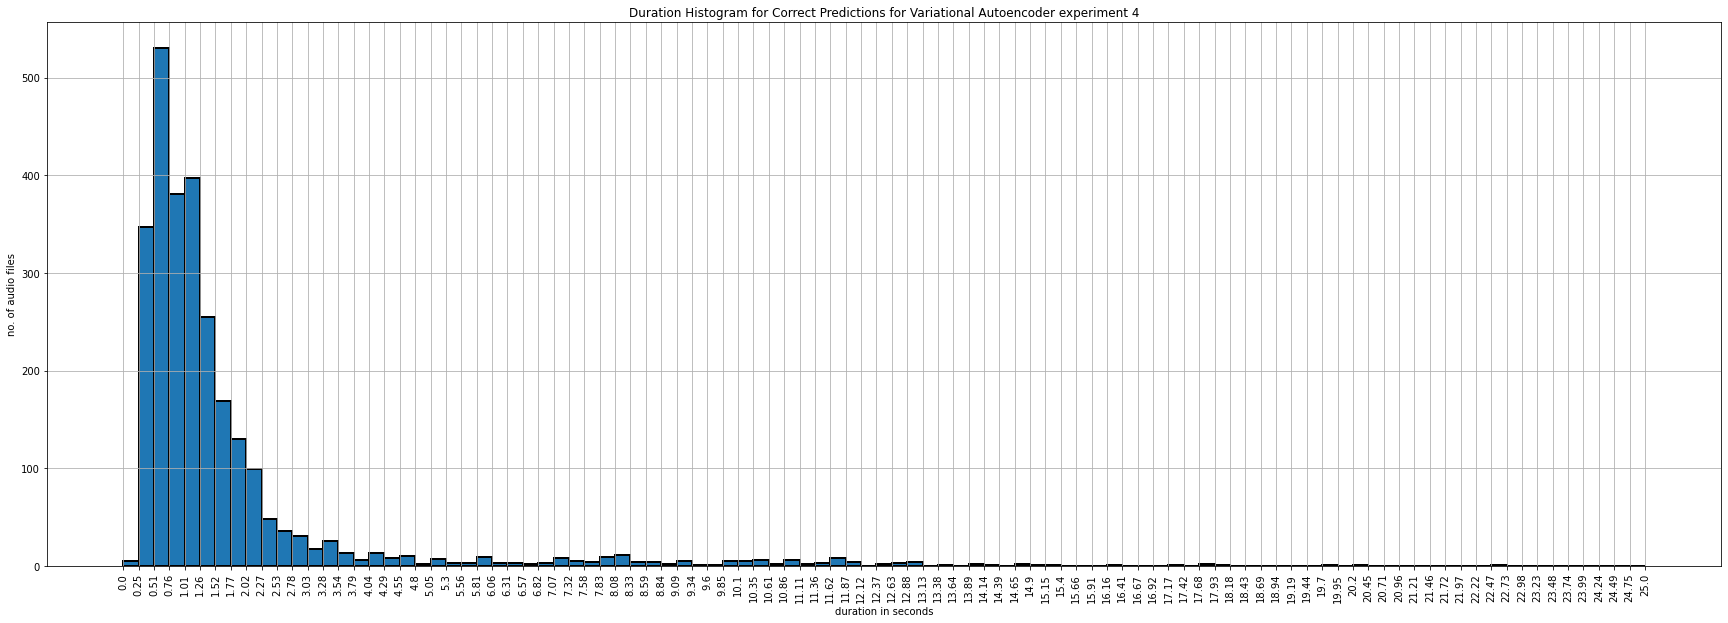

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Variational Autoencoder experiment 4")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for Variational Autoencoder experiment 4

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.3400, num=25)

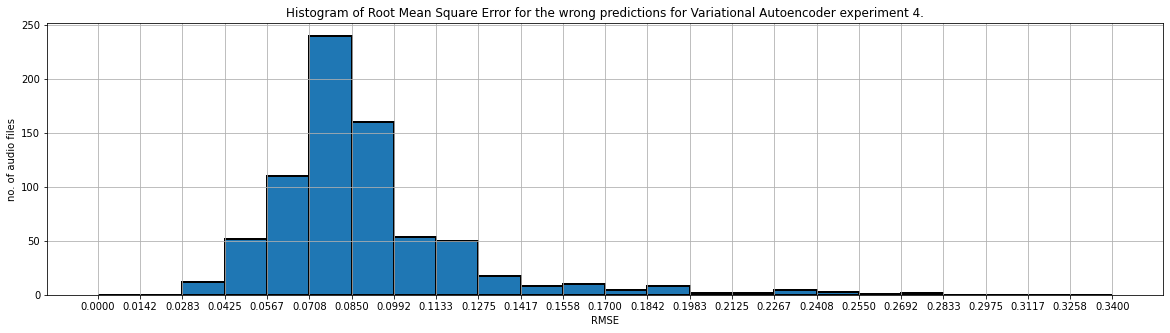

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Variational Autoencoder experiment 4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

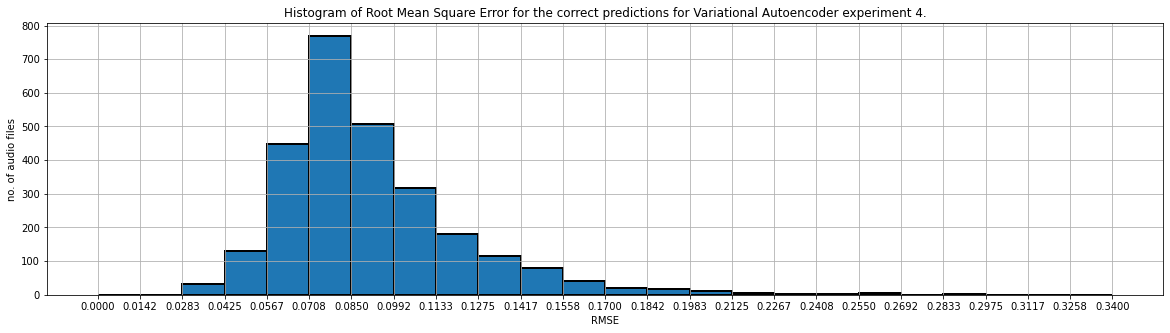

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Variational Autoencoder experiment 4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

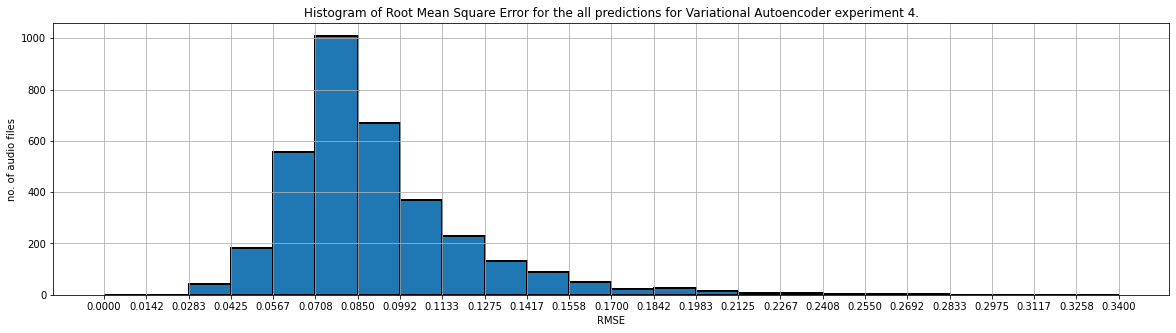

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Variational Autoencoder experiment 4.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Variational Autoencoder experiment 4

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.89 0.9  0.84 0.54 0.87 0.79 0.75 0.91 0.65 0.83 0.77 0.75 0.87 0.59
 0.73 0.84 0.62 0.83 0.81 0.78]
Precision:  [0.89 0.93 0.77 0.64 0.81 0.71 0.82 0.92 0.67 0.81 0.91 0.79 0.79 0.65
 0.84 0.88 0.74 0.79 0.67 0.78]
F1-Score:  [0.89 0.92 0.81 0.58 0.84 0.75 0.79 0.92 0.66 0.82 0.83 0.77 0.83 0.62
 0.78 0.86 0.68 0.81 0.73 0.78]
Accuracy: 0.78  , 2682
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.93      0.90      0.92       236
           2       0.77      0.84      0.81       180
           3       0.64      0.54      0.58       222
           4       0.81      0.87      0.84       212
           5       0.71      0.79      0.75       178
           6       0.82      0.75      0.79       213
           7       0.92      0.91      0.92       173
           8       0.67      0.65      0.66       220
           9       0.81      0.83      0.82       163
          10     

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

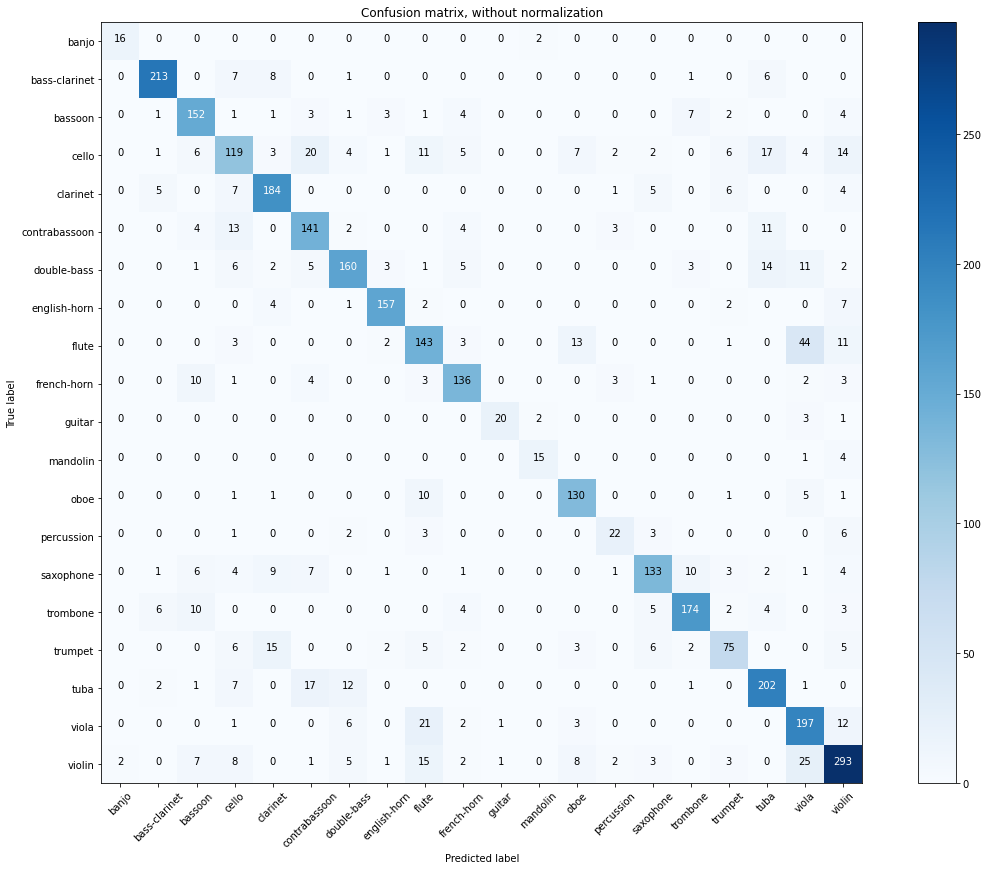

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

# **Experiment Results for Variational Autoencoder experiment 5**

#  load pickle file needed for plotting results for Variational Autoencoder experiment 5

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/VarAutoEncoderExperiment5/histVarAutoEncexp5.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
total = 3421
value = 0.03



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) < value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.02898637, dtype=float32)] banjo
[array(0.02988638, dtype=float32)] banjo
[array(0.02992912, dtype=float32)] banjo
[array(0.02932592, dtype=float32)] banjo
[array(0.02932471, dtype=float32)] banjo
[array(0.02966625, dtype=float32)] banjo
[array(0.02997624, dtype=float32)] banjo
[array(0.02931112, dtype=float32)] banjo
[array(0.02990065, dtype=float32)] violin
[array(0.0297162, dtype=float32)] banjo


In [ ]:
hist = hist1['hist']
total = 3421
value = 0.20



for i in range(total):
  value1 = hist["valid_rmse"][0][i][0]
  if float(value1) > value :
     print(hist["valid_rmse"][0][i] ,test_class[i])

[array(0.22923645, dtype=float32)] flute
[array(0.22599137, dtype=float32)] flute
[array(0.2366029, dtype=float32)] violin
[array(0.20951107, dtype=float32)] violin
[array(0.21696731, dtype=float32)] clarinet
[array(0.20489585, dtype=float32)] flute
[array(0.24701221, dtype=float32)] flute
[array(0.23201048, dtype=float32)] trumpet
[array(0.25262335, dtype=float32)] violin
[array(0.27161458, dtype=float32)] clarinet
[array(0.2245729, dtype=float32)] cello
[array(0.21731055, dtype=float32)] flute
[array(0.26425585, dtype=float32)] violin
[array(0.21330968, dtype=float32)] clarinet


In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 806 (out of 3421)
Validation correct 2615 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

bc_correct_pred = []
bc_wrong_pred = []
#print(hist['valid_predictions'][0][(correct_pred[0][0])])

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])
  bc_wrong_pred.append(hist['valid_predictions'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])
  bc_correct_pred.append(hist['valid_predictions'][0][(correct_pred[0][y])])
for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

#print(type(rmse_all_pred))
#print(rmse_all_pred[0])




#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)


In [ ]:
test_list = test_set['duration'].values.tolist()
#print((test_list))
#print(wrong_pred [0][754])
#print(test_list[wrong_pred [0][754]])

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
#print(len(correct_pred_value))

In [ ]:
ranges_dur = np.linspace(0,25, num=100)
#print(ranges_dur)
#print(np.round(ranges_dur,2))


Bar Chart for Correct Predictions for Variational Autoencoder experiment 5

In [ ]:
banjo = bc_correct_pred.count(0)
bassclarinet = bc_correct_pred.count(1)
bassoon = bc_correct_pred.count(2)
cello = bc_correct_pred.count(3)
clarinet = bc_correct_pred.count(4)
contrabassoon = bc_correct_pred.count(5)
doublebass = bc_correct_pred.count(6)
englishhorn = bc_correct_pred.count(7)
flute = bc_correct_pred.count(8)
frenchhorn = bc_correct_pred.count(9)
guitar = bc_correct_pred.count(10)
mandolin = bc_correct_pred.count(11)
oboe = bc_correct_pred.count(12)
percussion = bc_correct_pred.count(13)
saxophone = bc_correct_pred.count(14)
trombone = bc_correct_pred.count(15)
trumpet = bc_correct_pred.count(16)
tuba = bc_correct_pred.count(17)
viola = bc_correct_pred.count(18)
violin = bc_correct_pred.count(19)

arr = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr)

[15, 201, 147, 115, 178, 140, 149, 157, 146, 118, 22, 11, 127, 16, 133, 169, 71, 210, 193, 297]


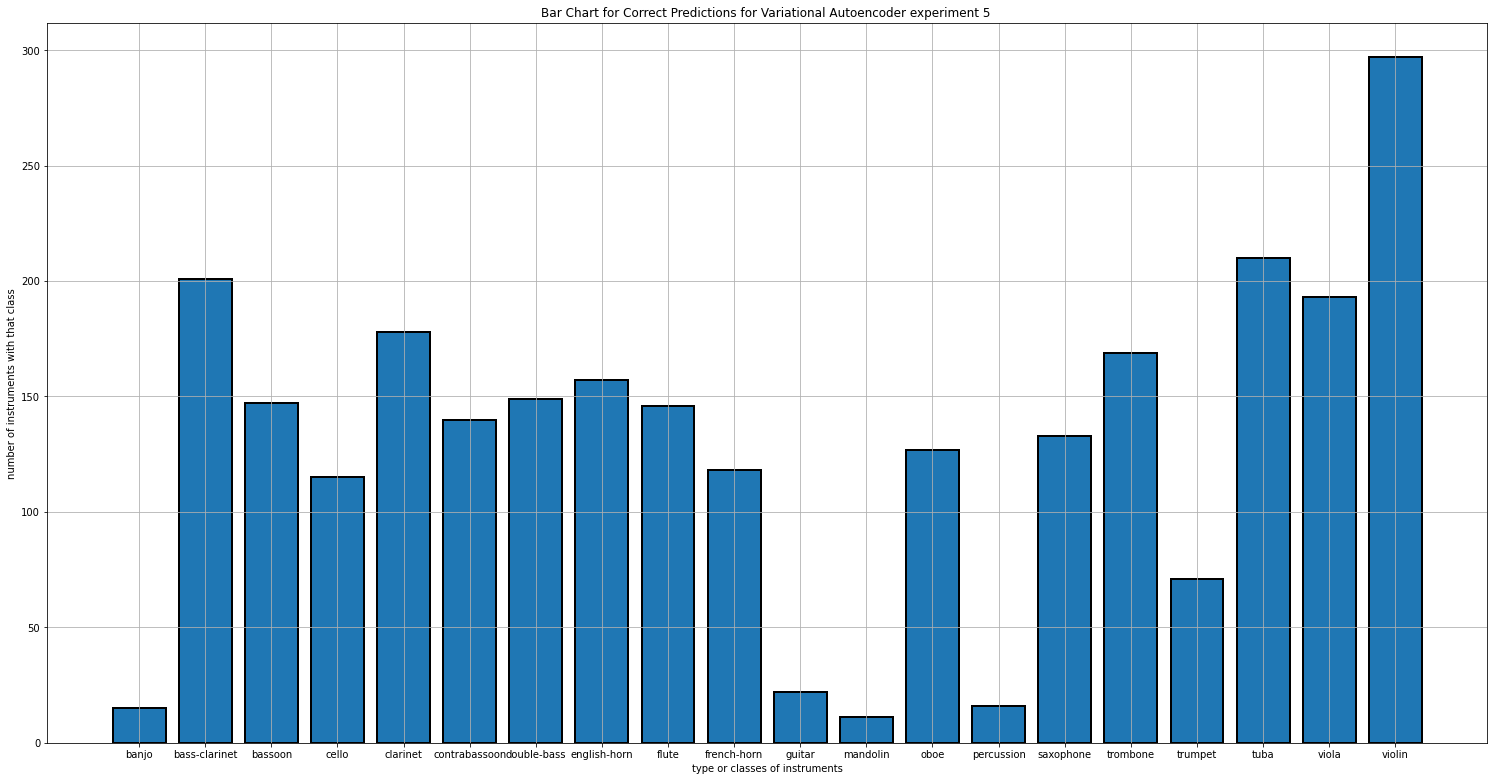

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Correct Predictions for Variational Autoencoder experiment 5 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr,edgecolor="black",linewidth=2)
plt.show()

Bar Chart for Wrong Predictions for Variational Autoencoder experiment 5

In [ ]:

banjo = bc_wrong_pred.count(0)
bassclarinet = bc_wrong_pred.count(1)
bassoon = bc_wrong_pred.count(2)
cello = bc_wrong_pred.count(3)
clarinet = bc_wrong_pred.count(4)
contrabassoon = bc_wrong_pred.count(5)
doublebass = bc_wrong_pred.count(6)
englishhorn = bc_wrong_pred.count(7)
flute = bc_wrong_pred.count(8)
frenchhorn = bc_wrong_pred.count(9)
guitar = bc_wrong_pred.count(10)
mandolin = bc_wrong_pred.count(11)
oboe = bc_wrong_pred.count(12)
percussion = bc_wrong_pred.count(13)
saxophone = bc_wrong_pred.count(14)
trombone = bc_wrong_pred.count(15)
trumpet = bc_wrong_pred.count(16)
tuba = bc_wrong_pred.count(17)
viola = bc_wrong_pred.count(18)
violin = bc_wrong_pred.count(19)

arr1 = [banjo, bassclarinet, bassoon, cello, clarinet, contrabassoon, doublebass, englishhorn, flute, frenchhorn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin]
print(arr1)

[1, 18, 63, 75, 52, 42, 34, 25, 67, 36, 4, 4, 25, 16, 33, 22, 29, 68, 85, 107]


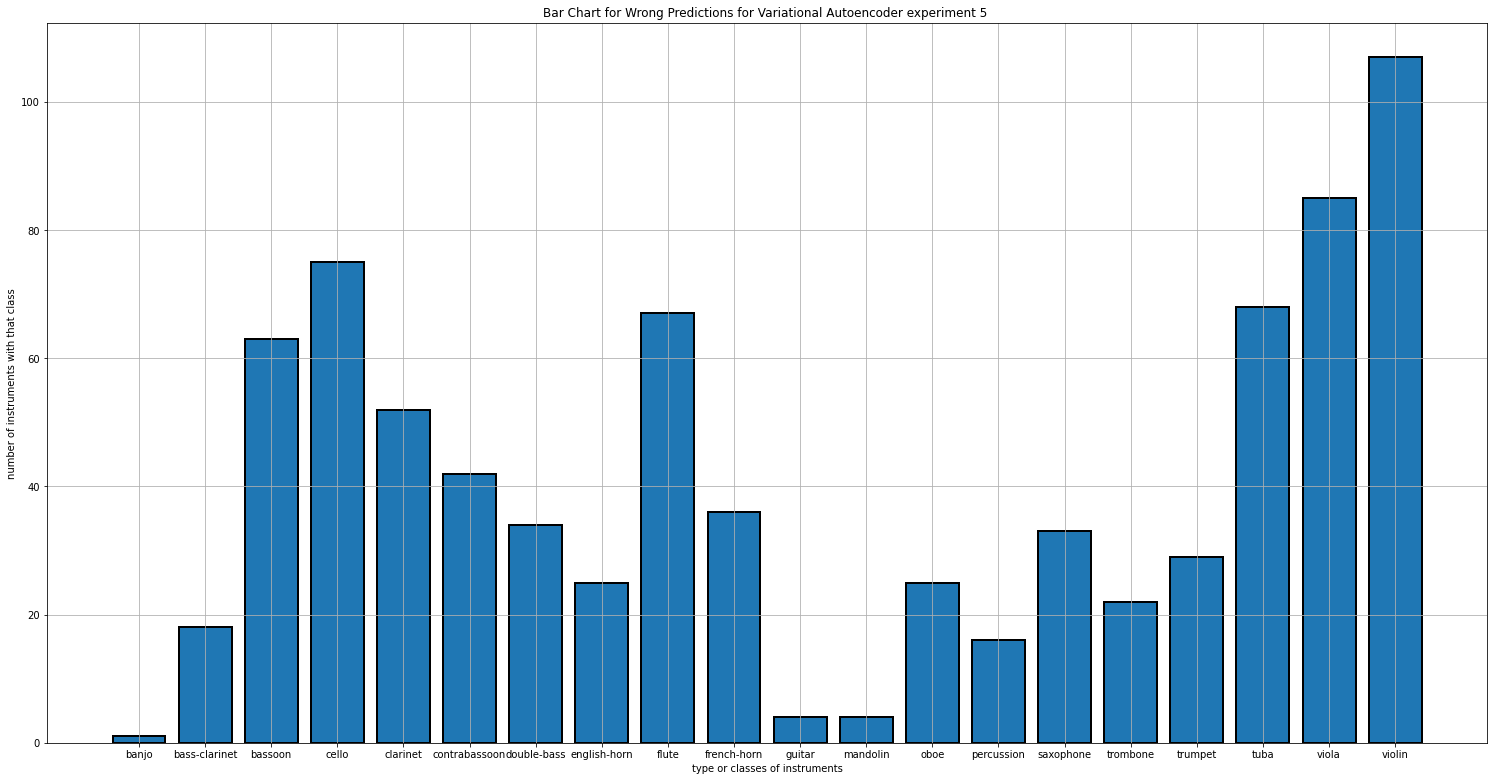

In [ ]:

fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0,0,1,1])
classes_instrument = ['banjo', 'bass-clarinet', 'bassoon', 'cello', 'clarinet', 'contrabassoon', 'double-bass', 'english-horn', 'flute', 'french-horn', 'guitar', 'mandolin', 'oboe', 'percussion', 'saxophone', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
#students = [23,17,35,29,12]
ax.set_title("Bar Chart for Wrong Predictions for Variational Autoencoder experiment 5 ")
ax.set_xlabel('type or classes of instruments')
ax.set_ylabel('number of instruments with that class')
ax.grid()
ax.bar(classes_instrument,arr1,edgecolor="black",linewidth=2)
plt.show()

Grouped Bar Chart for Correct and Wrong Predictions for Variational Autoencoder experiment 5

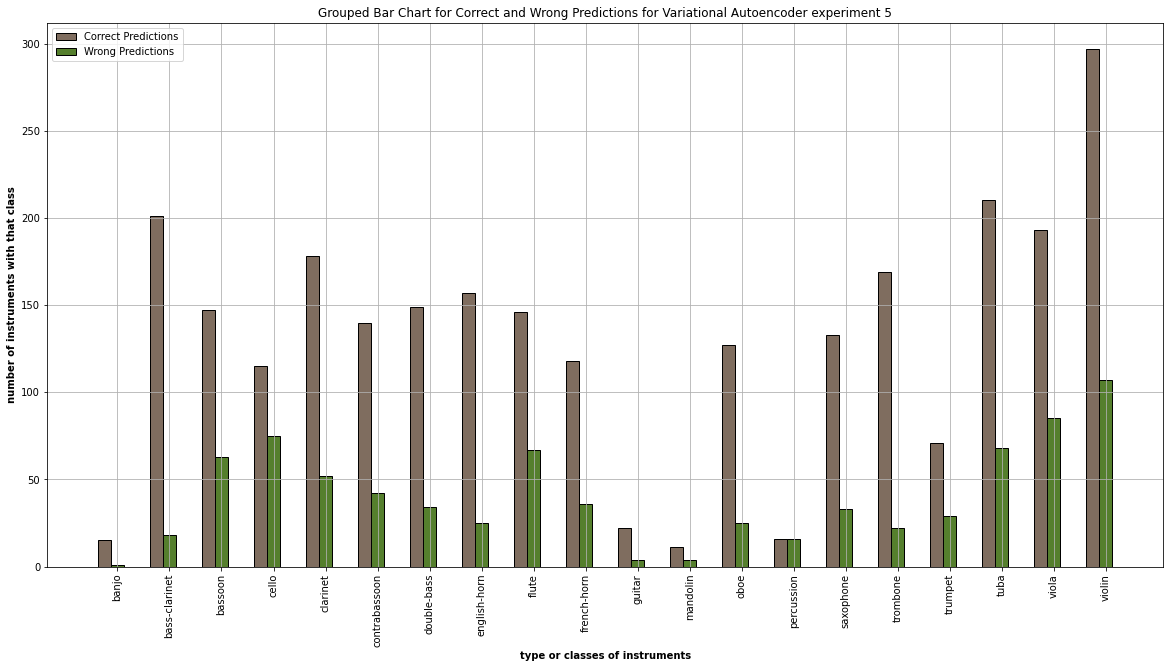

In [ ]:
# set width of bars
barWidth = 0.25
plt.figure(figsize=(20, 10))


 
# Set position of bar on X axis
r1 = np.arange(len(arr))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, arr, color='#7f6d5f', width=barWidth, edgecolor='black',label='Correct Predictions')
plt.bar(r2, arr1, color='#557f2d', width=barWidth, edgecolor='black', label='Wrong Predictions')


 
# Add xticks on the middle of the group bars
plt.title('Grouped Bar Chart for Correct and Wrong Predictions for Variational Autoencoder experiment 5')
plt.xlabel('type or classes of instruments', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(arr))], classes_instrument,rotation=90)
plt.ylabel('number of instruments with that class',fontweight='bold')
plt.grid()
 
# Create legend & Show graphic
plt.legend()
plt.show()

Duration histograms for wrong and correct predictions for Variational Autoencoder experiment 5

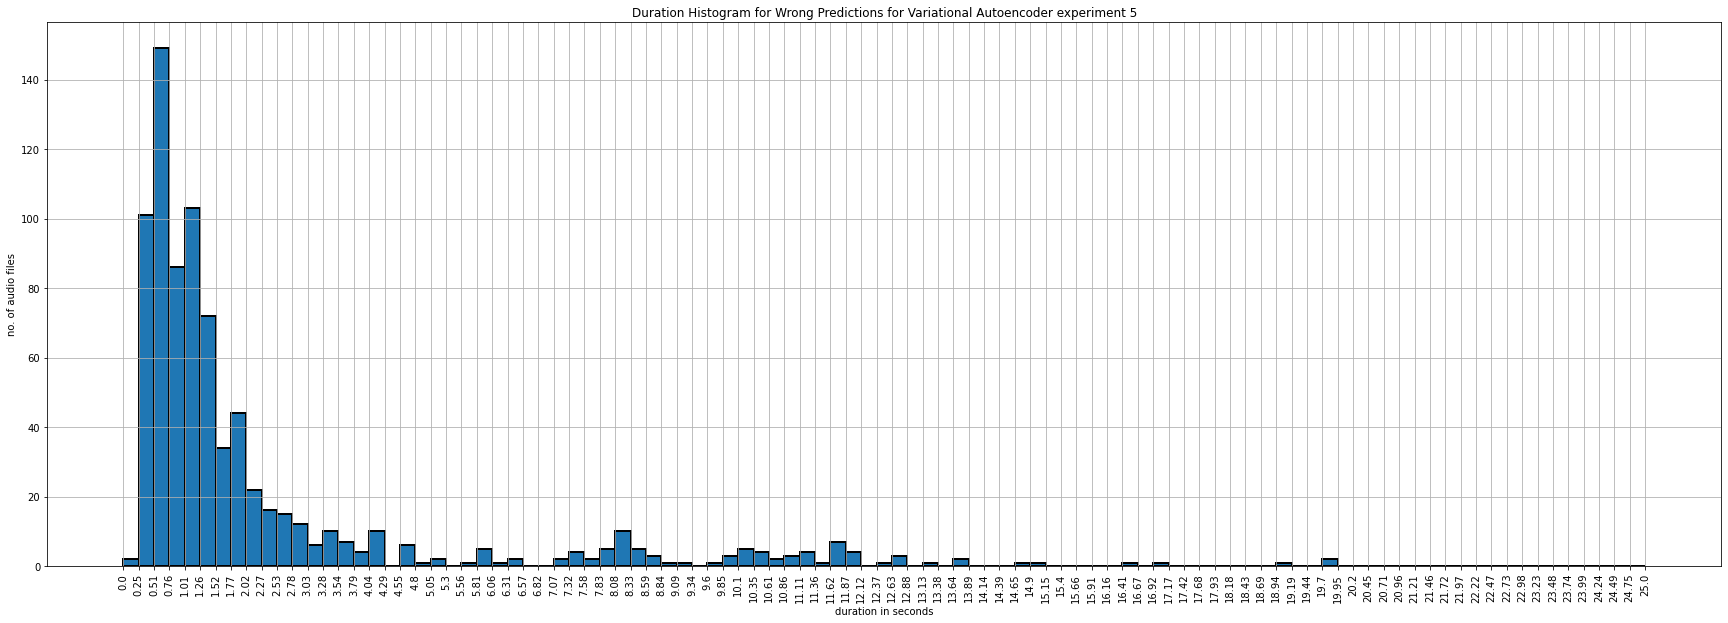

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Variational Autoencoder experiment 5")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

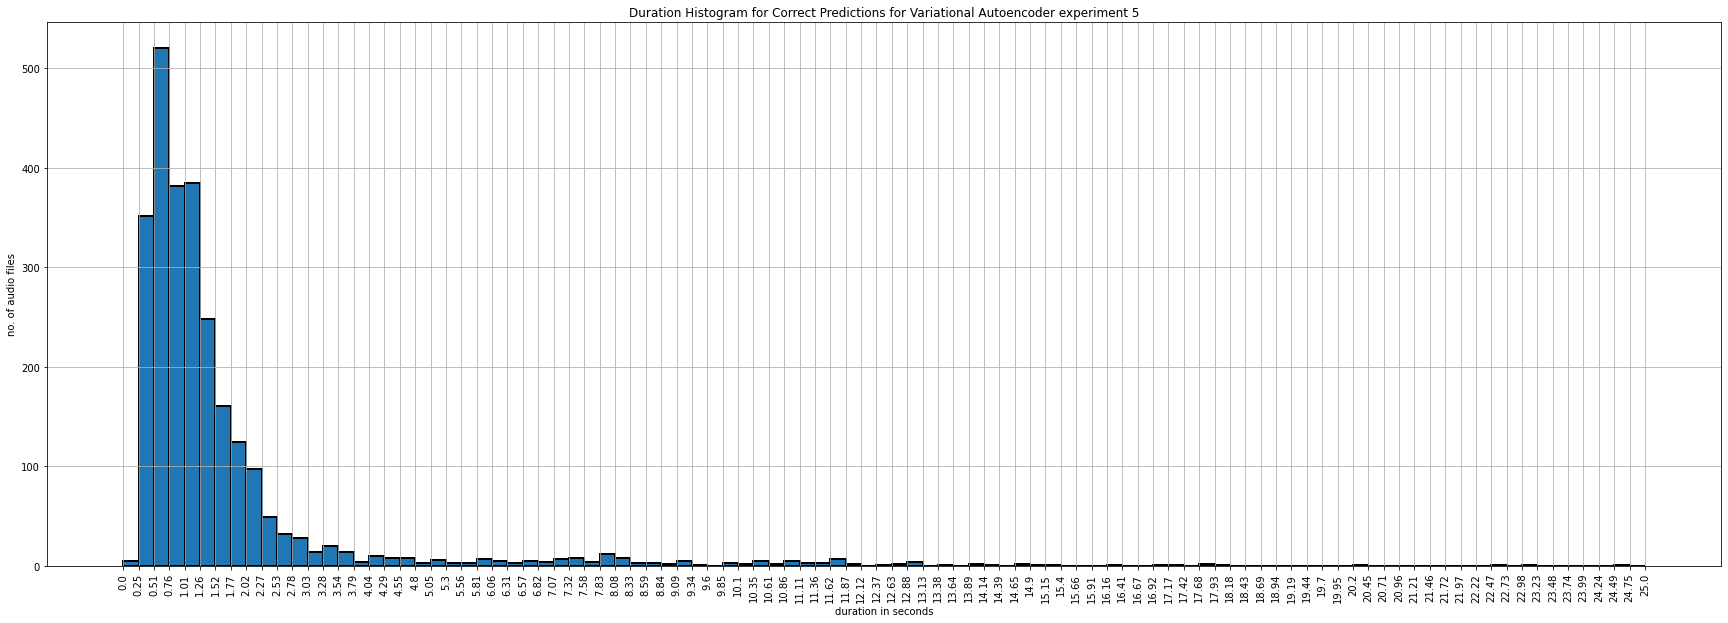

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Variational Autoencoder experiment 5")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for Variational Autoencoder experiment 5

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.3400, num=25)

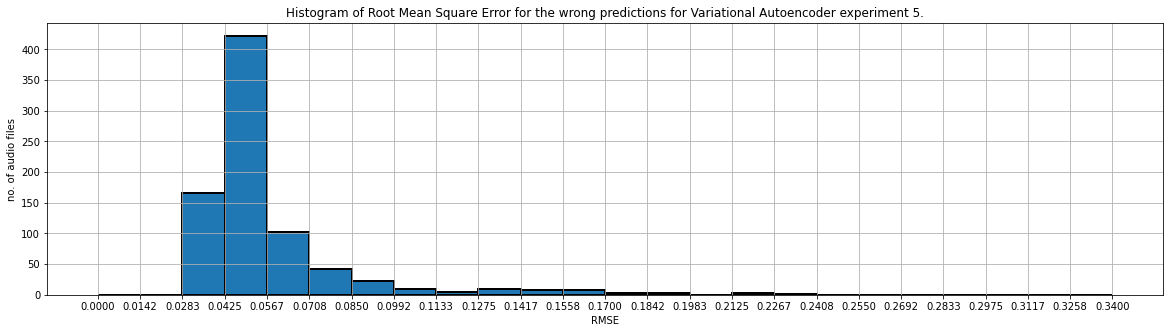

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Variational Autoencoder experiment 5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

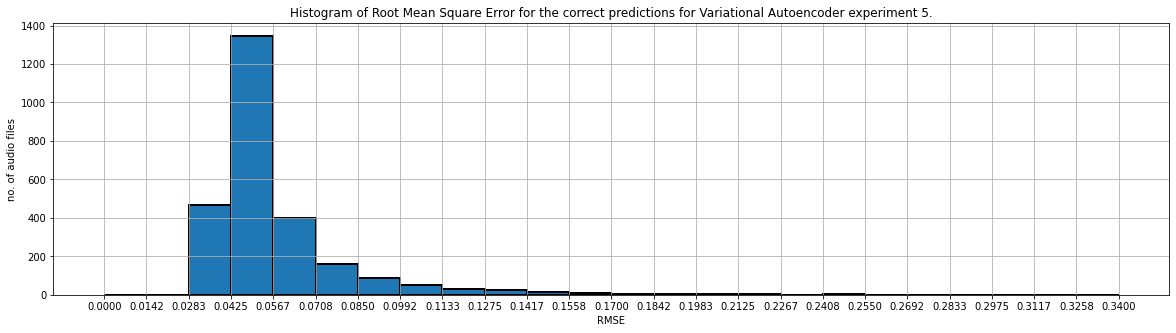

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Variational Autoencoder experiment 5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

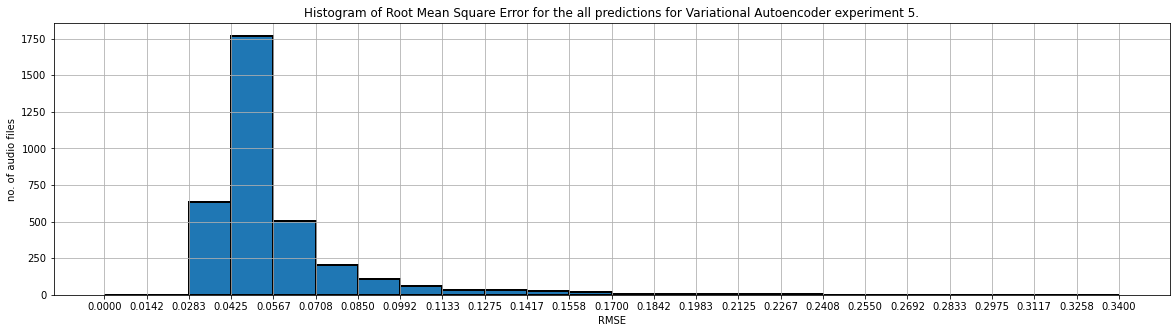

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Variational Autoencoder experiment 5.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Variational Autoencoder experiment 5

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83 0.85 0.82 0.52 0.84 0.79 0.7  0.91 0.66 0.72 0.85 0.55 0.85 0.43
 0.73 0.81 0.59 0.86 0.79 0.79]
Precision:  [0.94 0.92 0.7  0.61 0.77 0.77 0.81 0.86 0.69 0.77 0.85 0.73 0.84 0.5
 0.8  0.88 0.71 0.76 0.69 0.74]
F1-Score:  [0.88 0.88 0.75 0.56 0.81 0.78 0.75 0.88 0.67 0.74 0.85 0.63 0.84 0.46
 0.76 0.85 0.64 0.81 0.74 0.76]
Accuracy: 0.76  , 2615
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.92      0.85      0.88       236
           2       0.70      0.82      0.75       180
           3       0.61      0.52      0.56       222
           4       0.77      0.84      0.81       212
           5       0.77      0.79      0.78       178
           6       0.81      0.70      0.75       213
           7       0.86      0.91      0.88       173
           8       0.69      0.66      0.67       220
           9       0.77      0.72      0.74       163
          10      

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

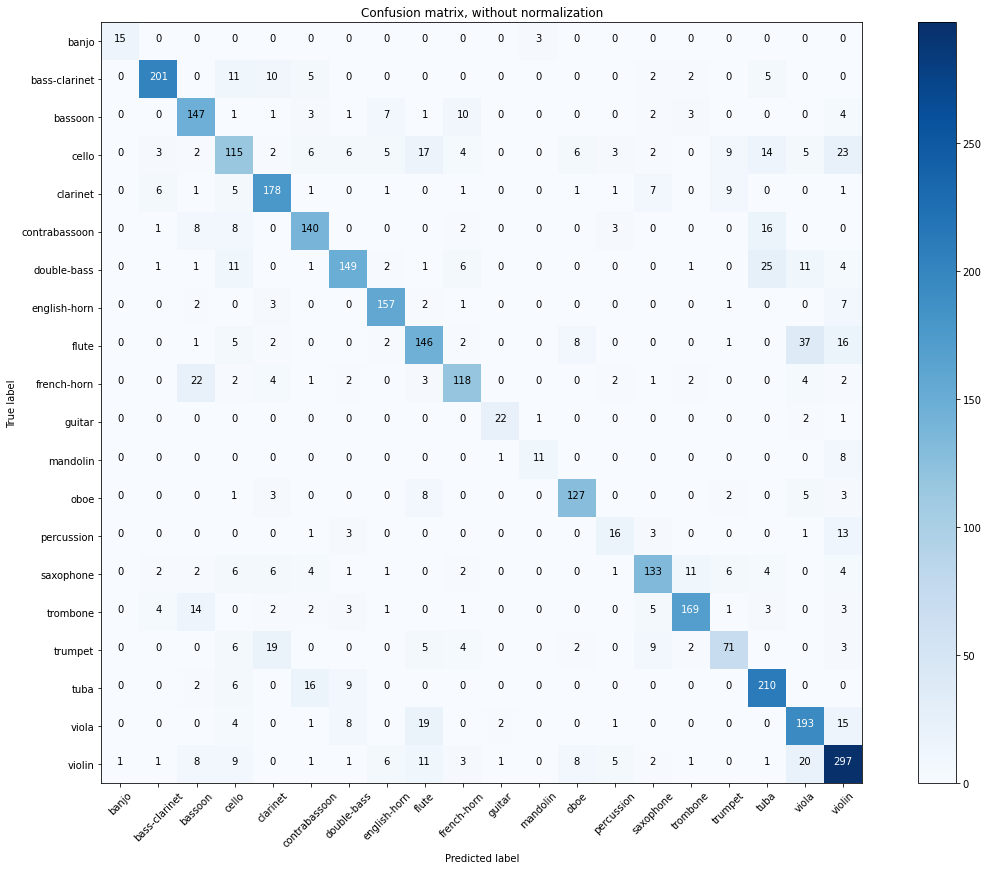

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')